# Forecasting Crude Oil Price

In [80]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.4.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
async-generator               1.10
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
bin

In [81]:
!pip install tensorflow==1.13.2
!pip install --upgrade numpy
!pip install pandas==1.4.4
!pip install openpyxl

ERROR: Could not find a version that satisfies the requirement tensorflow==1.13.2 (from versions: 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.7.4, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.13.0rc0, 2.13.0rc1)
ERROR: No matching distribution found for tensorflow==1.13.2


In [82]:
# importing libraries
import pandas as pd
import numpy as np

# to Visualize
import seaborn as sns
import matplotlib.pyplot as plt

from pandas import Grouper
from pandas import DataFrame

from pandas.plotting import lag_plot
import statsmodels.graphics.tsaplots as tsa_plots
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

# For stationarity check
from statsmodels.tsa.stattools import adfuller
#Model Building
import statsmodels.formula.api as smf 
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing 
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import math
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential

In [83]:
# loading dataset
df=pd.read_excel('Crude_oil_price.xlsx',parse_dates=True)
df

Date  Price
0    1996-01-01  19.55
1    1996-01-02  19.81
2    1996-01-03  19.89
3    1996-01-04  19.91
4    1996-01-05  20.26
...         ...    ...
7387 2017-12-24  58.47
7388 2017-12-25  58.59
7389 2017-12-26  59.97
7390 2017-12-27  59.64
7391 2017-12-28  59.84

[7392 rows x 2 columns]

Dataset is Univarient Time Series Data i.e Date Vs Target

Before doing anything else with the data let's see if there are any null values (missing data) in any of the columns.

## EDA

In [84]:
df.shape

(7392, 2)

dataset has 7392 rows and 2 columns.

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7392 entries, 0 to 7391
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    7392 non-null   datetime64[ns]
 1   Price   7392 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 115.6 KB


In [86]:
df.isnull().sum()

Date     0
Price    0
dtype: int64

No Missing values and datatype also identified accuretly

In [87]:
df.duplicated().sum()

0

In [88]:
df.describe()

Price
count  7392.000000
mean     54.111653
std      29.945796
min      10.720000
25%      27.567500
50%      48.820000
75%      78.912500
max     145.290000

Summary of numerical attributes:
In essence, it is descriptive statistics (count, mean, standard deviation, minimum value, maximum value, and 25% - 50% - 75% percentile)

## Visualization

### Box and Whisker Plots by Interval

In [89]:
data=pd.read_excel('Crude_oil_price.xlsx',parse_dates=True,squeeze=True)

In [90]:
data

Date  Price
0    1996-01-01  19.55
1    1996-01-02  19.81
2    1996-01-03  19.89
3    1996-01-04  19.91
4    1996-01-05  20.26
...         ...    ...
7387 2017-12-24  58.47
7388 2017-12-25  58.59
7389 2017-12-26  59.97
7390 2017-12-27  59.64
7391 2017-12-28  59.84

[7392 rows x 2 columns]

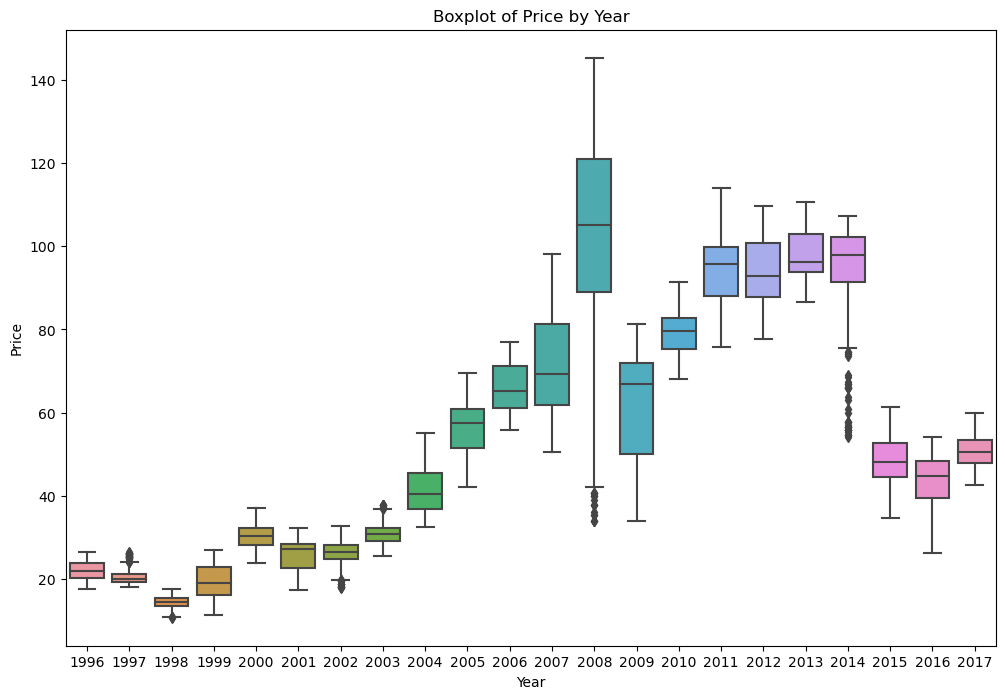

In [91]:
plt.figure(figsize=(12,8))
data['Date'] = pd.to_datetime(data['Date'])

data['Year'] = data['Date'].dt.year

# Generate box plots for each year
sns.boxplot(data=data, x='Year', y='Price')

# Treat outliers using winsorization
q1 = data['Price'].quantile(0.25)
q3 = data['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data['Price'] = data['Price'].clip(lower=lower_bound, upper=upper_bound)

plt.title('Boxplot of Price by Year')
plt.xlabel('Year')
plt.ylabel('Price')
plt.show()

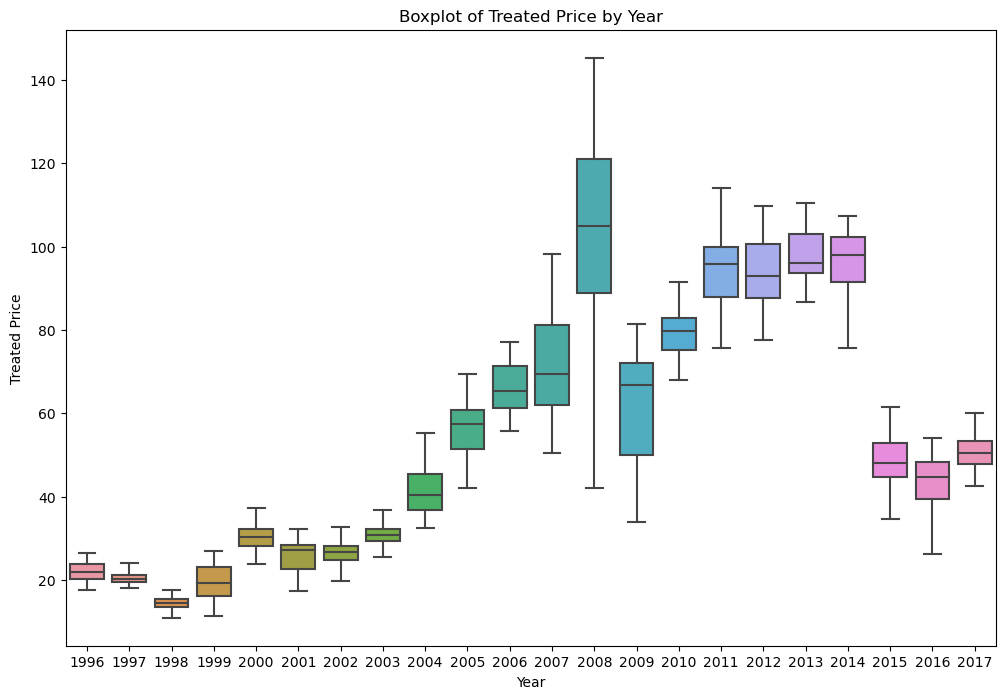

In [92]:
# Treat outliers using IQR method
plt.figure(figsize=(12,8))
q1 = data['Price'].quantile(0.25)
q3 = data['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

data['Treated_Price'] = data['Price'].clip(lower=lower_bound, upper=upper_bound)

# Generate box plot of treated data
sns.boxplot(data=data, x='Year', y='Treated_Price', showfliers=False)

# Set the title and labels for the plot
plt.title('Boxplot of Treated Price by Year')
plt.xlabel('Year')
plt.ylabel('Treated Price')

# Show the plot
plt.show()


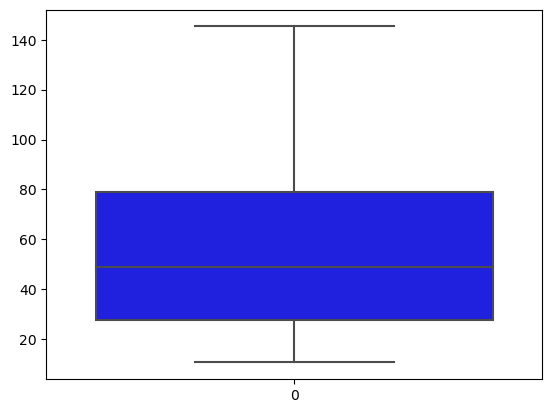

In [93]:
# Boxplot for overall price
sns.boxplot(data=data['Treated_Price'],color='blue')
plt.show()

Price colunm is slightly right skewed with majority of data is in range of 35 to 80 with median value is 54 Rs

In [94]:
data.shape

(7392, 4)

In [95]:
data.head()

Date  Price  Year  Treated_Price
0 1996-01-01  19.55  1996          19.55
1 1996-01-02  19.81  1996          19.81
2 1996-01-03  19.89  1996          19.89
3 1996-01-04  19.91  1996          19.91
4 1996-01-05  20.26  1996          20.26

In [96]:
# Save column as Excel
data['Treated_Price'].to_excel('D:/Data Science/Projects/Oil_Price_Forecasting/OIL_PRICE_MY_FILE/column_data.xlsx', index=False)

### Upsampling(Average method)
       # only for visualization purpous
        converting Days into months

In [97]:
# to set Date column name as index 
df.set_index('Date',inplace=True)

In [98]:
resample = df.resample('M')
df_visu = resample.mean()
df_visu

Price
Date                 
1996-01-31  18.933214
1996-02-29  18.673929
1996-03-31  21.047500
1996-04-30  23.390714
1996-05-31  21.185000
...               ...
2017-08-31  48.402143
2017-09-30  49.426786
2017-10-31  51.305000
2017-11-30  56.762857
2017-12-31  57.860357

[264 rows x 1 columns]

### Line plot

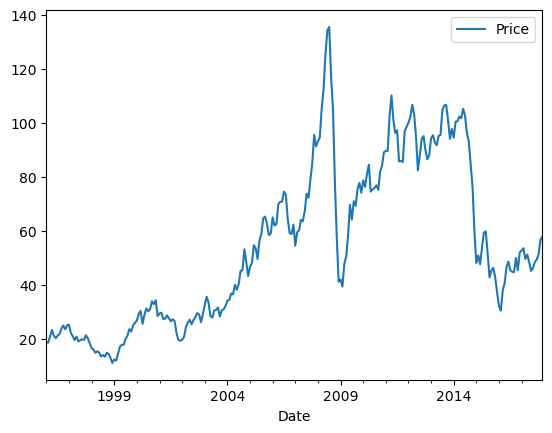

In [99]:
df_visu.plot()
plt.show()

It shows dataset has Polynomial trend with non seasonal

### Histogram and Density Plots of target column

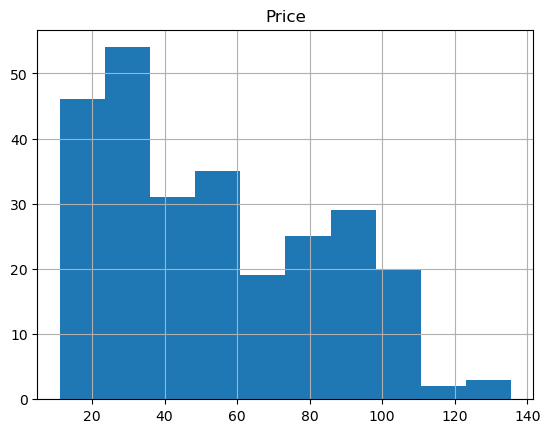

In [100]:
# target should be normally distributed if not ten treat it
df_visu.hist()
plt.show()

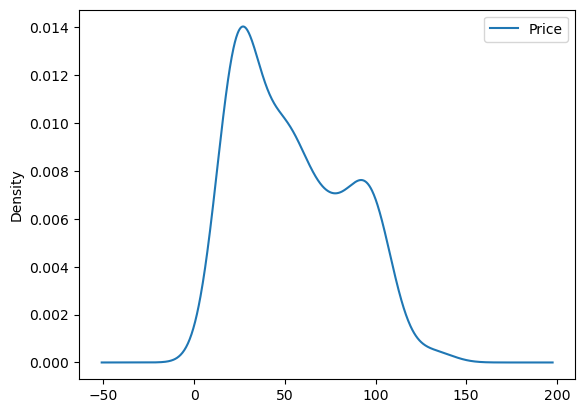

In [101]:
# create a density plot
df_visu.plot(kind='kde')
plt.show()


Price column is slightly Right skewed.

Price have average value between 54 and standard deviation is in range of 20-80.

In [102]:
df_visu.skew()

Price    0.480807
dtype: float64

Generally, skewness values if within -0.5 to 0.5 then said distribution can be considered Normally skewed distribution and within this range, it can be also considered as approximately normally distributed.

### Lag plot

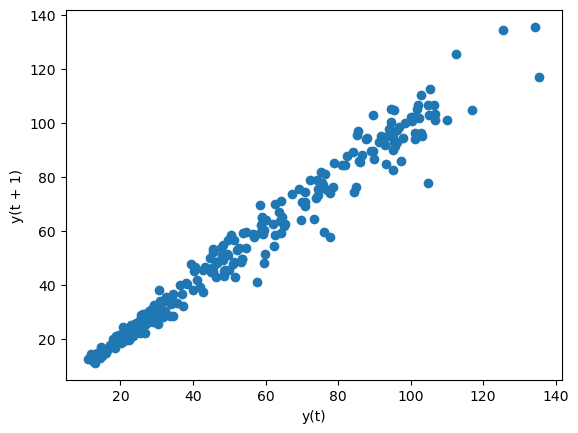

In [103]:
# lagplot-it is scatterplot between target Vs target with 1 delay(lag)
lag_plot(df_visu)
plt.show()

from above lag plot it shows that,feature and target are highly positively correlated with each other,That means Forecasting for Prices are possible

### Moving Average

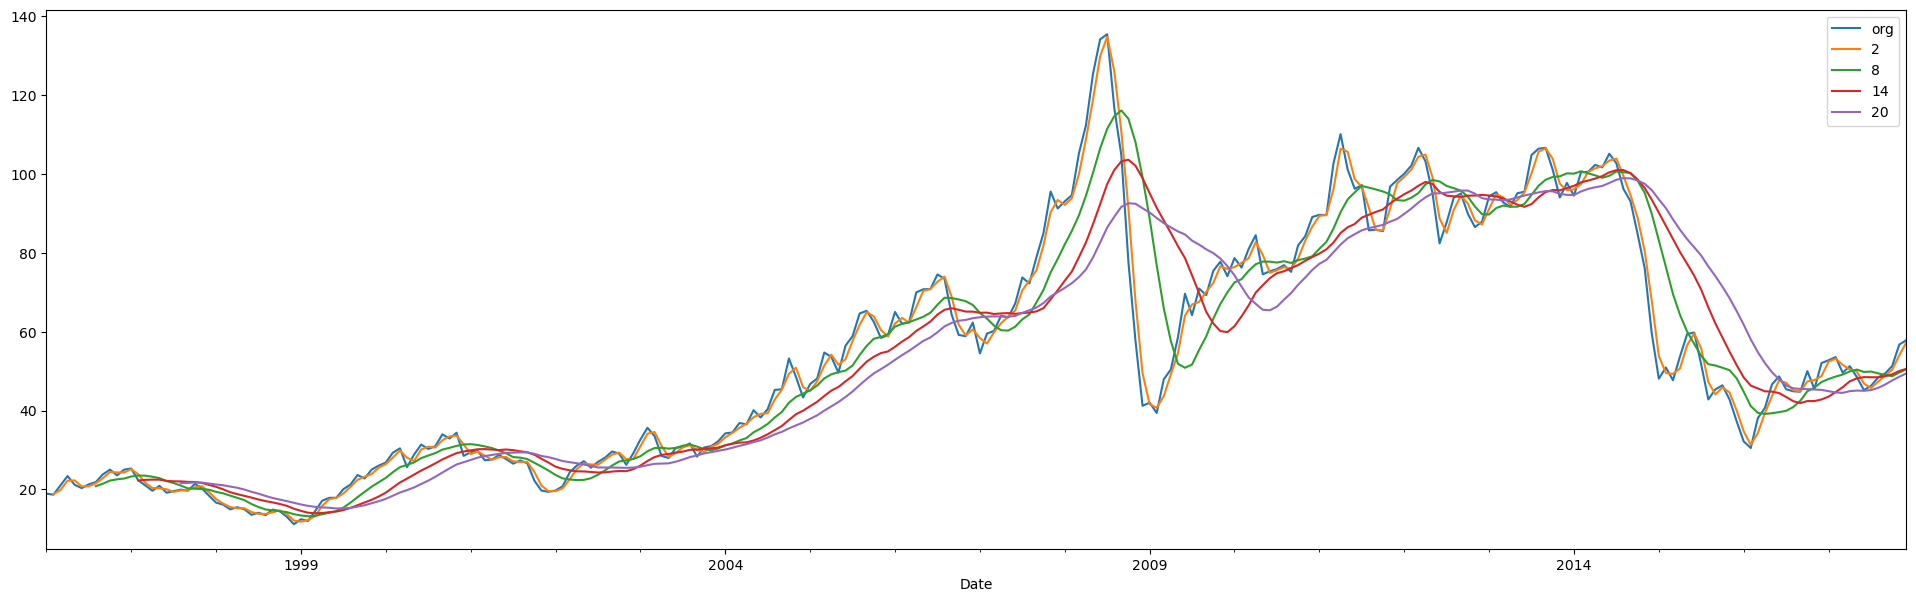

In [104]:
plt.figure(figsize=(24,7))
df_visu['Price'].plot(label="org")
for i in range(2,24,6):
    #plt.figure(figsize=(24,7))
    df_visu['Price'].rolling(i).mean().plot(label=str(i))
    #plt.title("MA"+str(i))
plt.legend(loc='best')
plt.show()

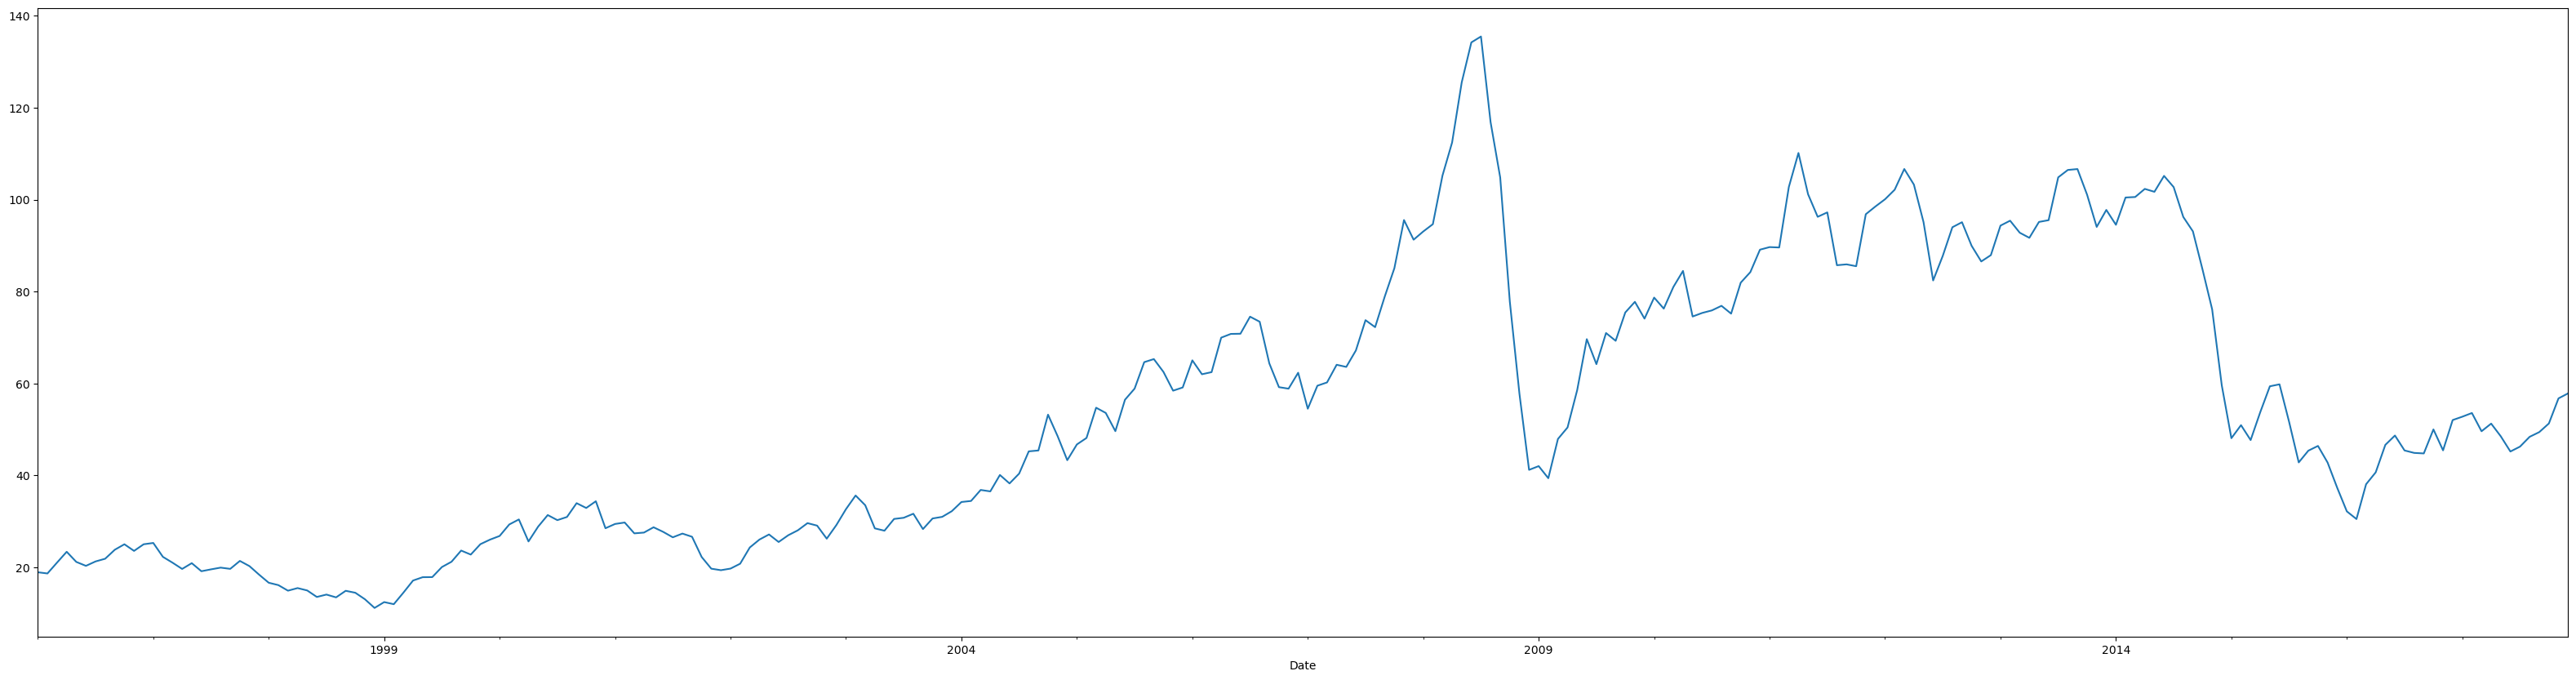

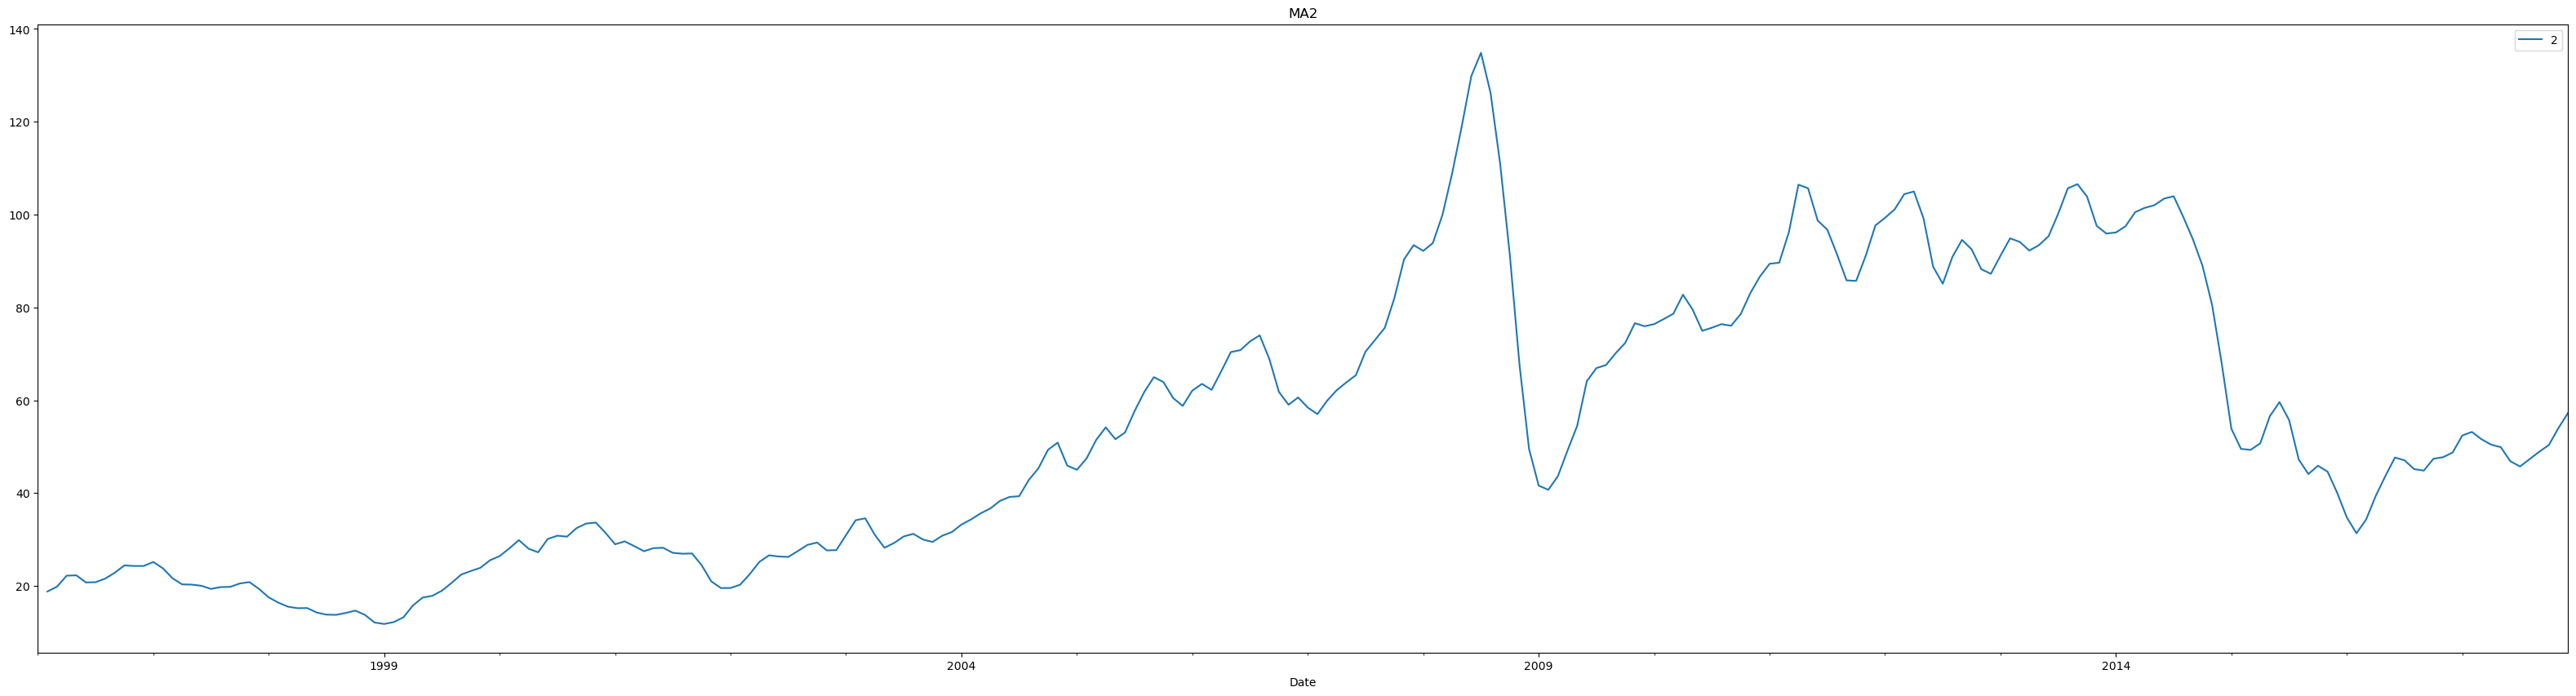

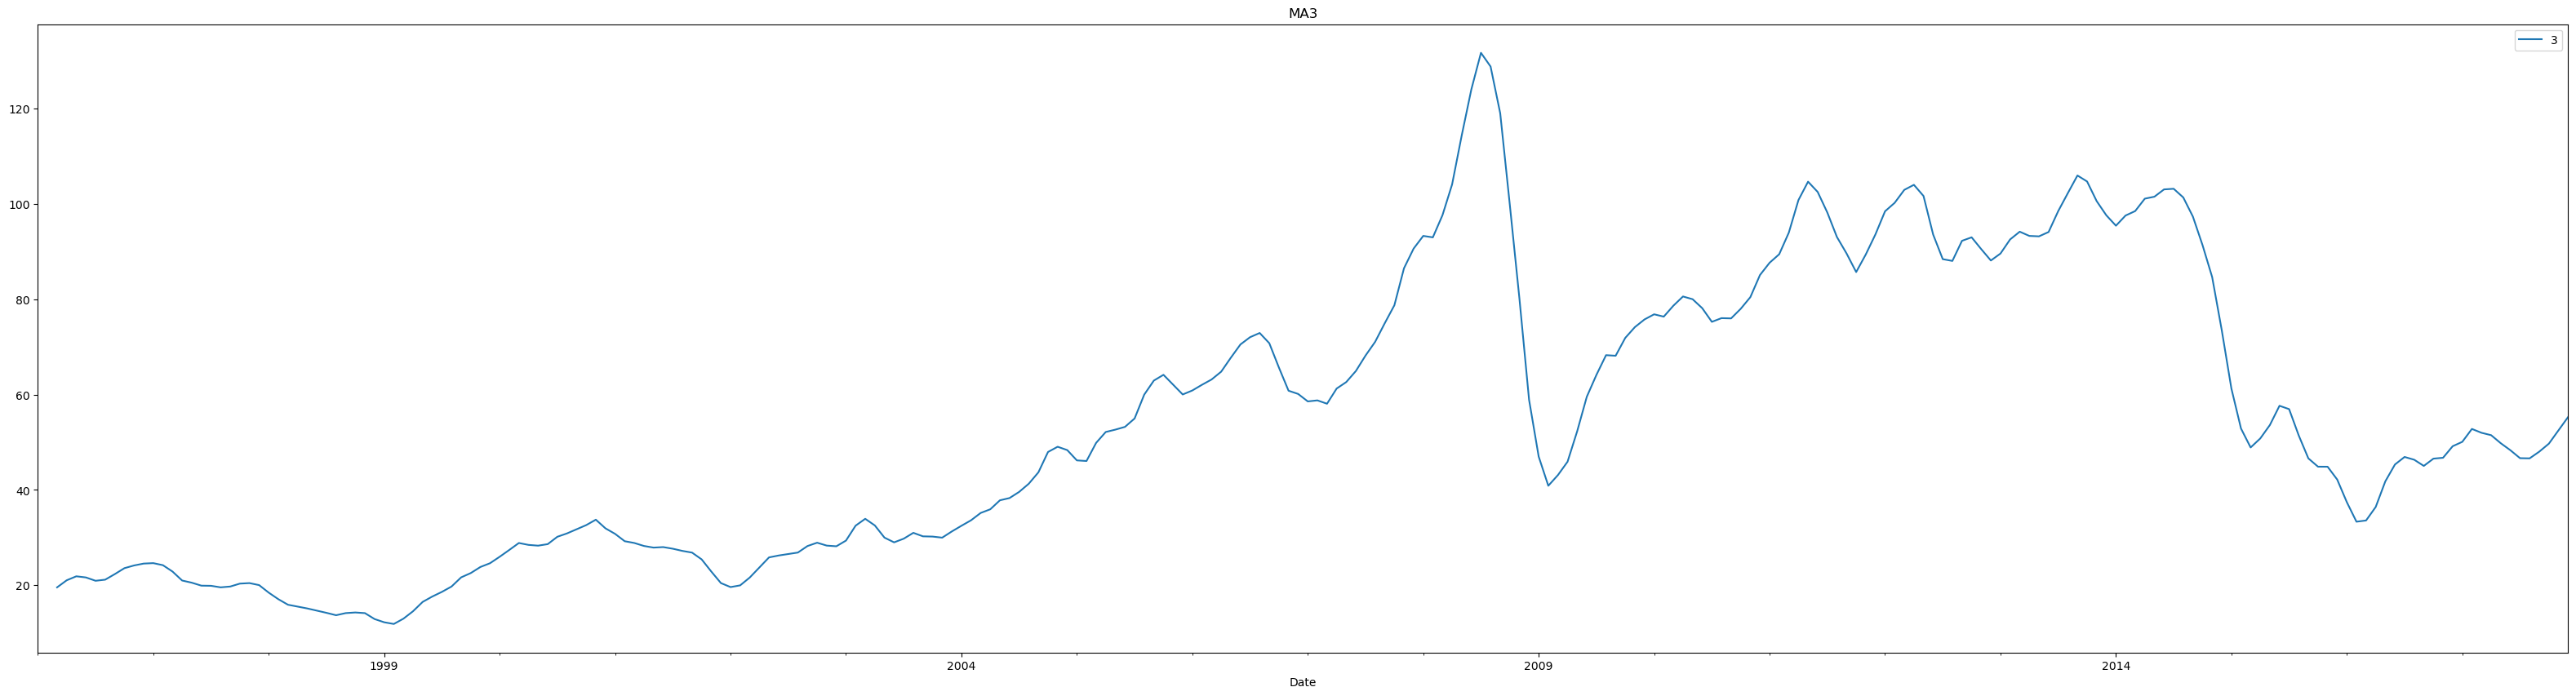

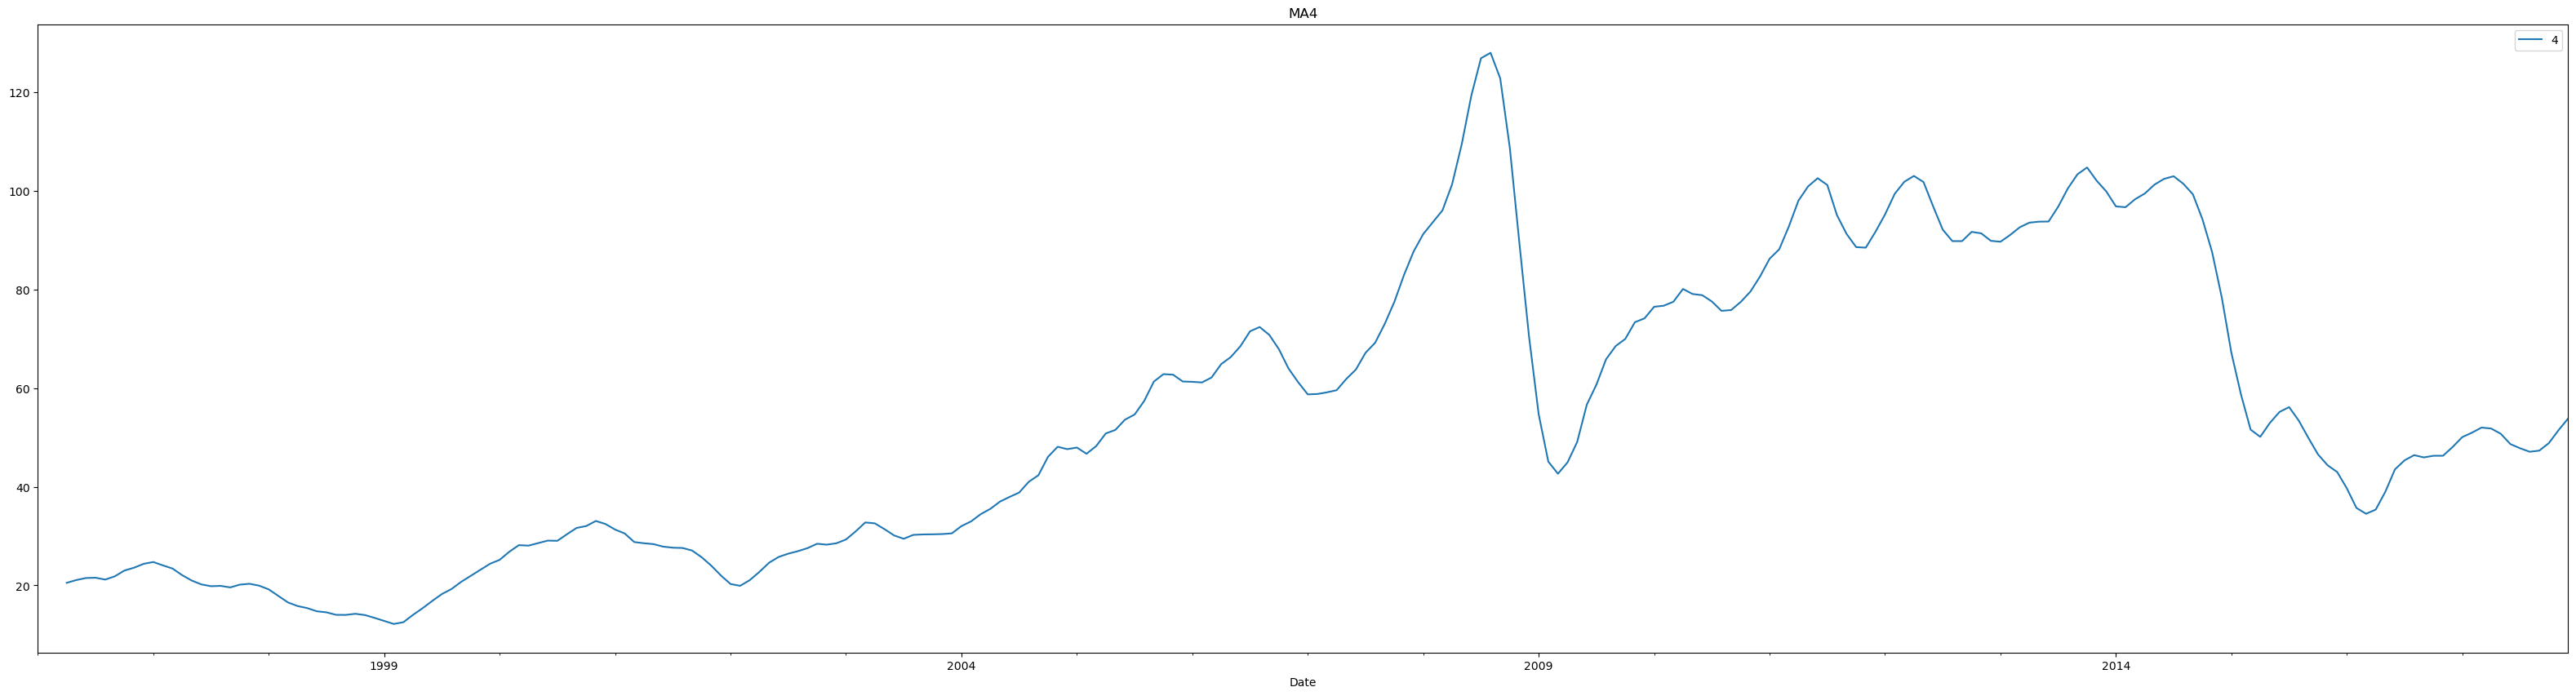

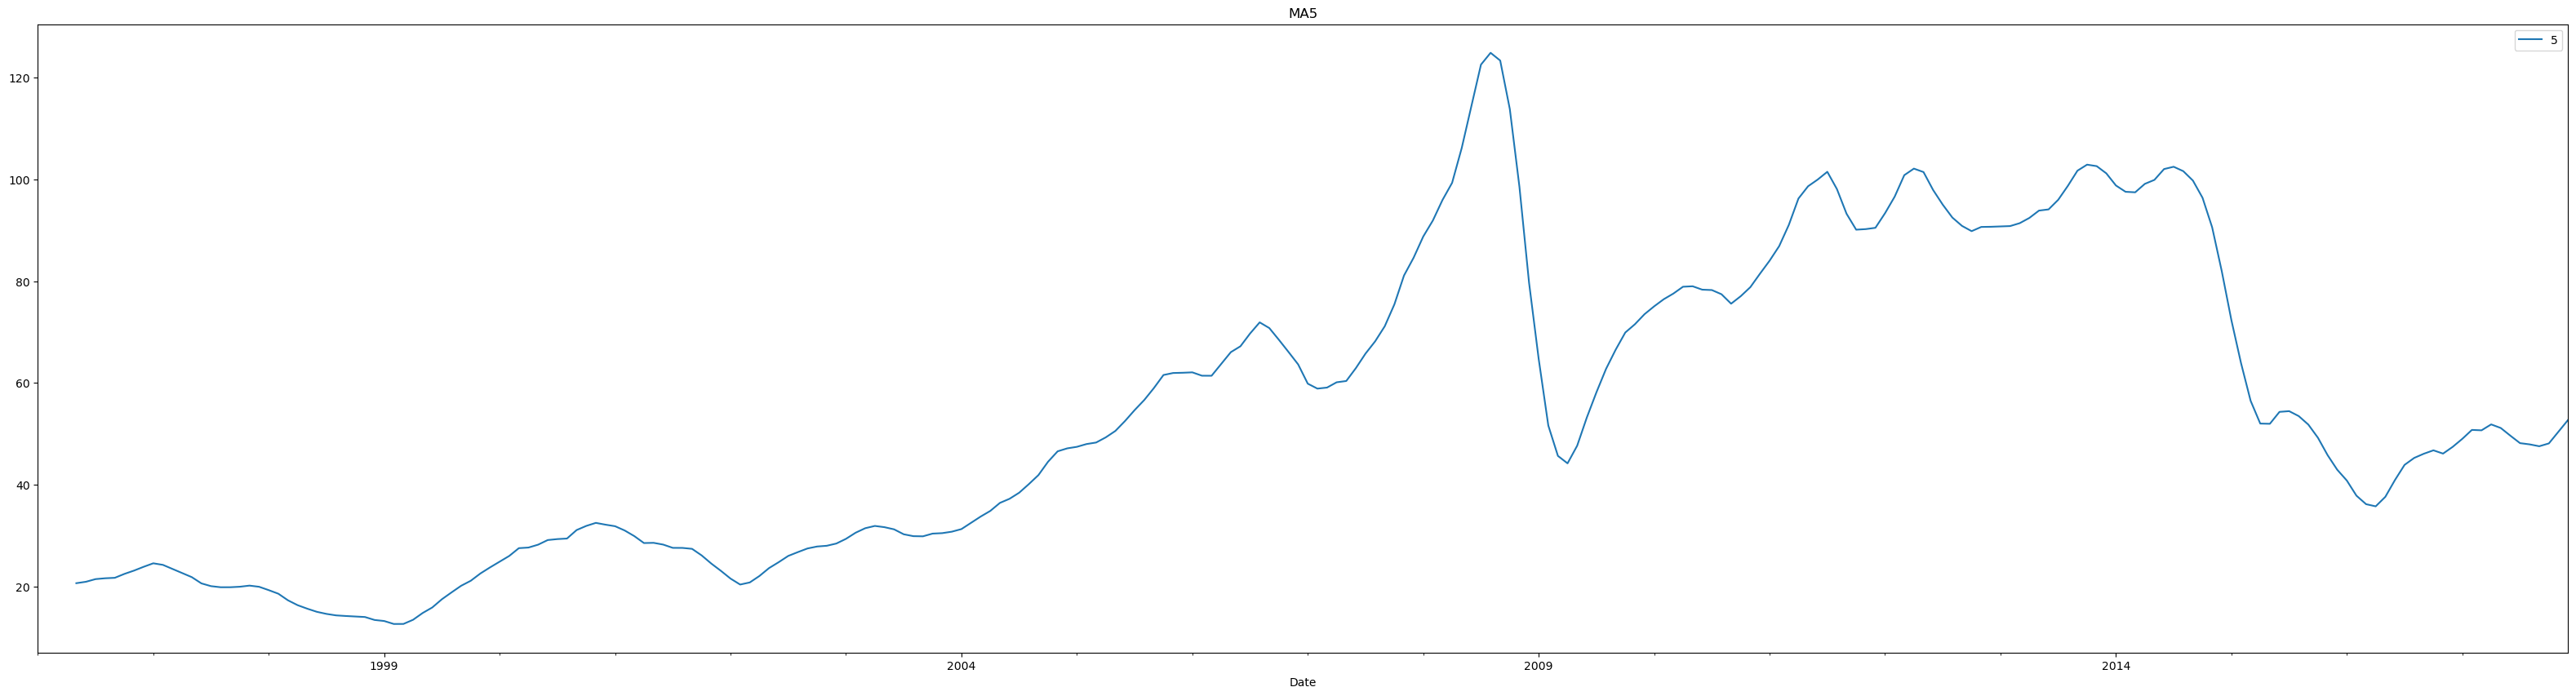

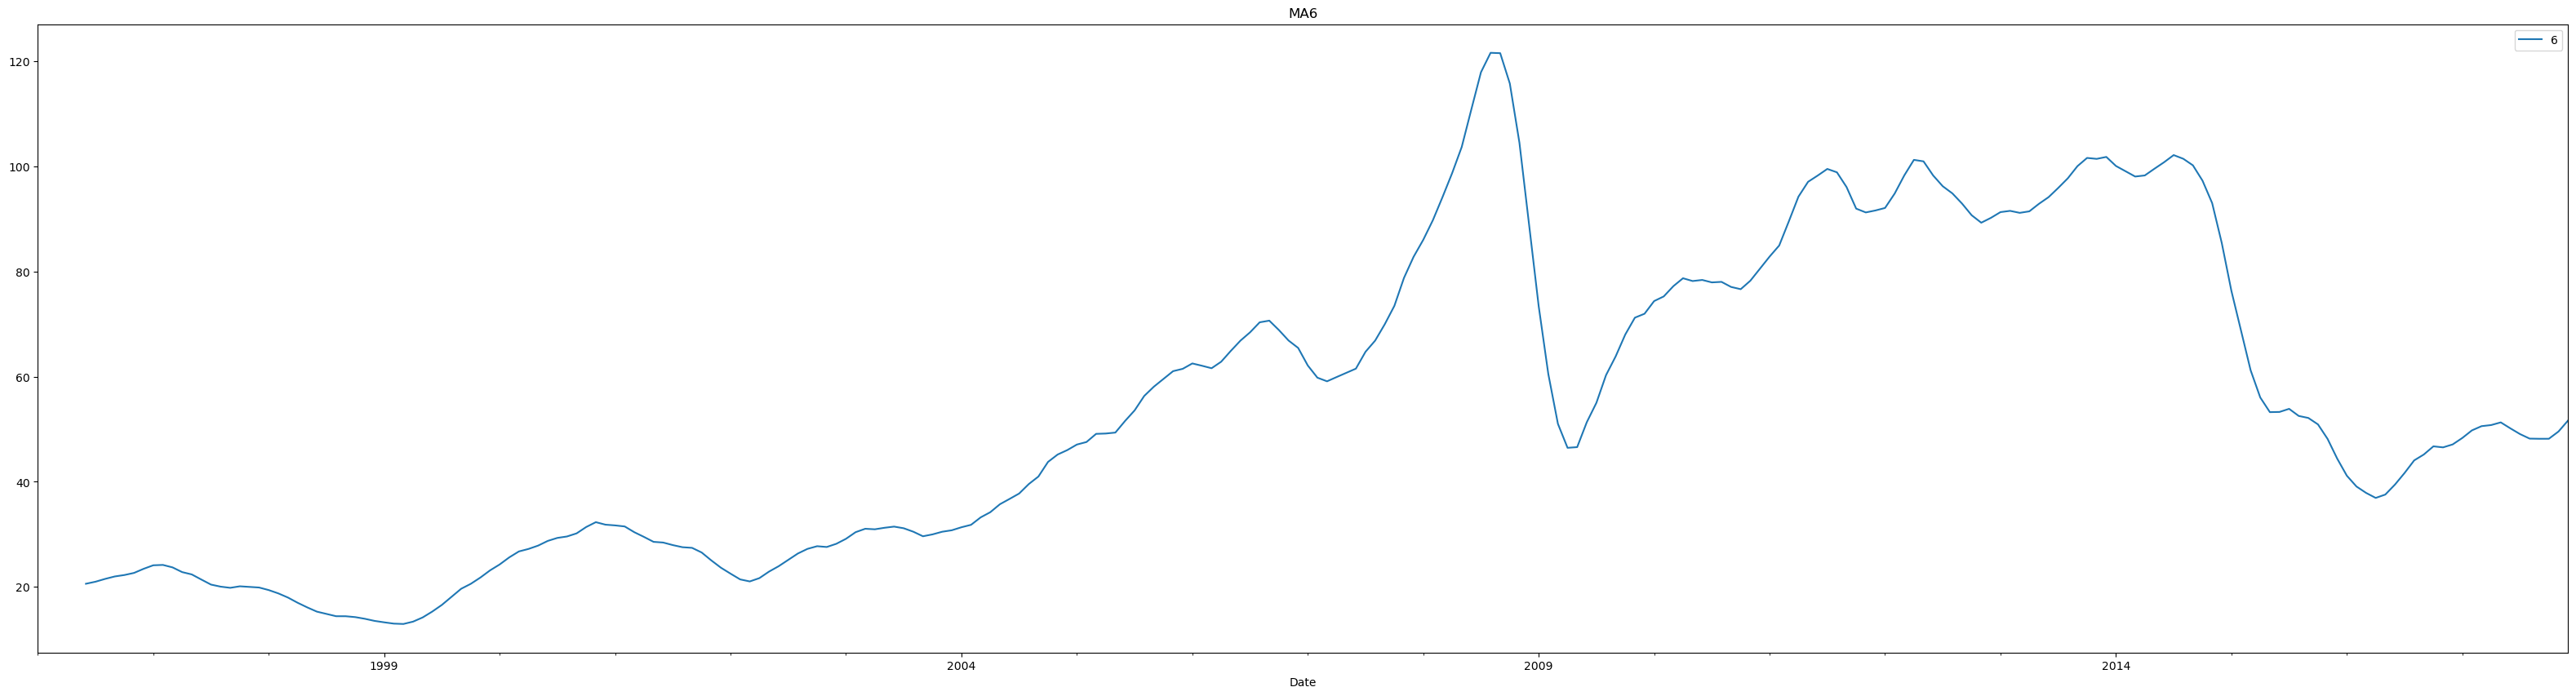

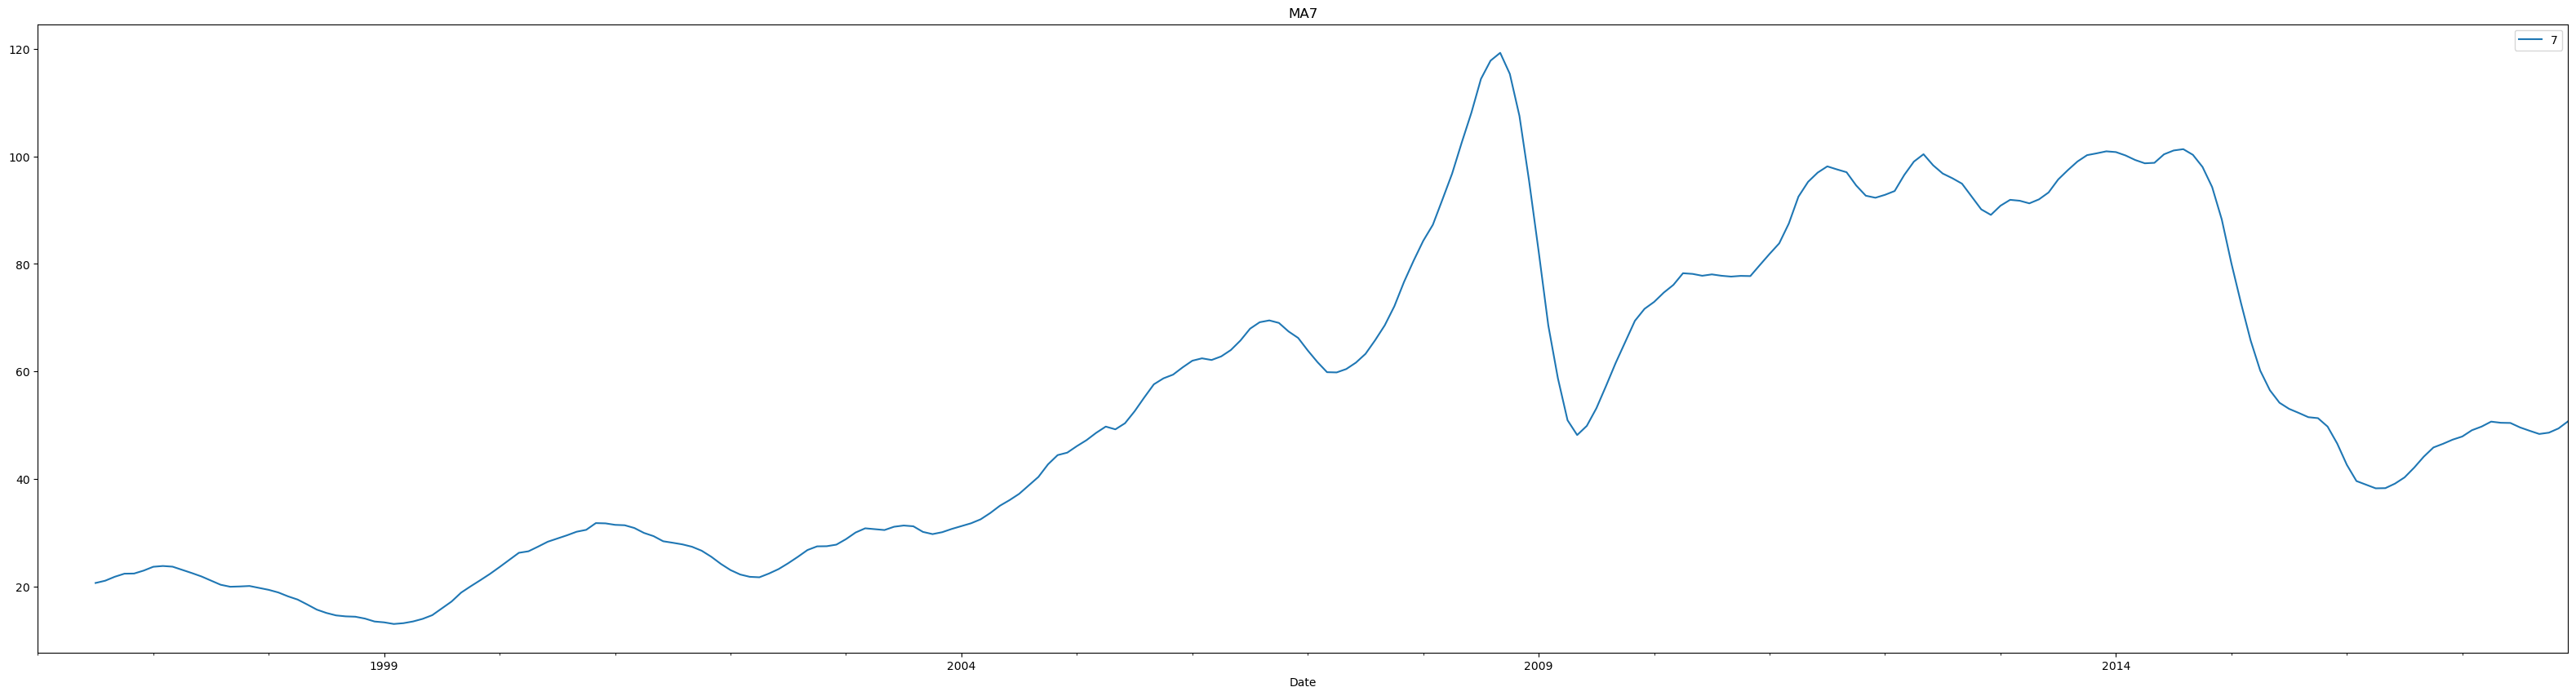

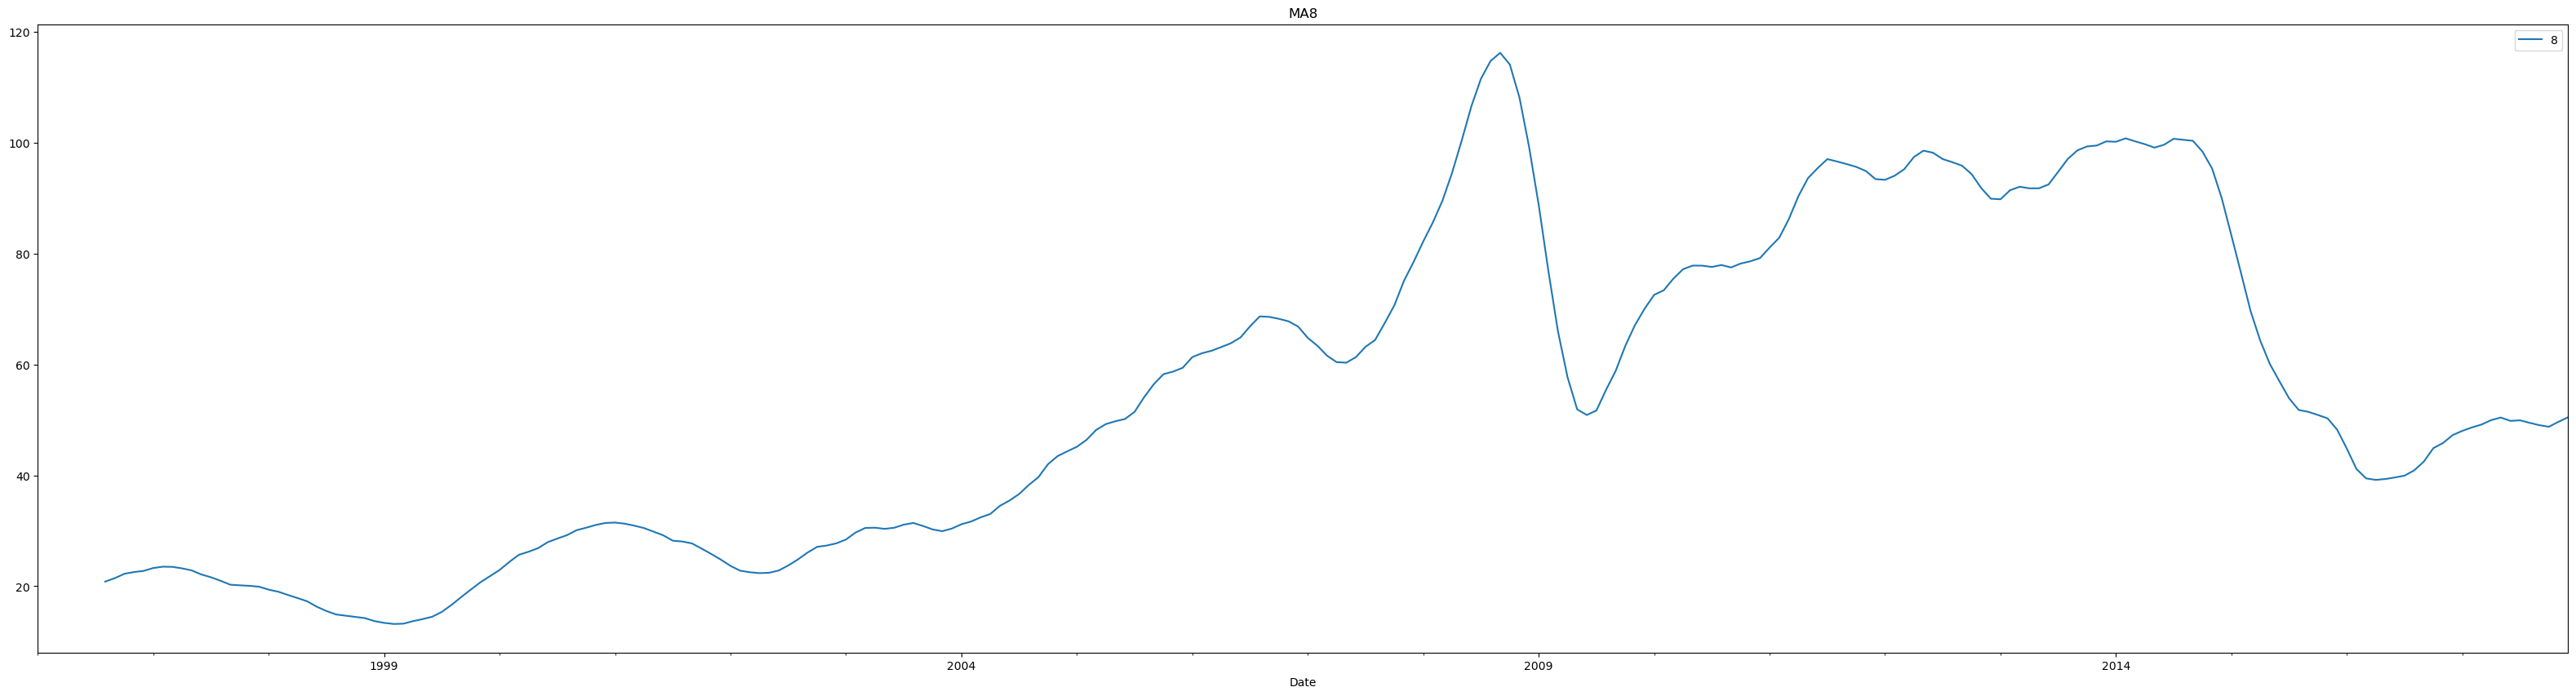

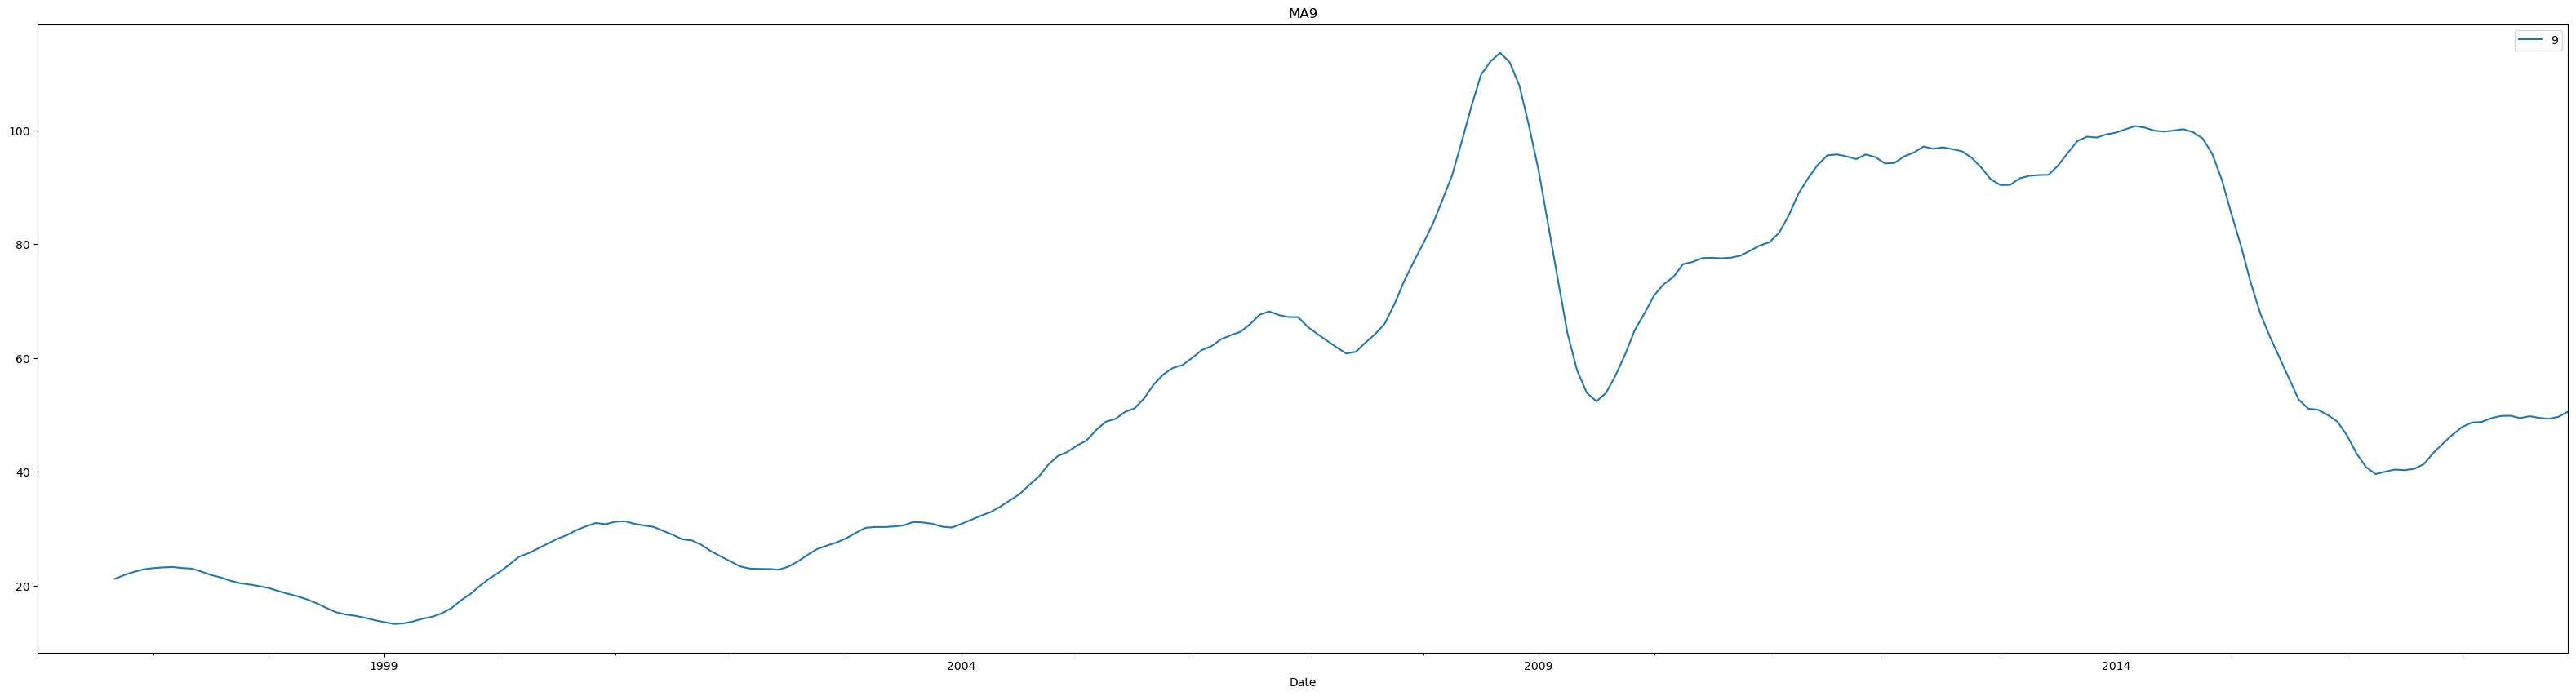

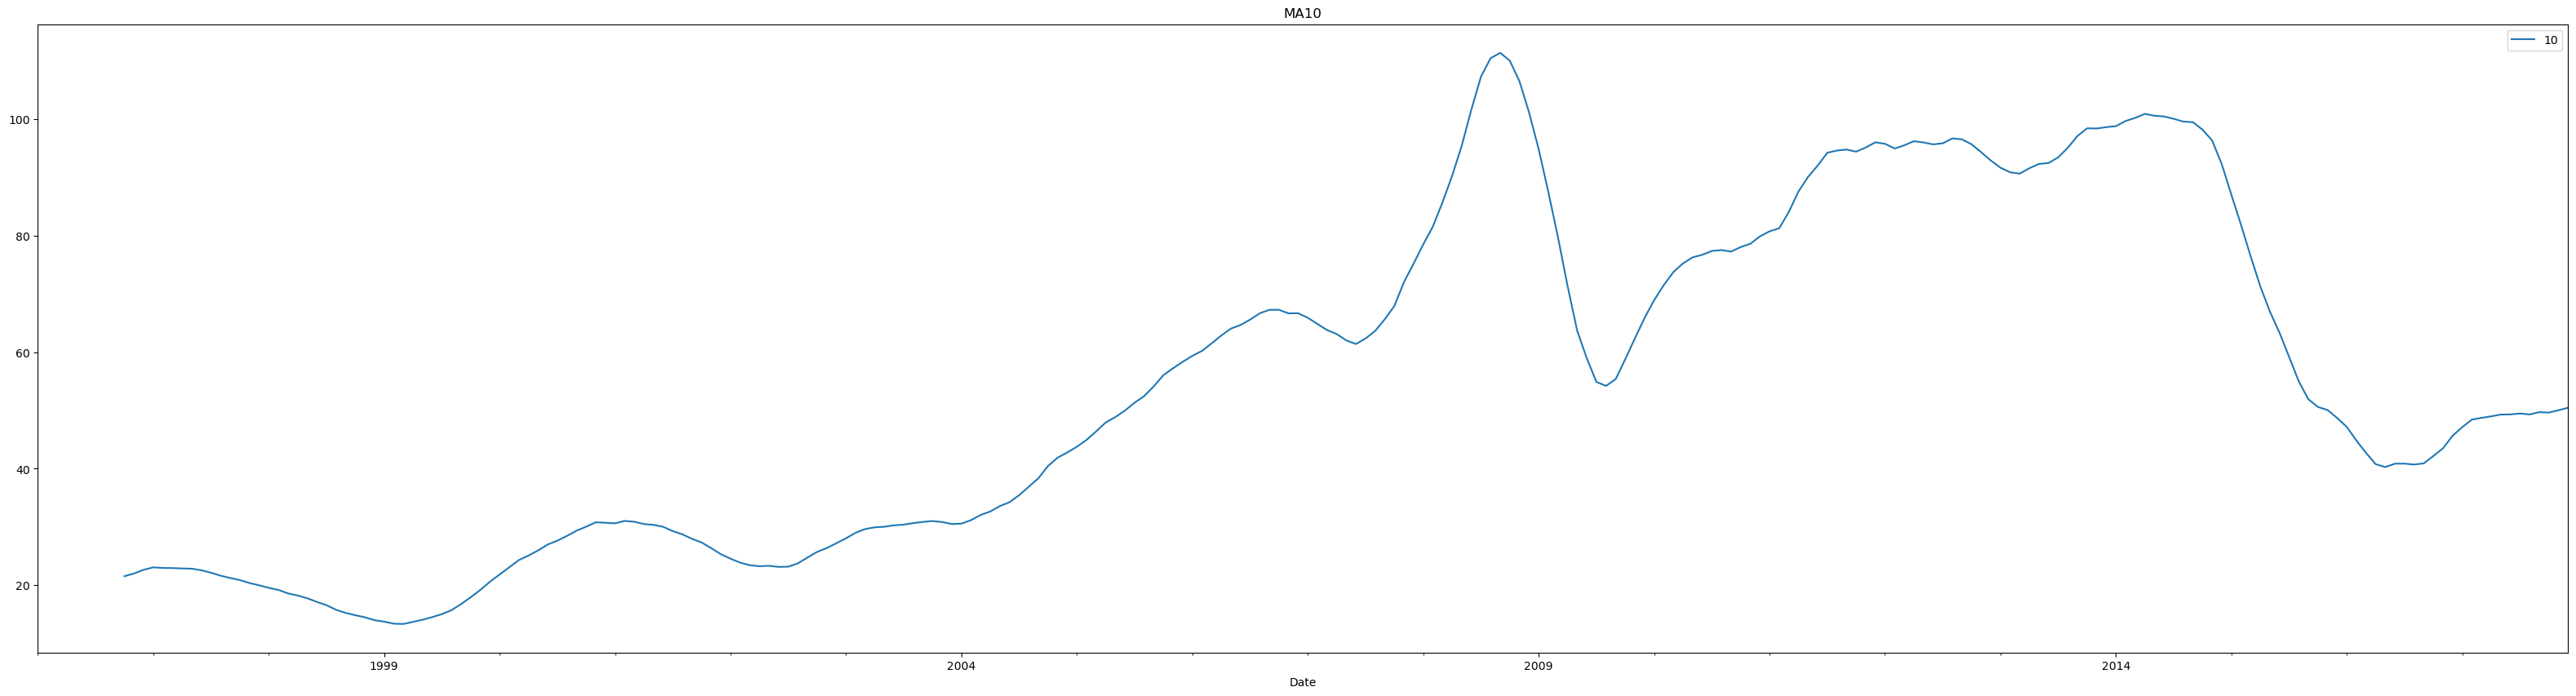

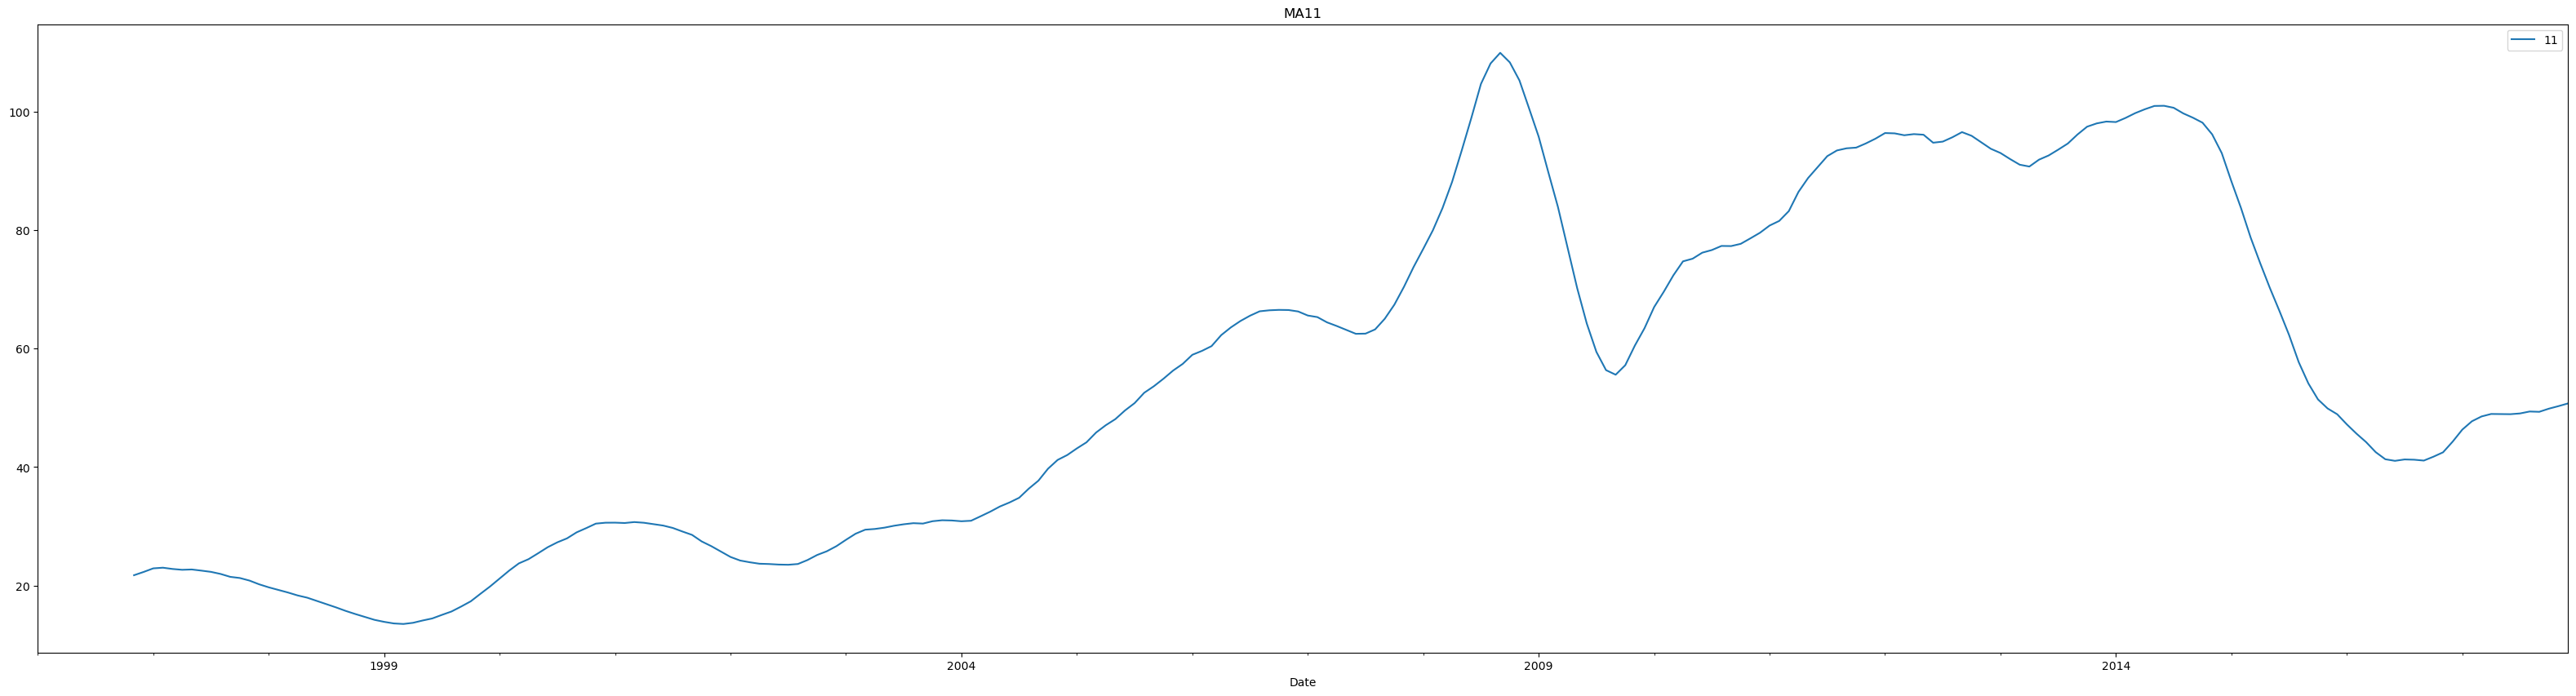

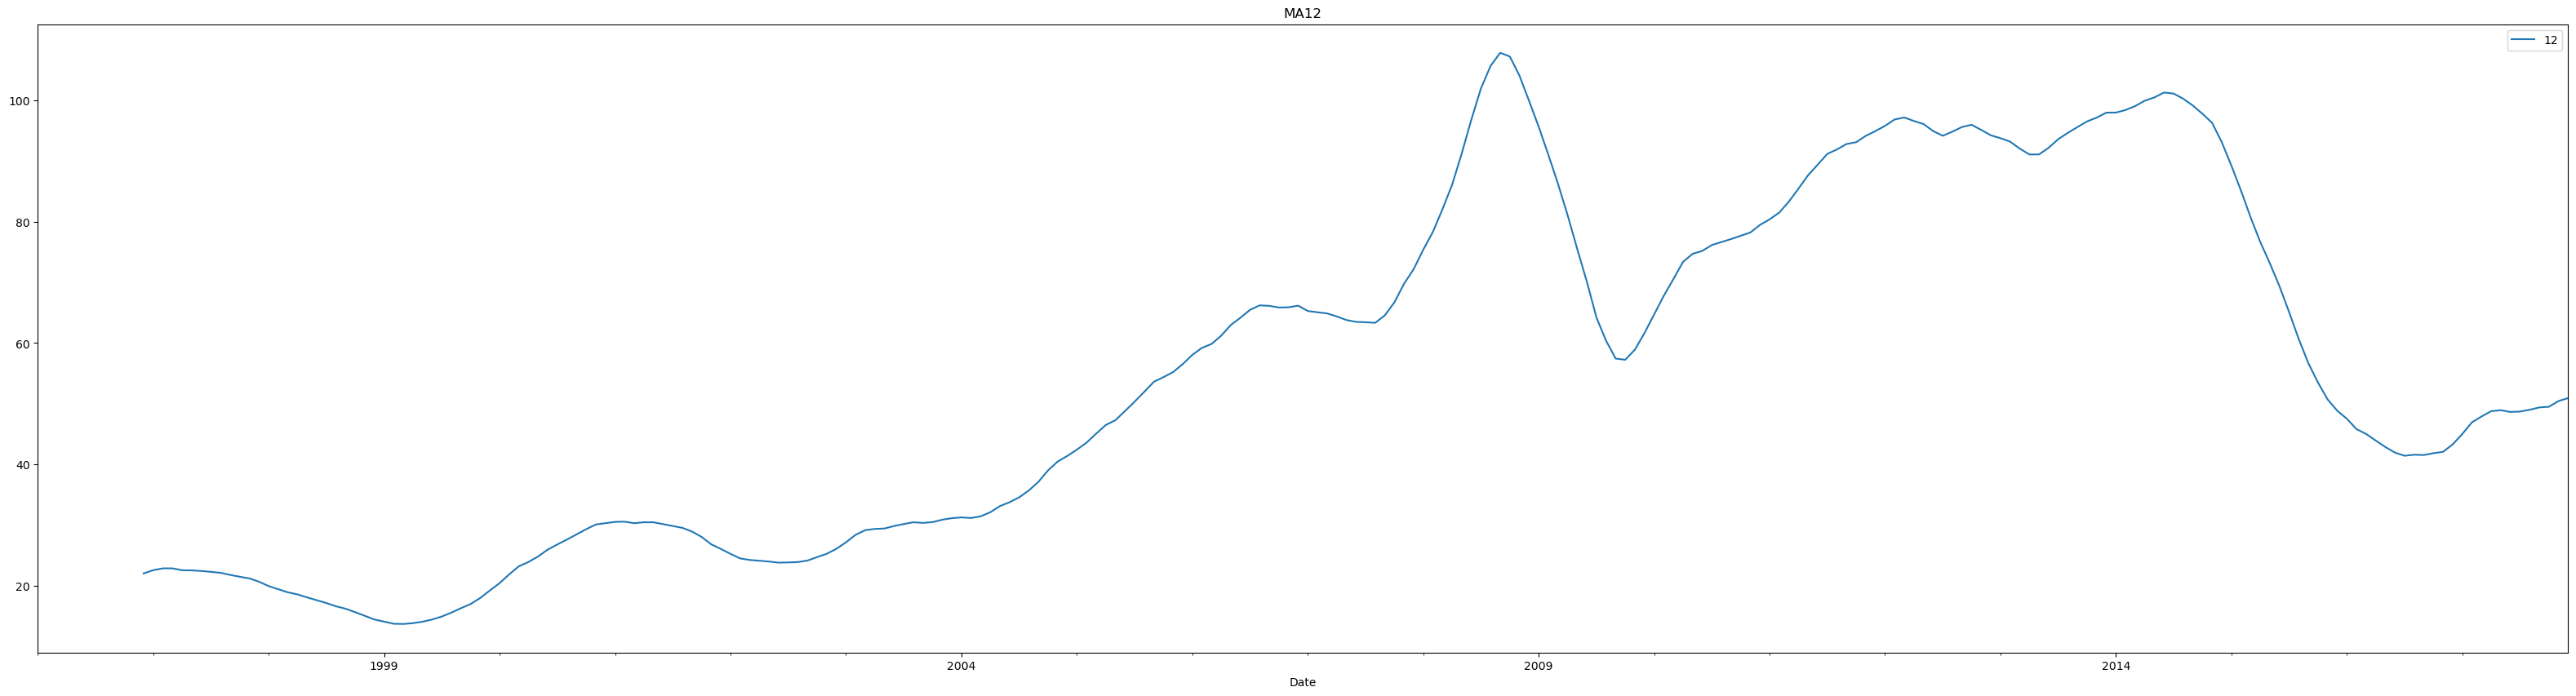

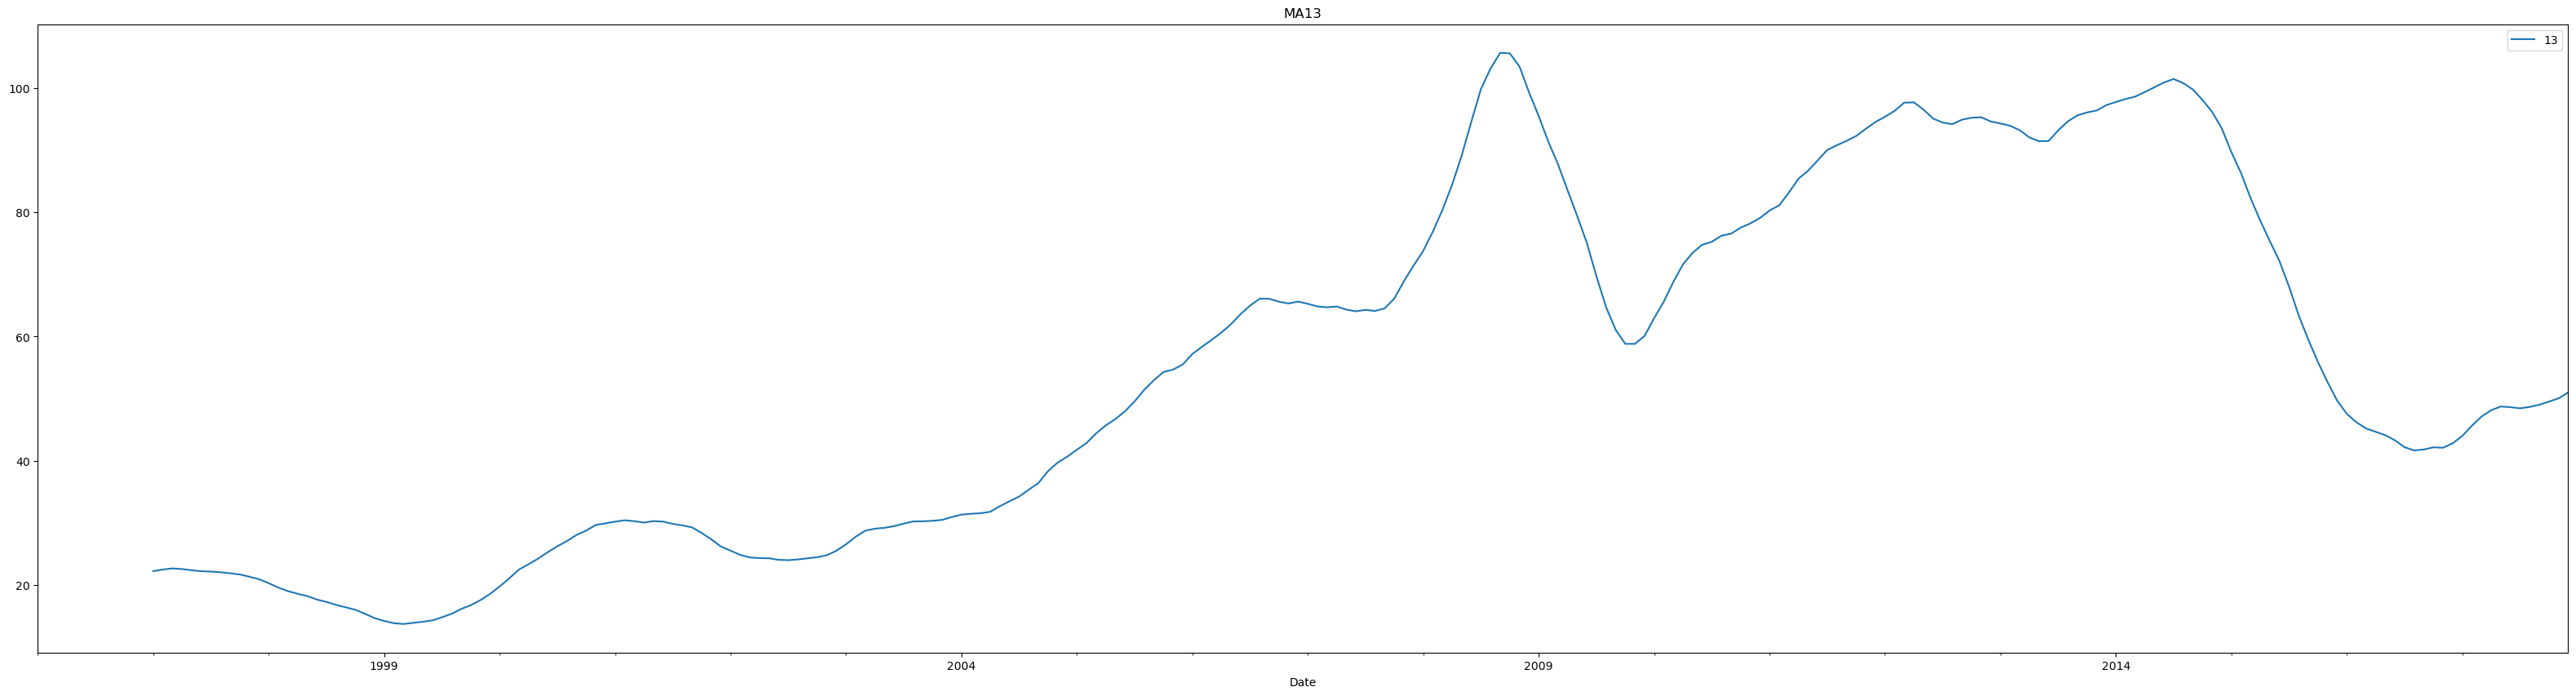

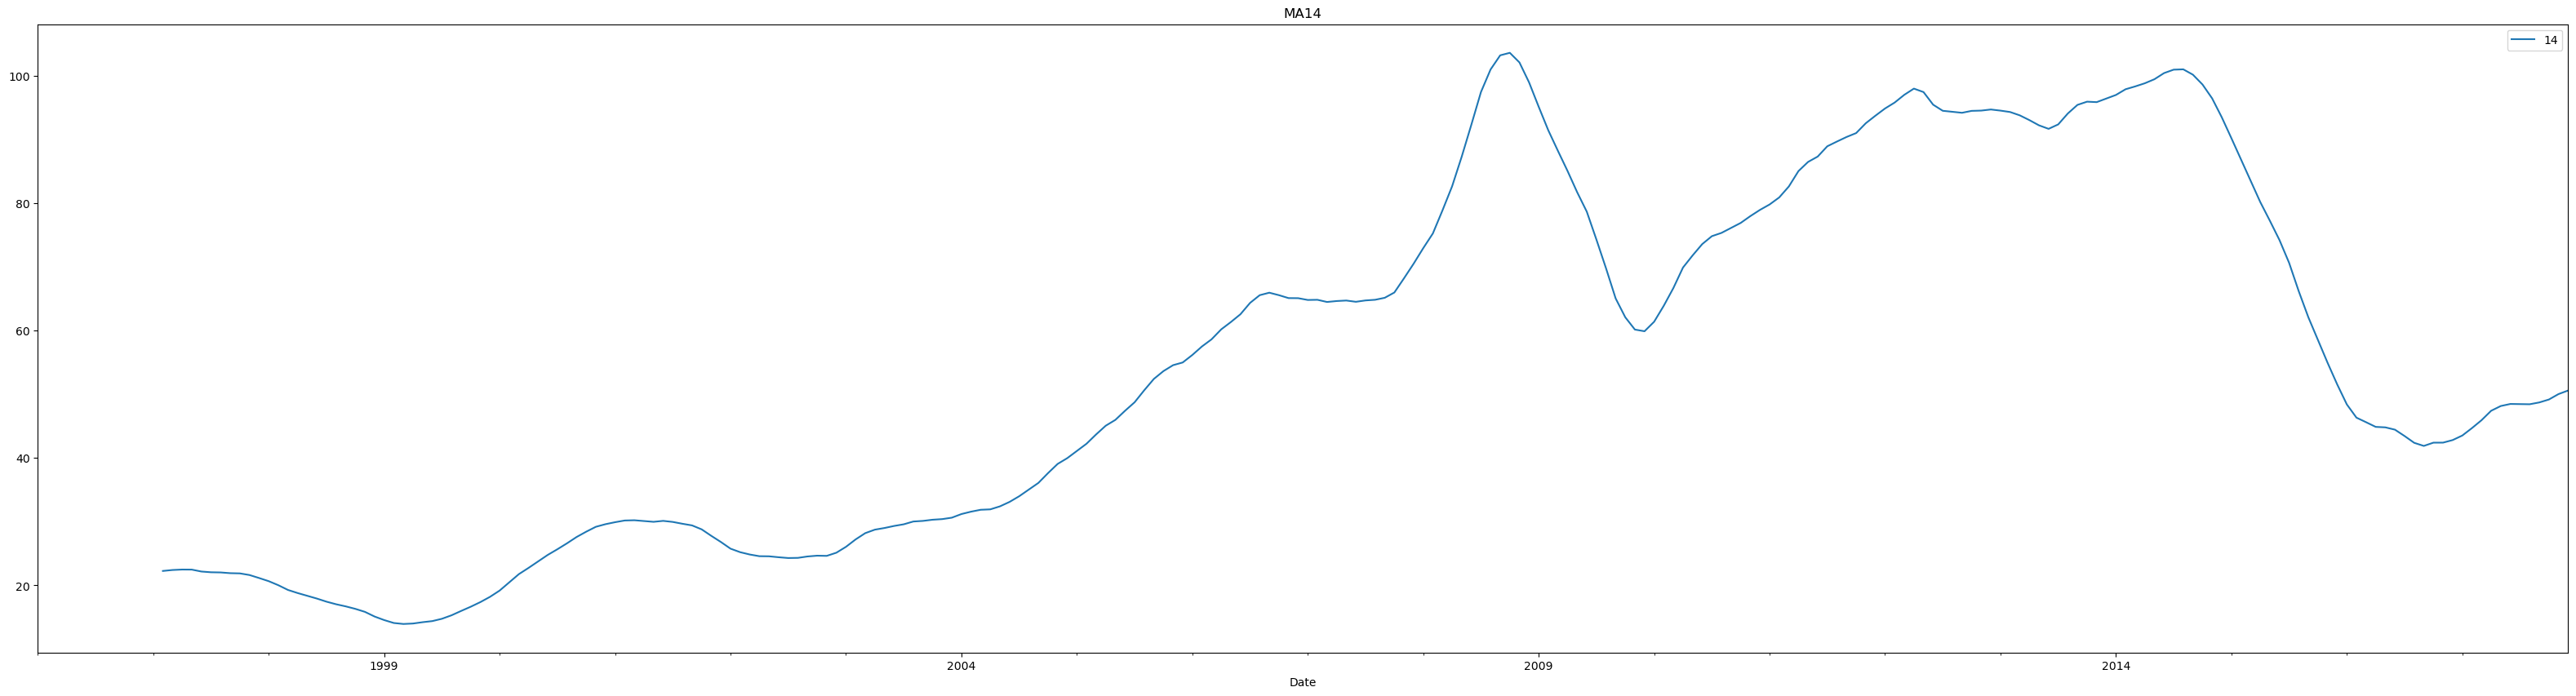

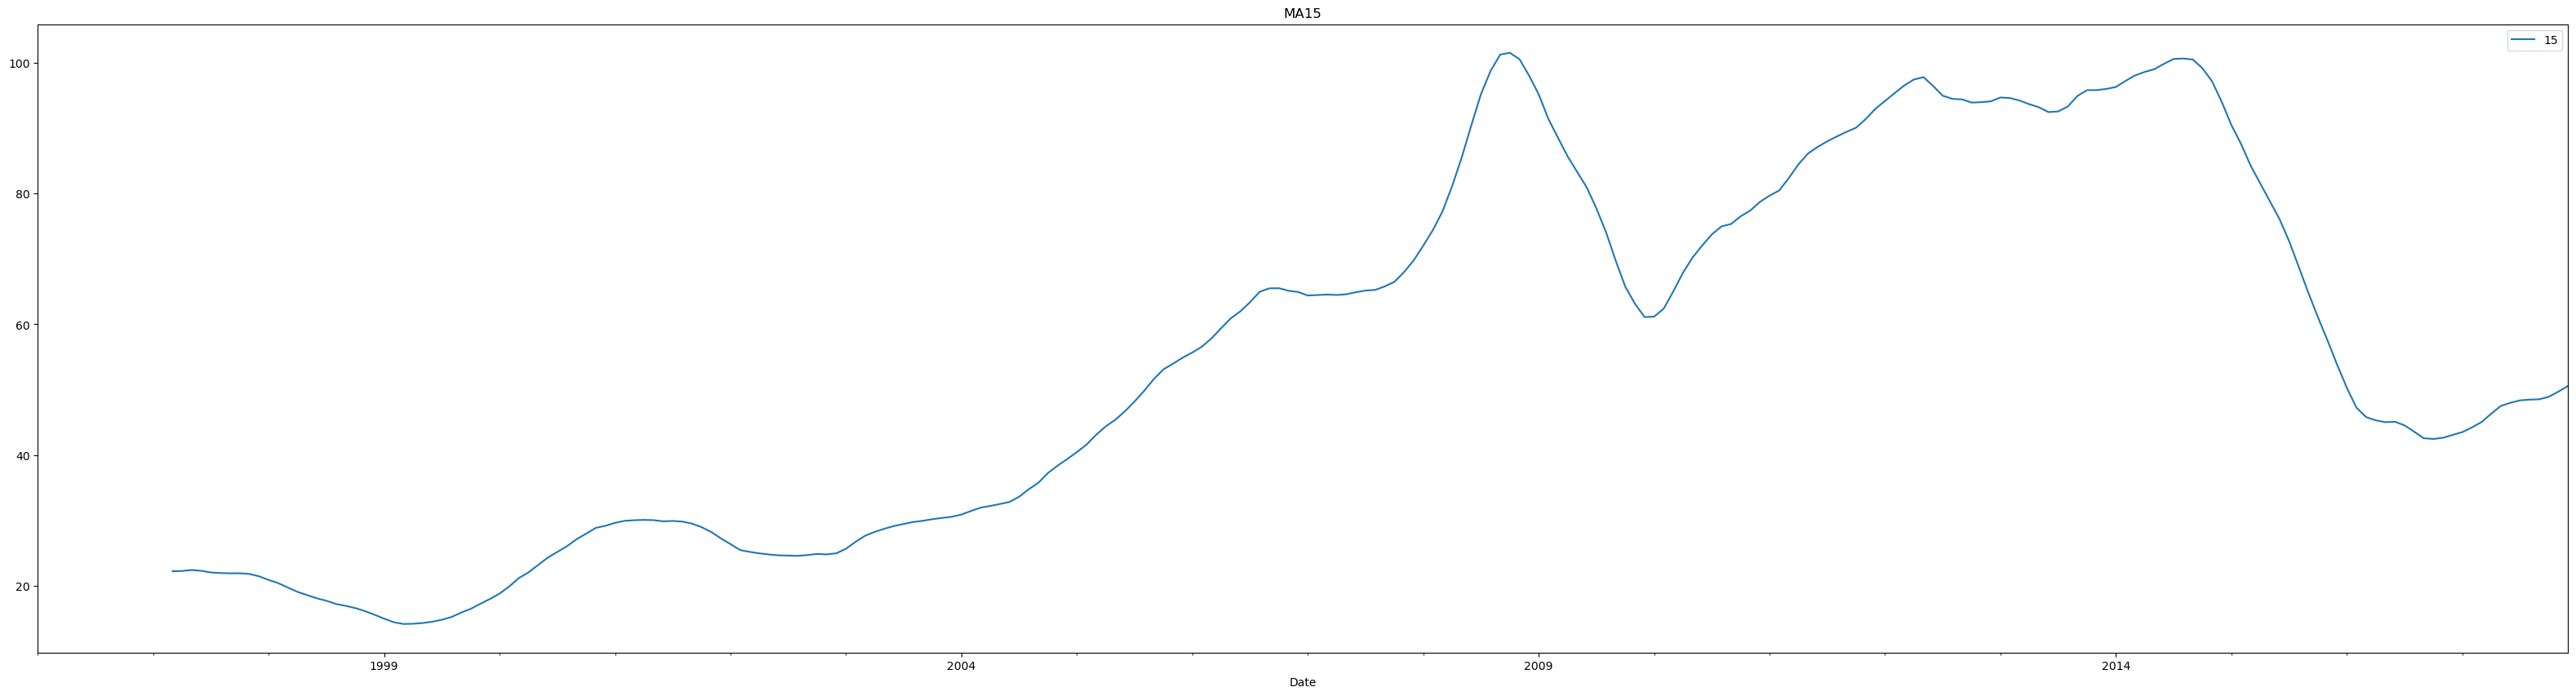

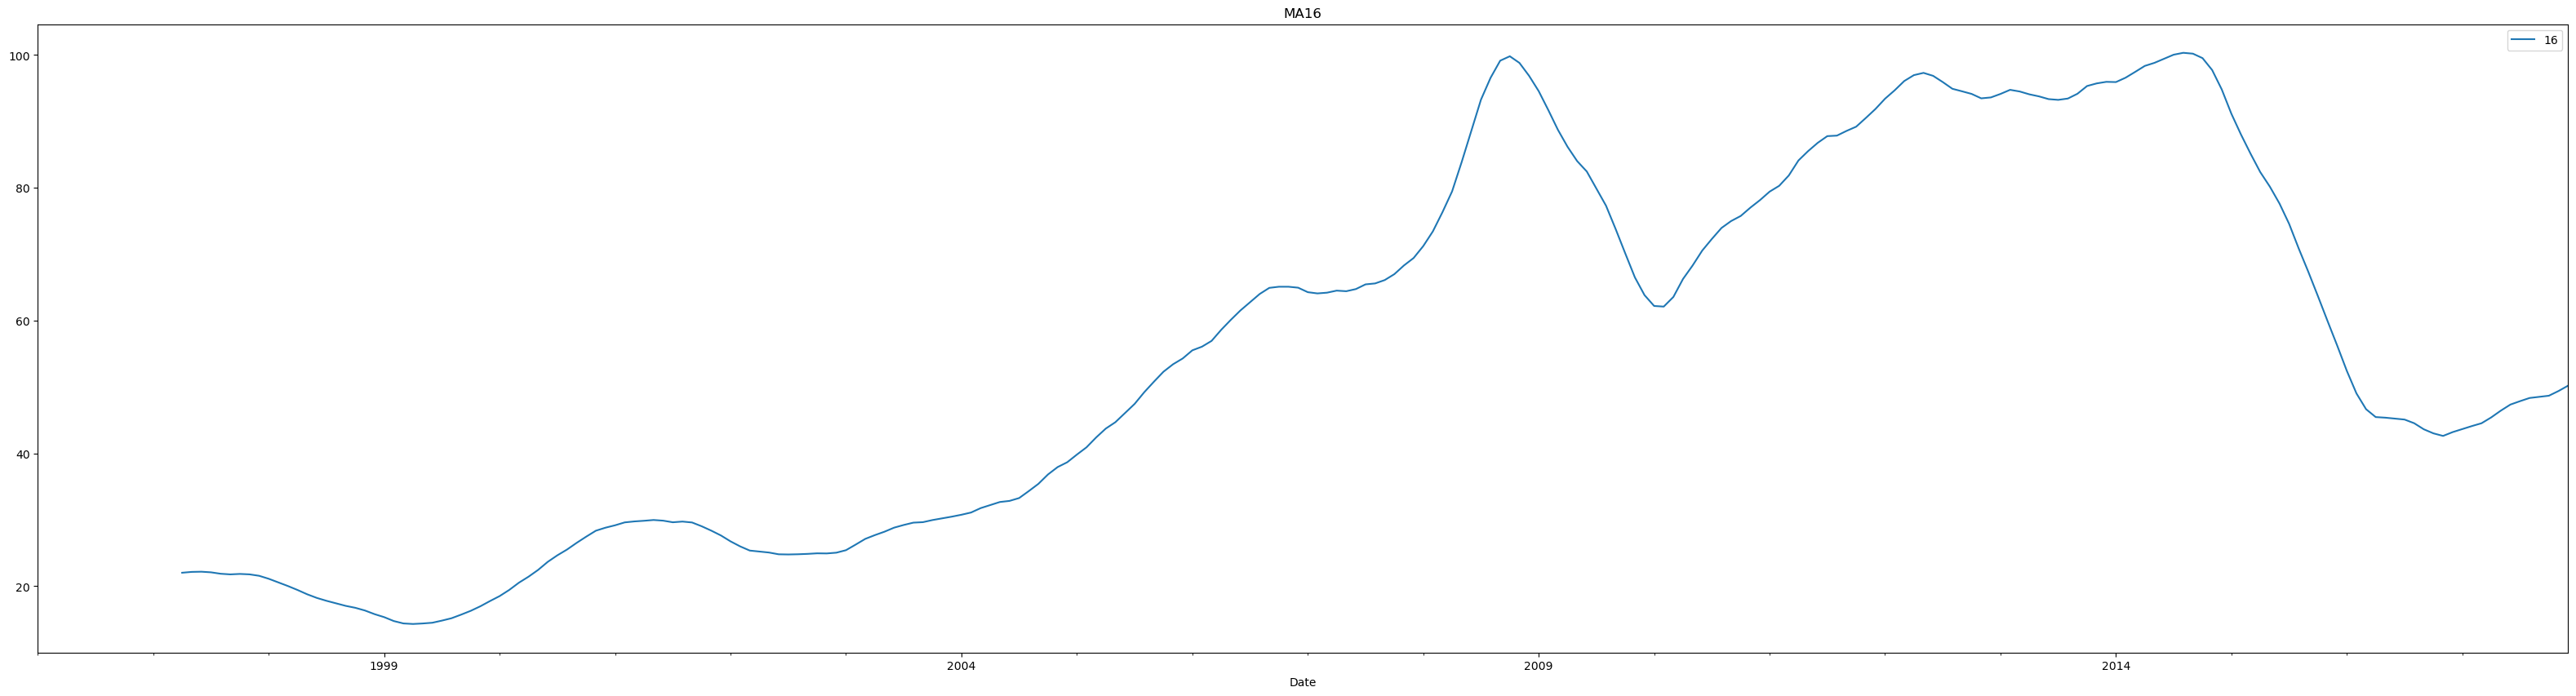

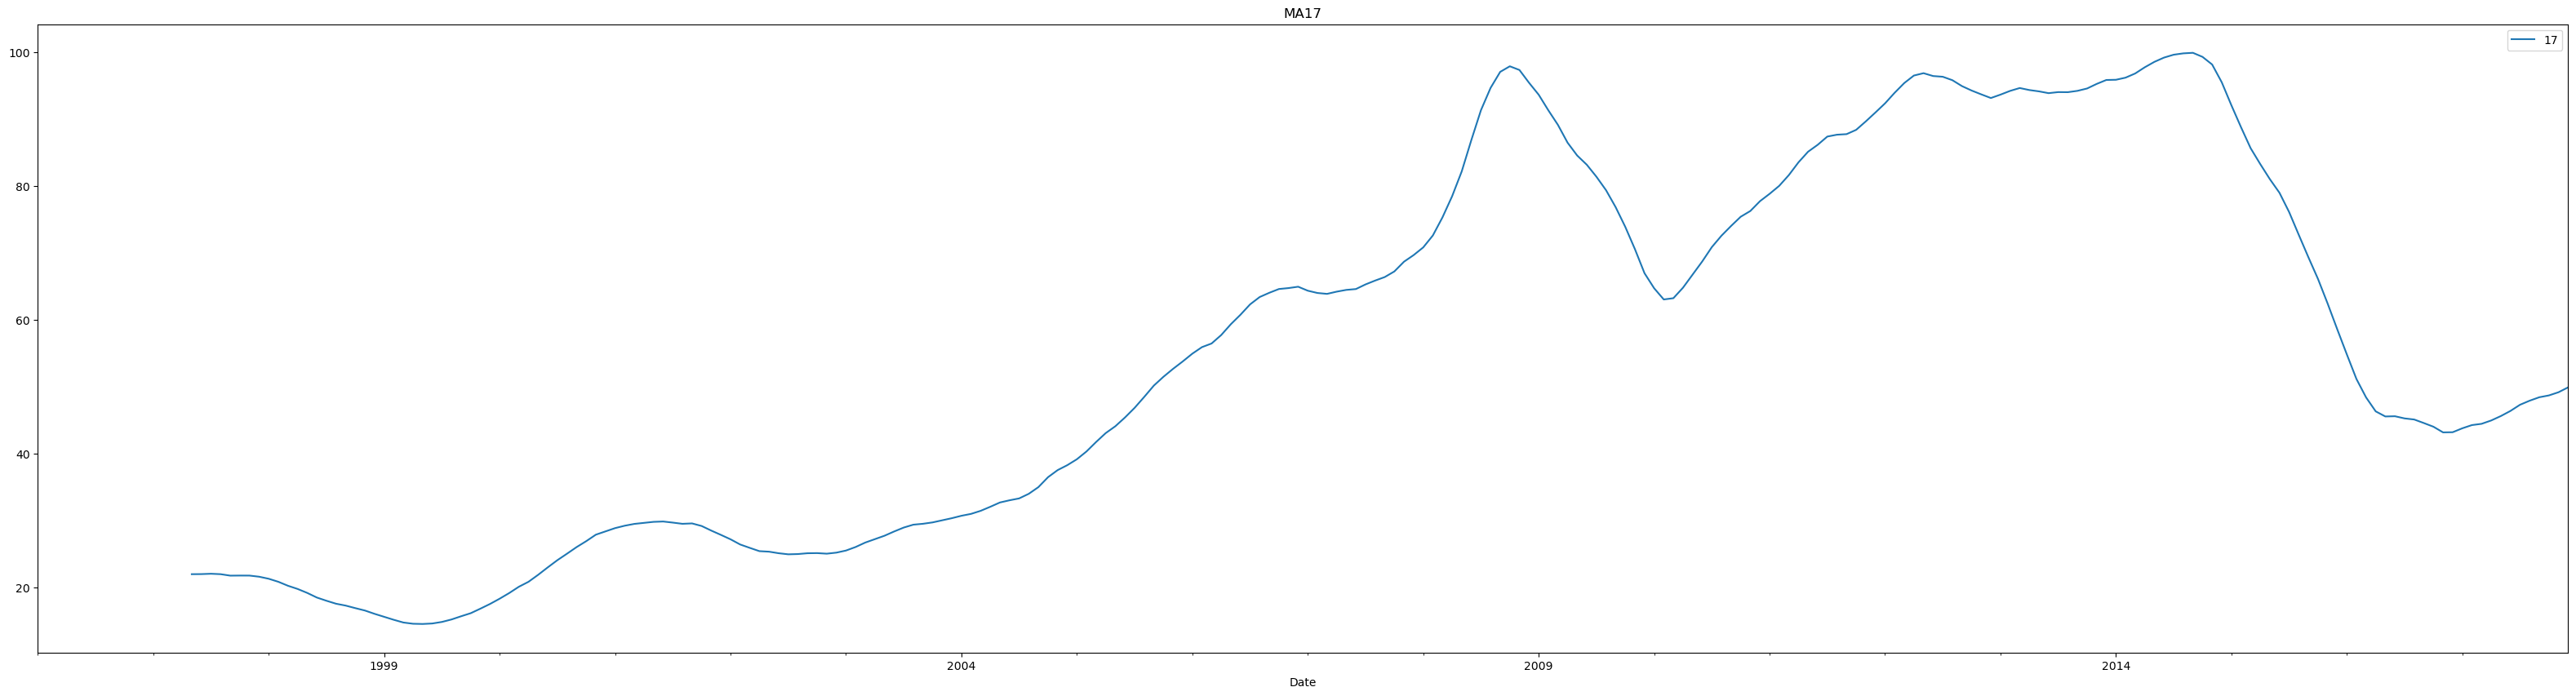

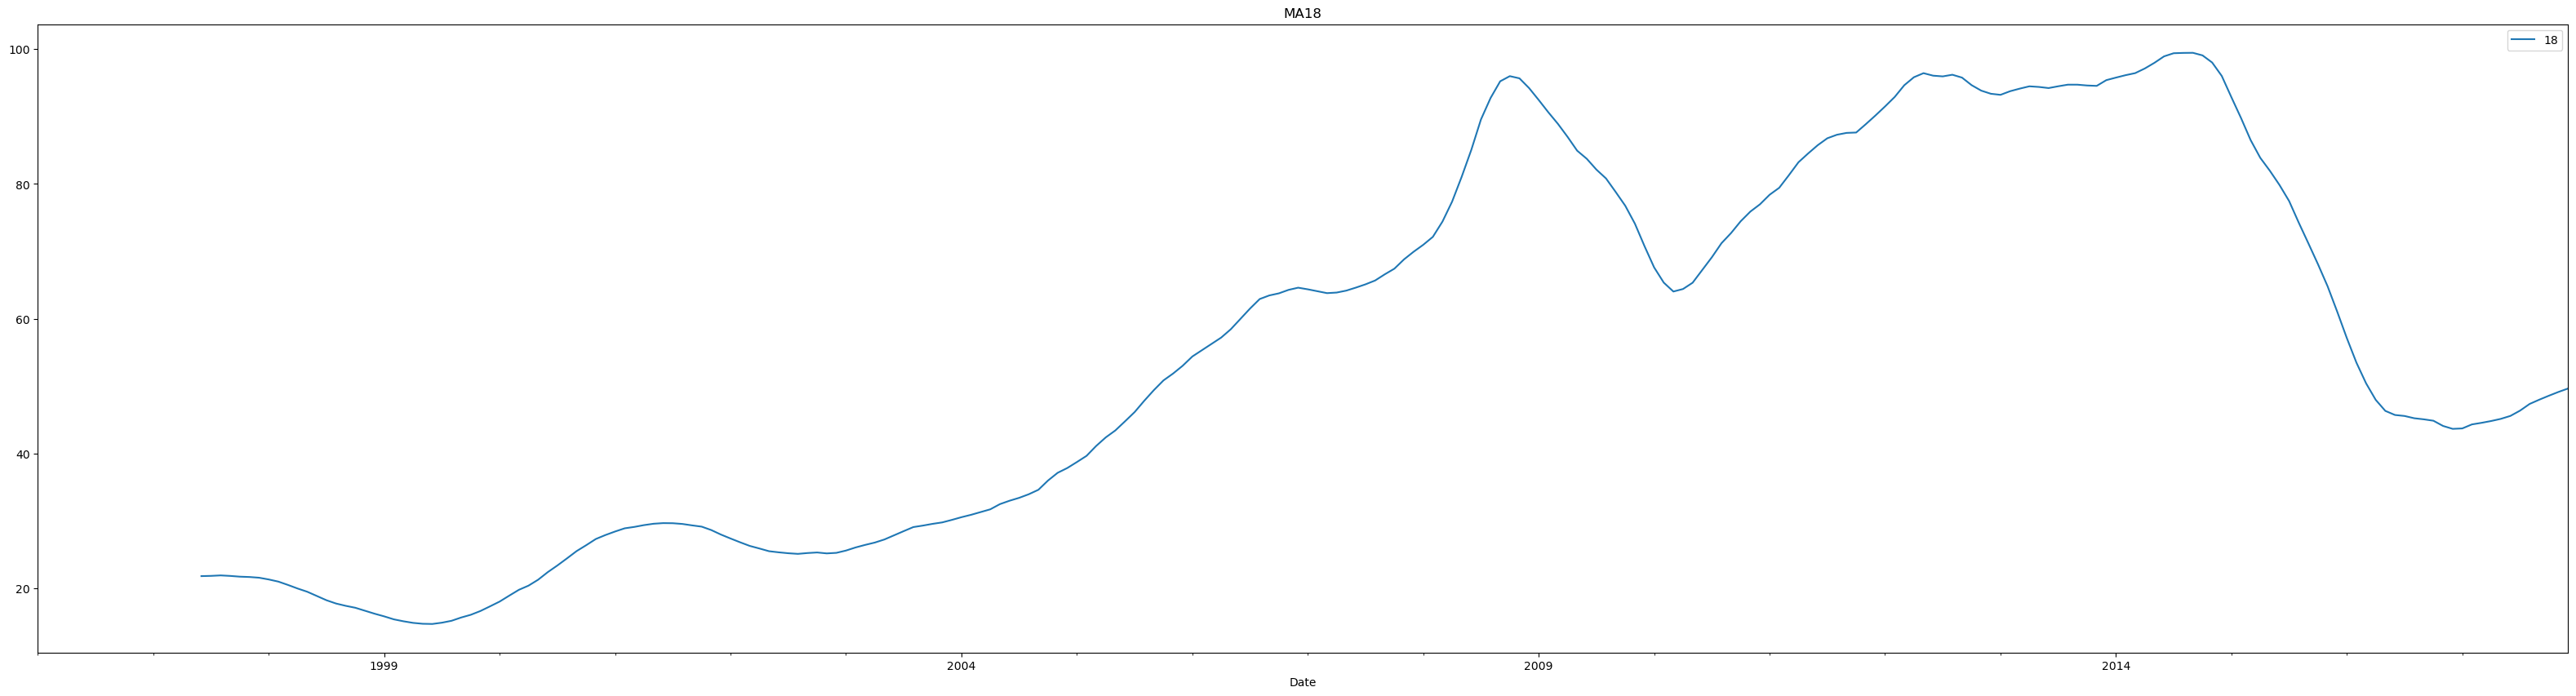

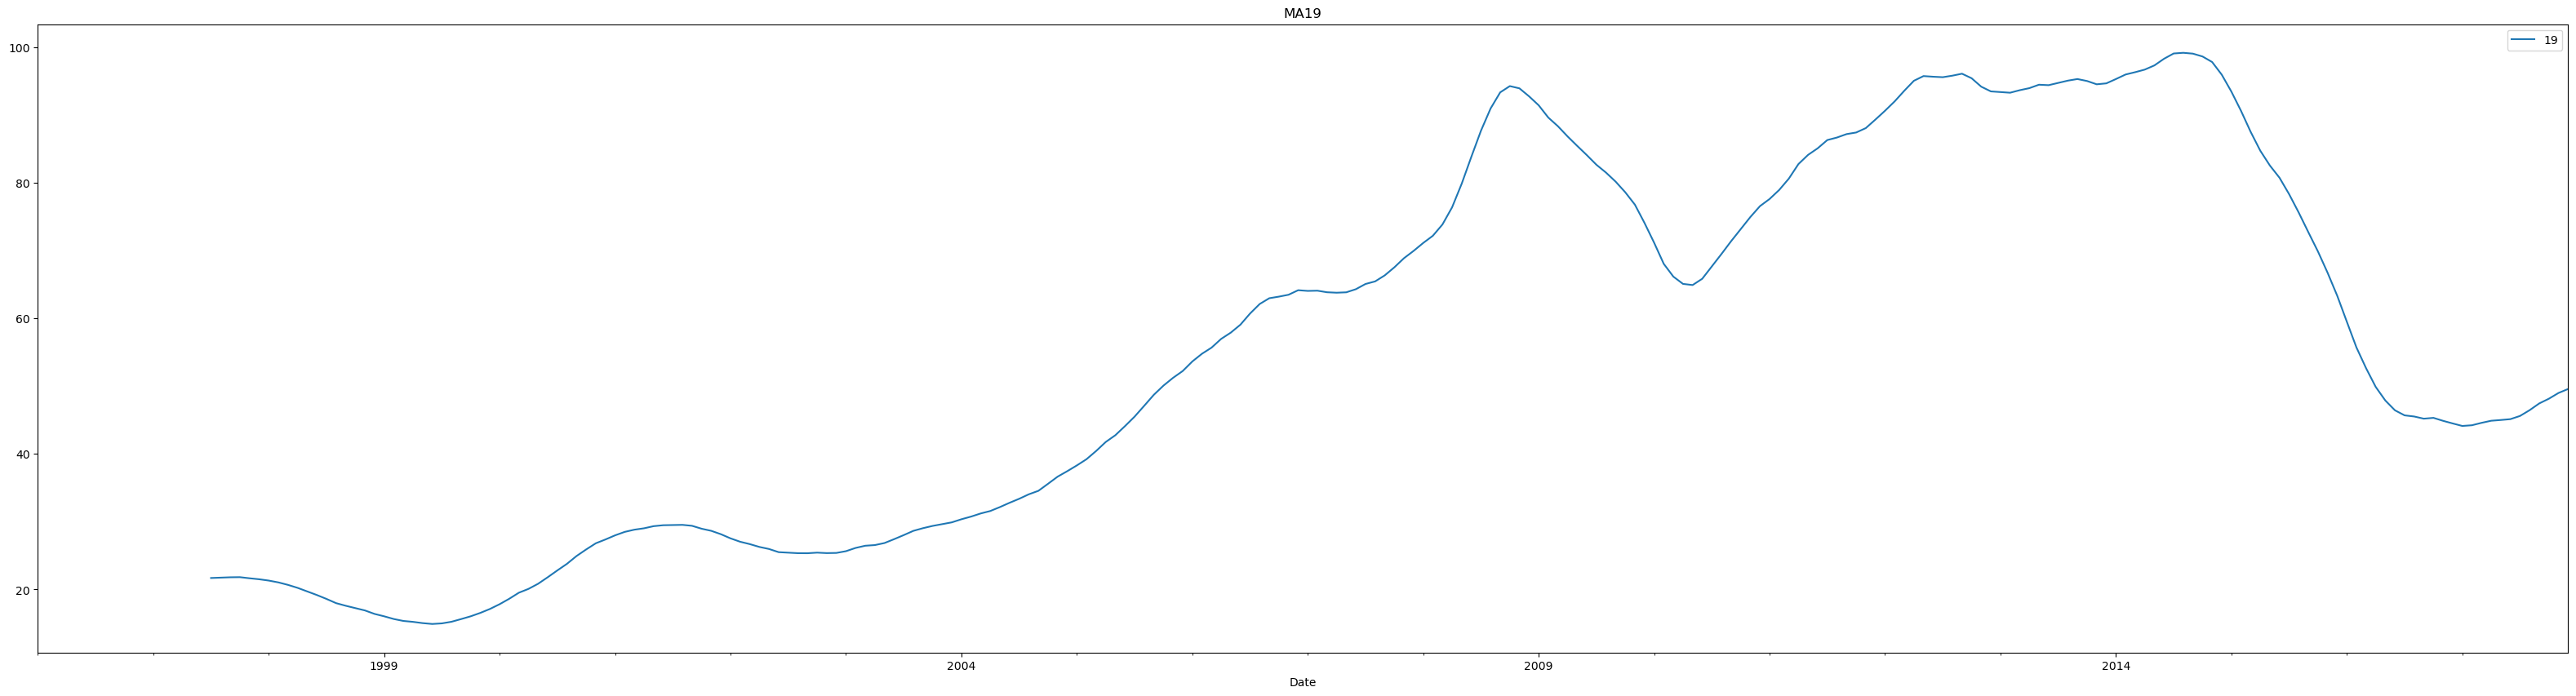

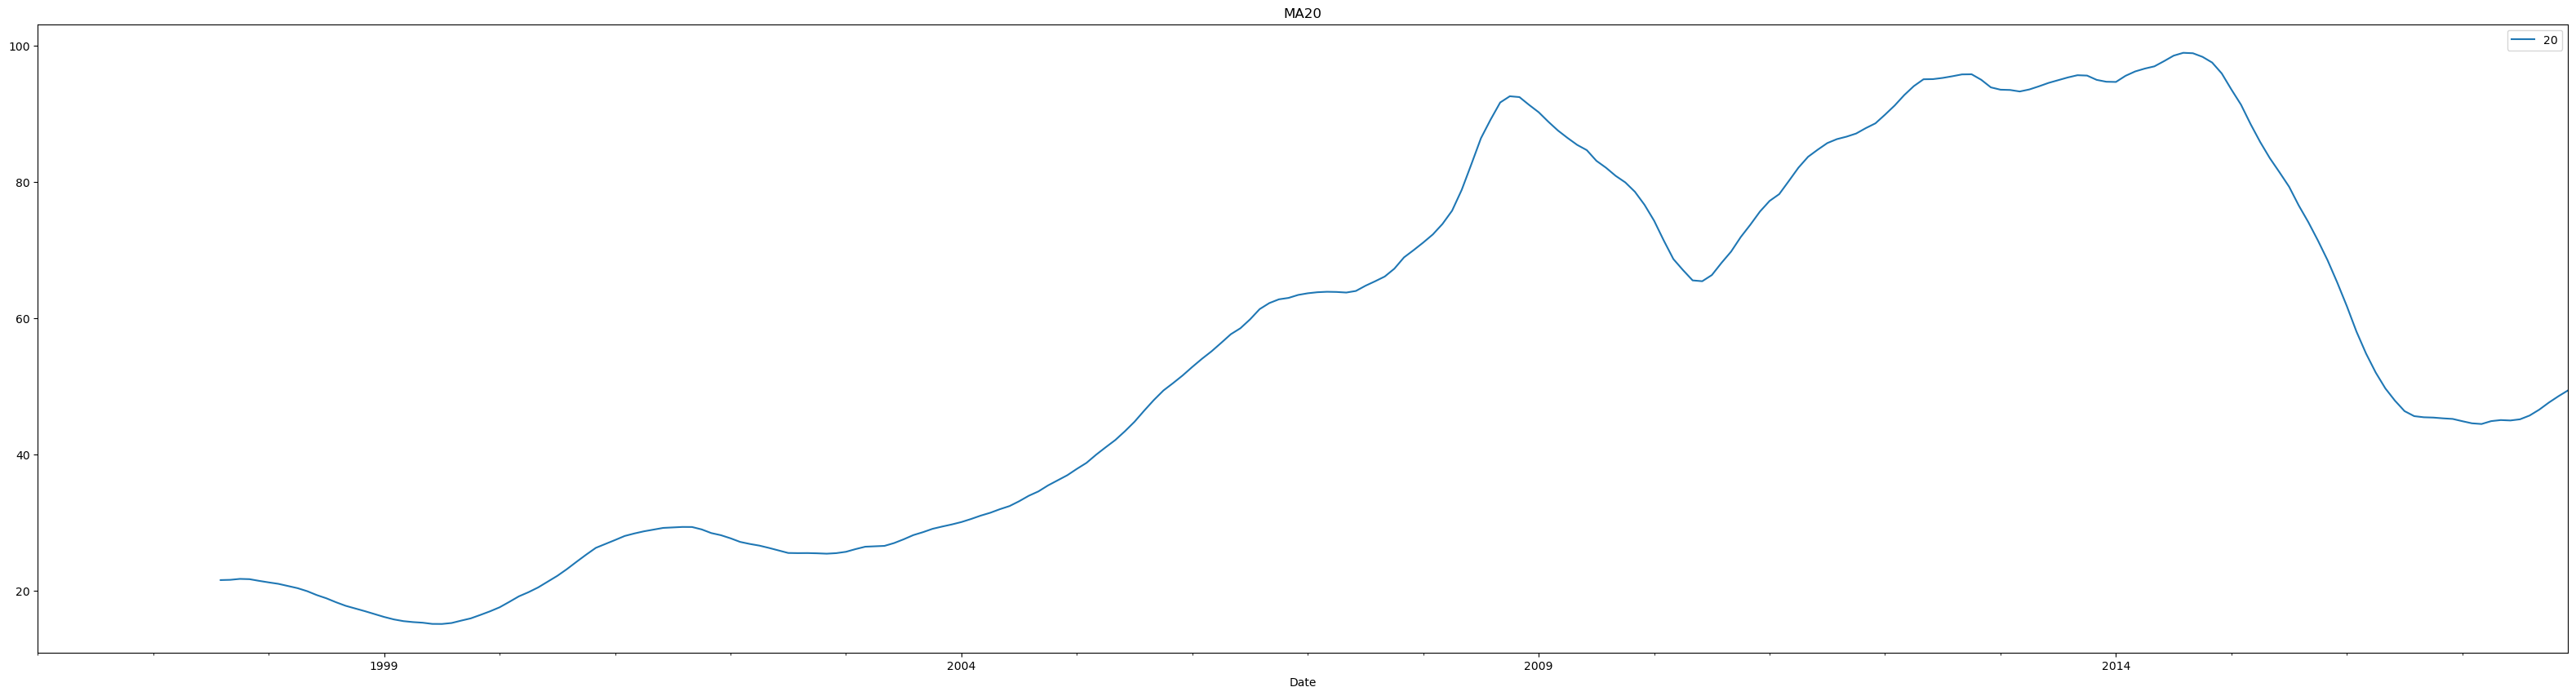

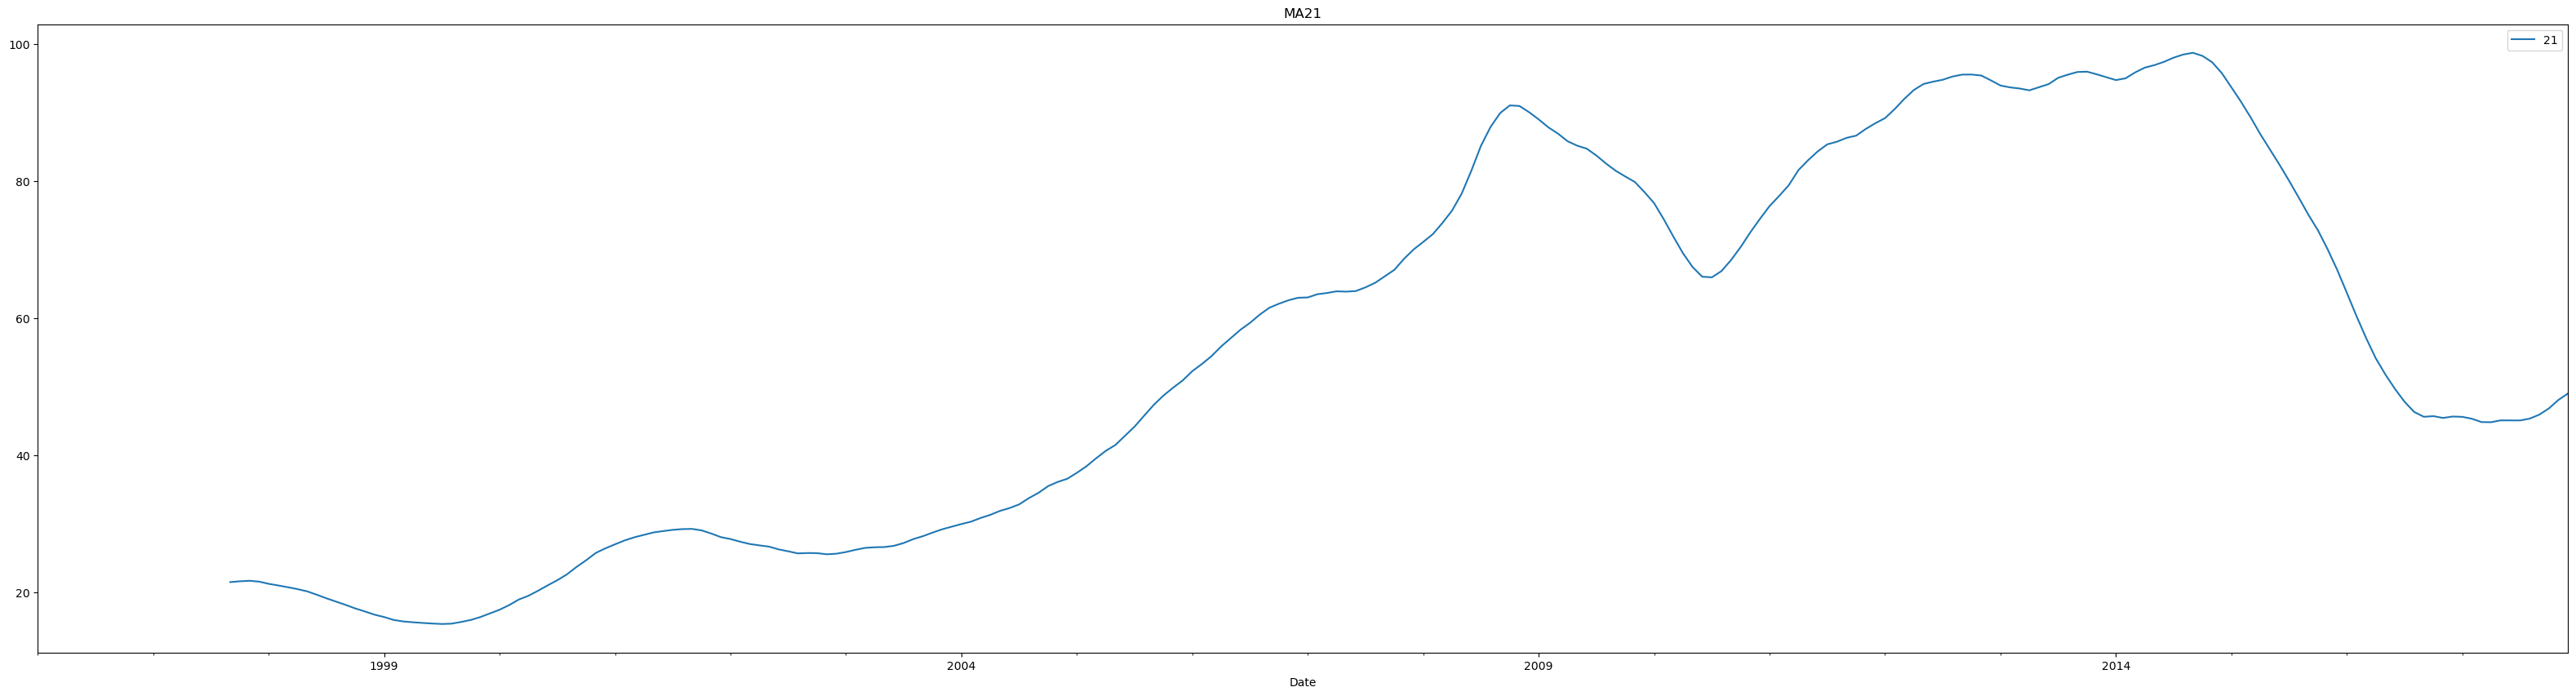

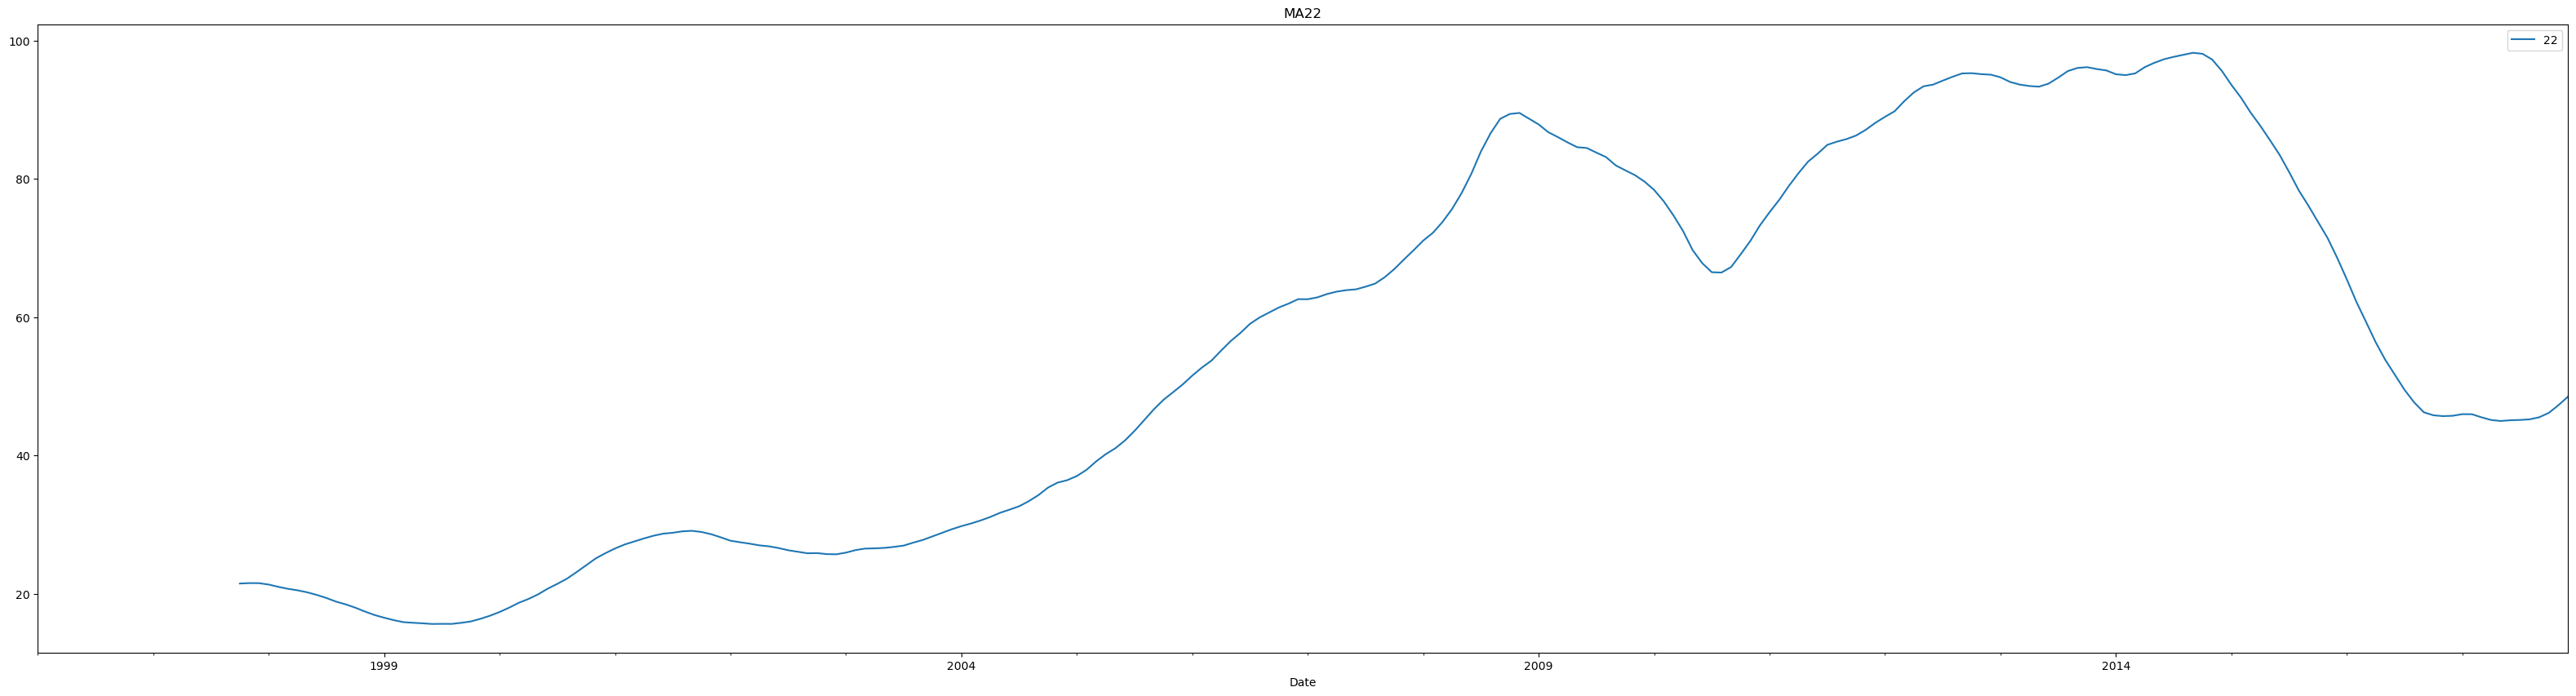

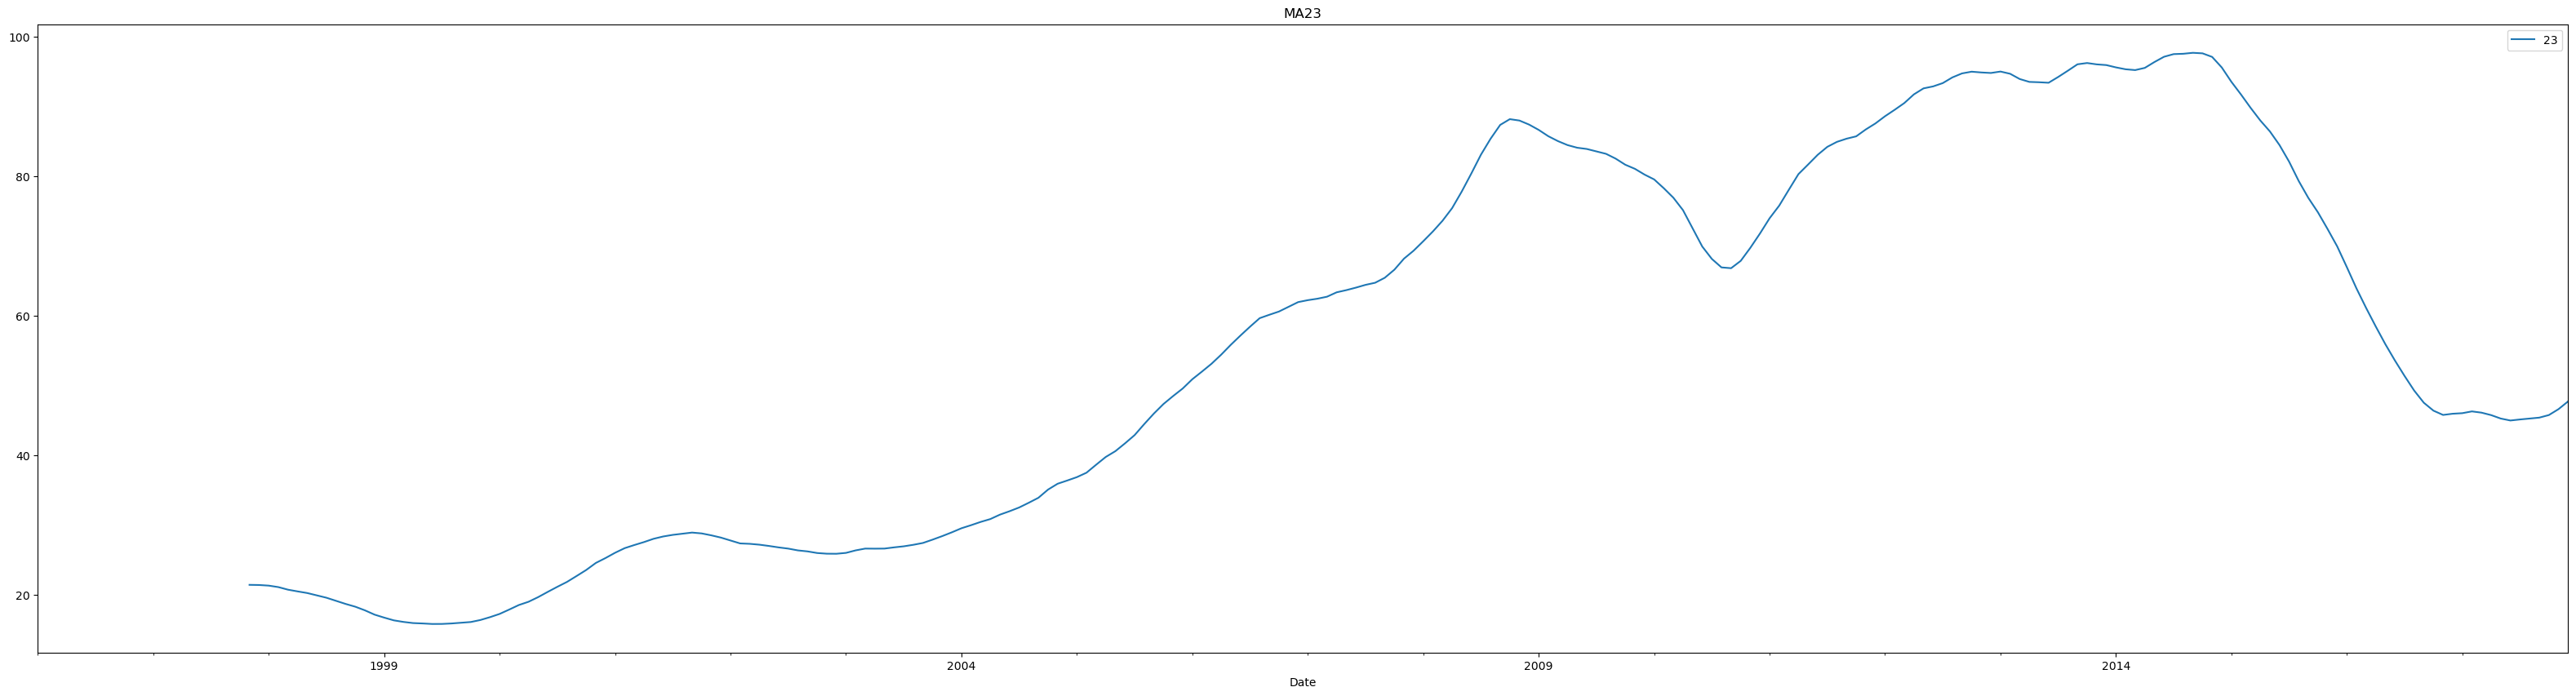

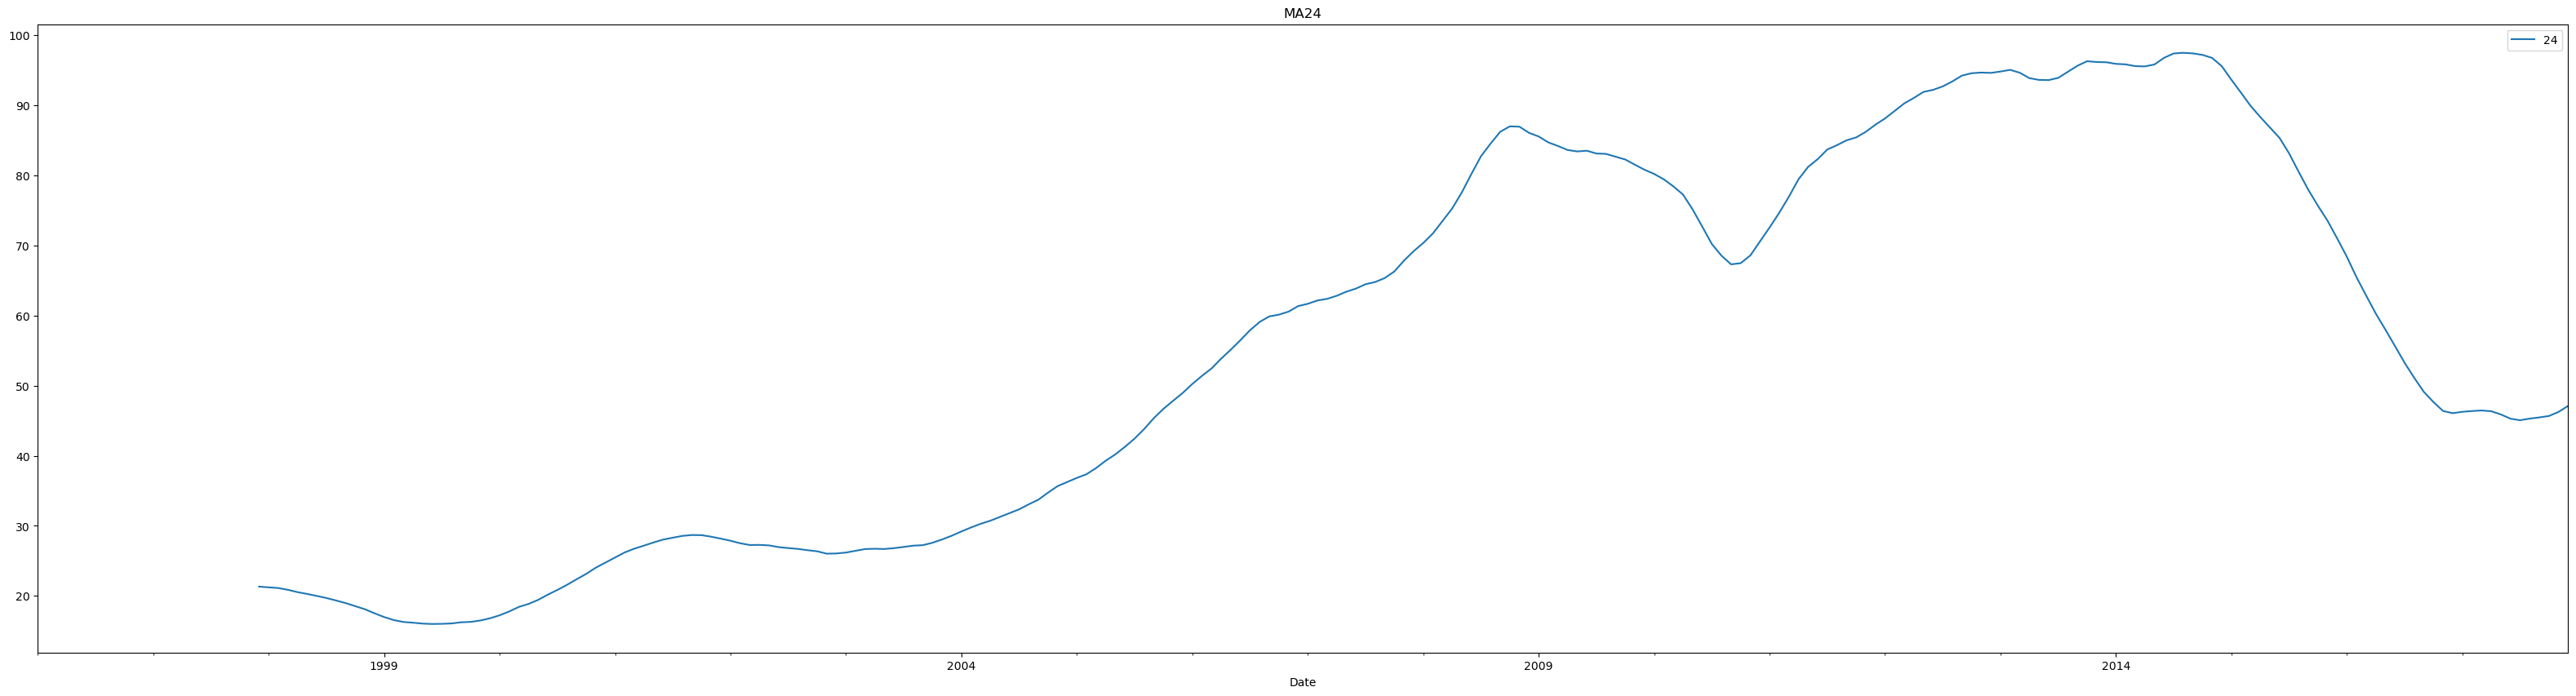

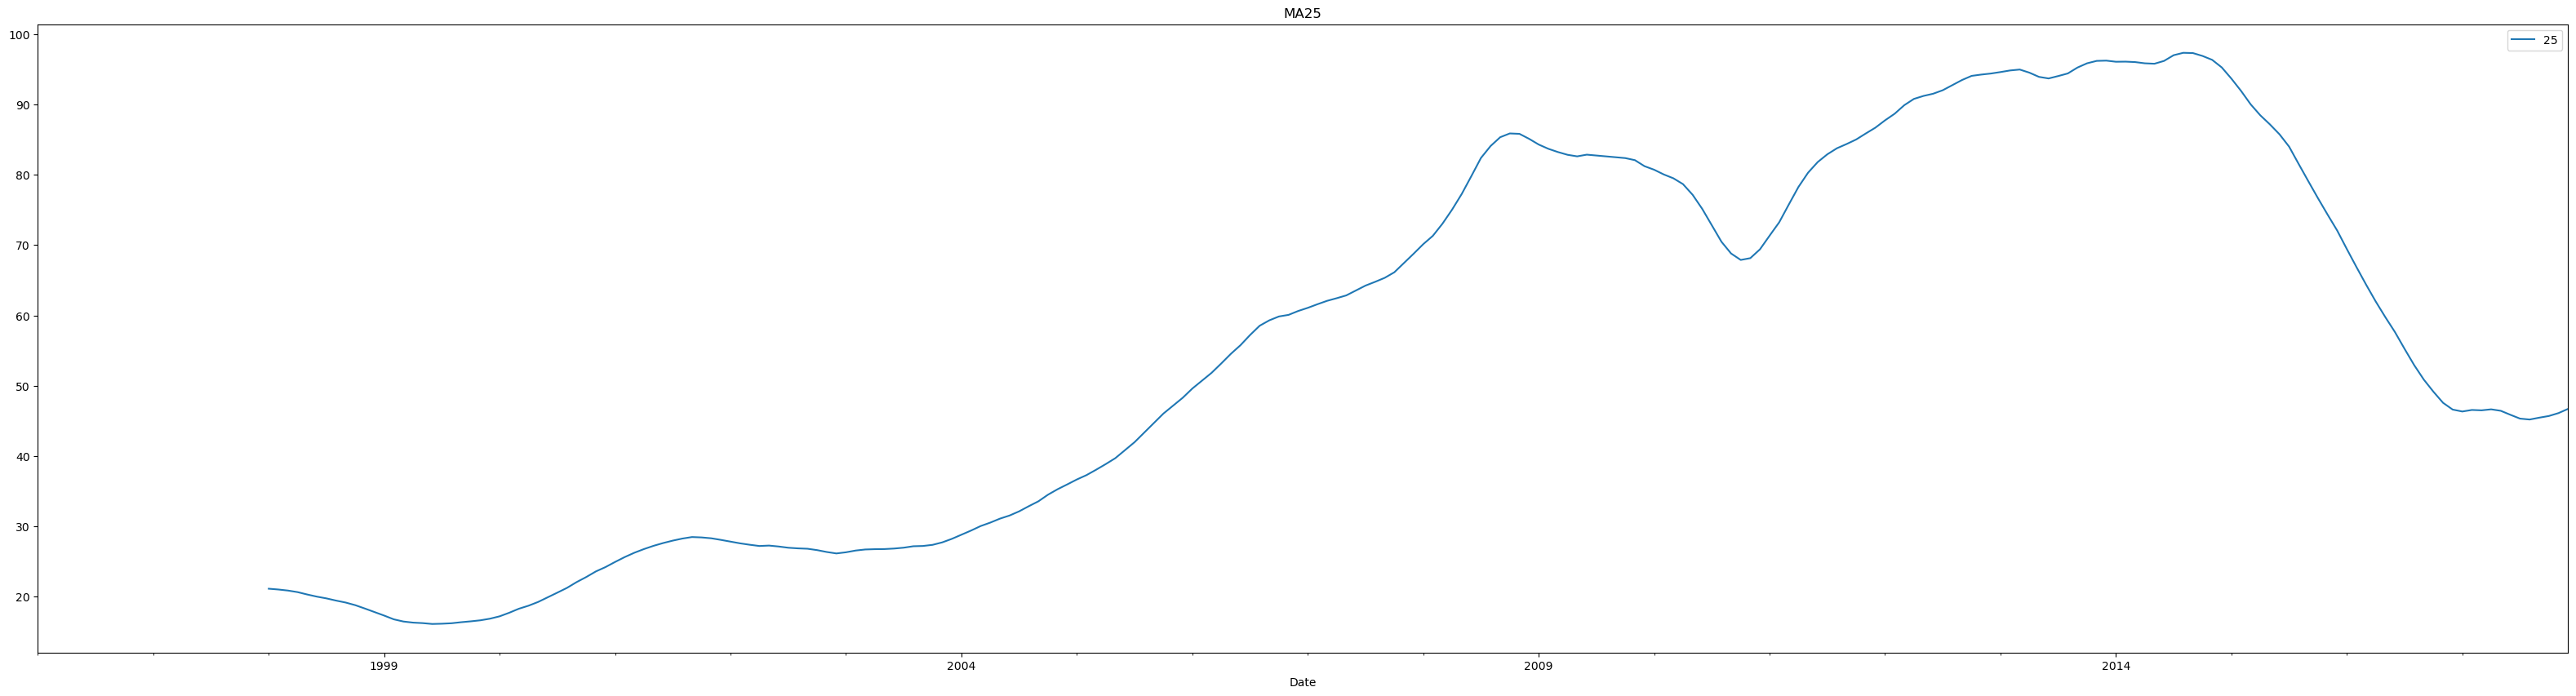

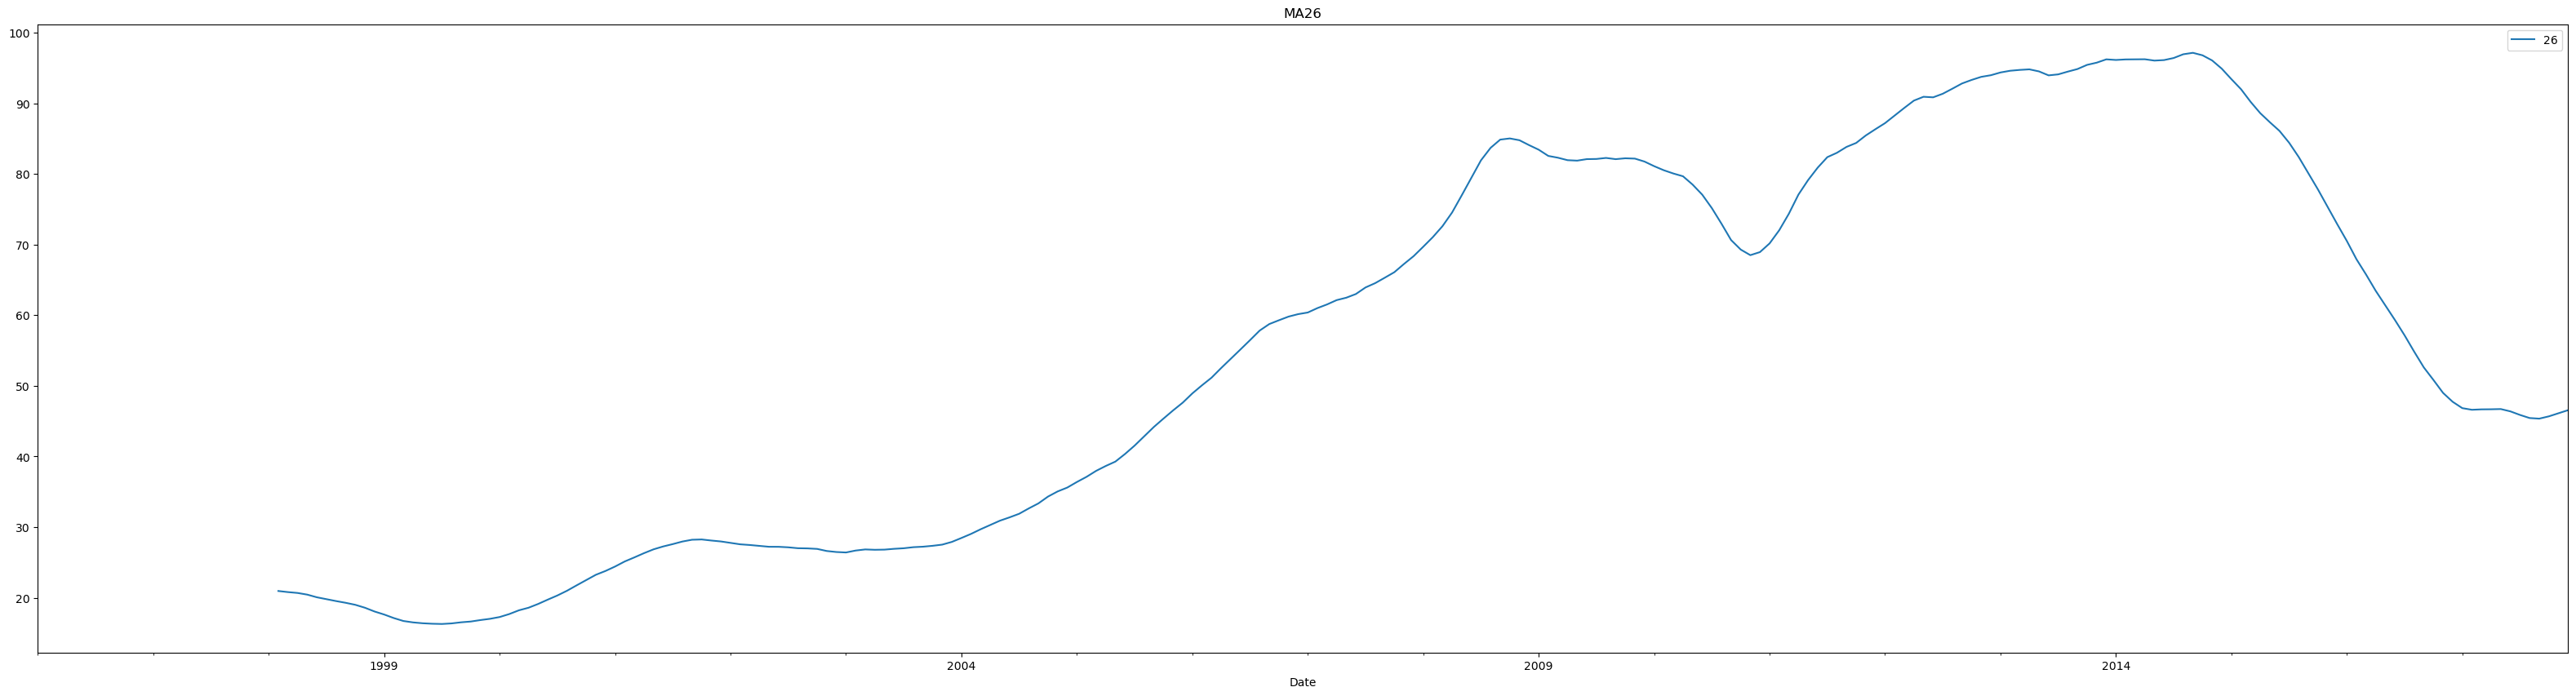

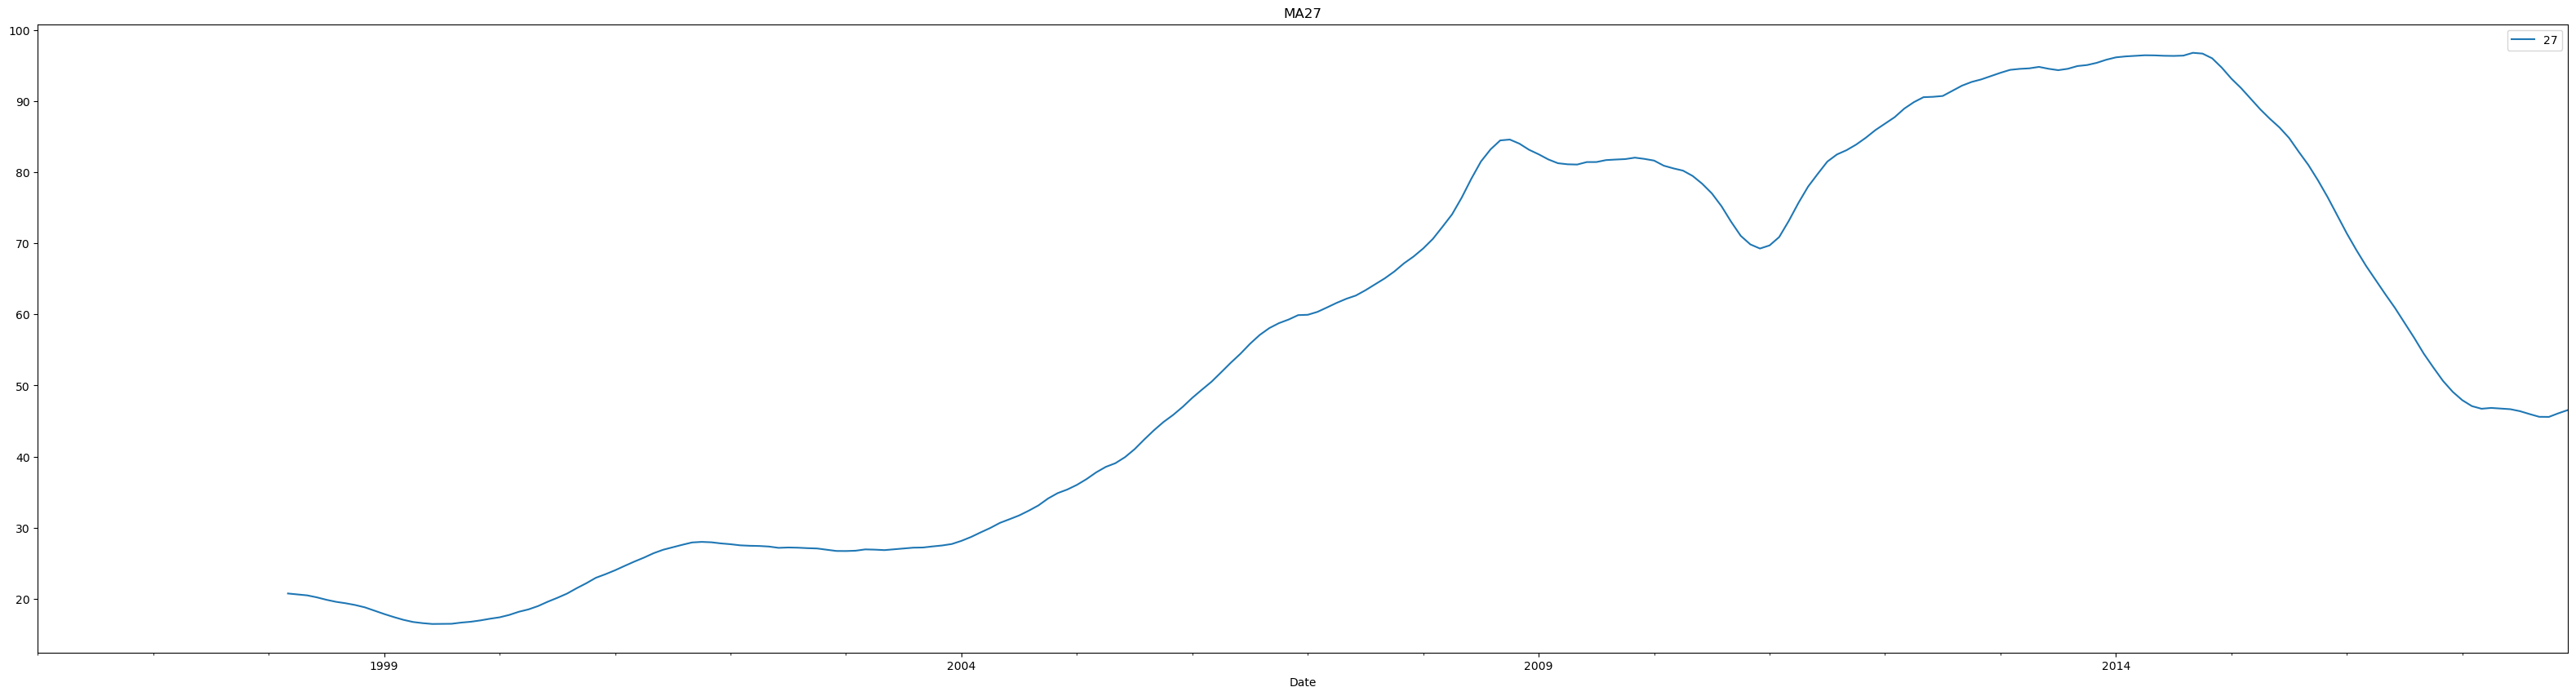

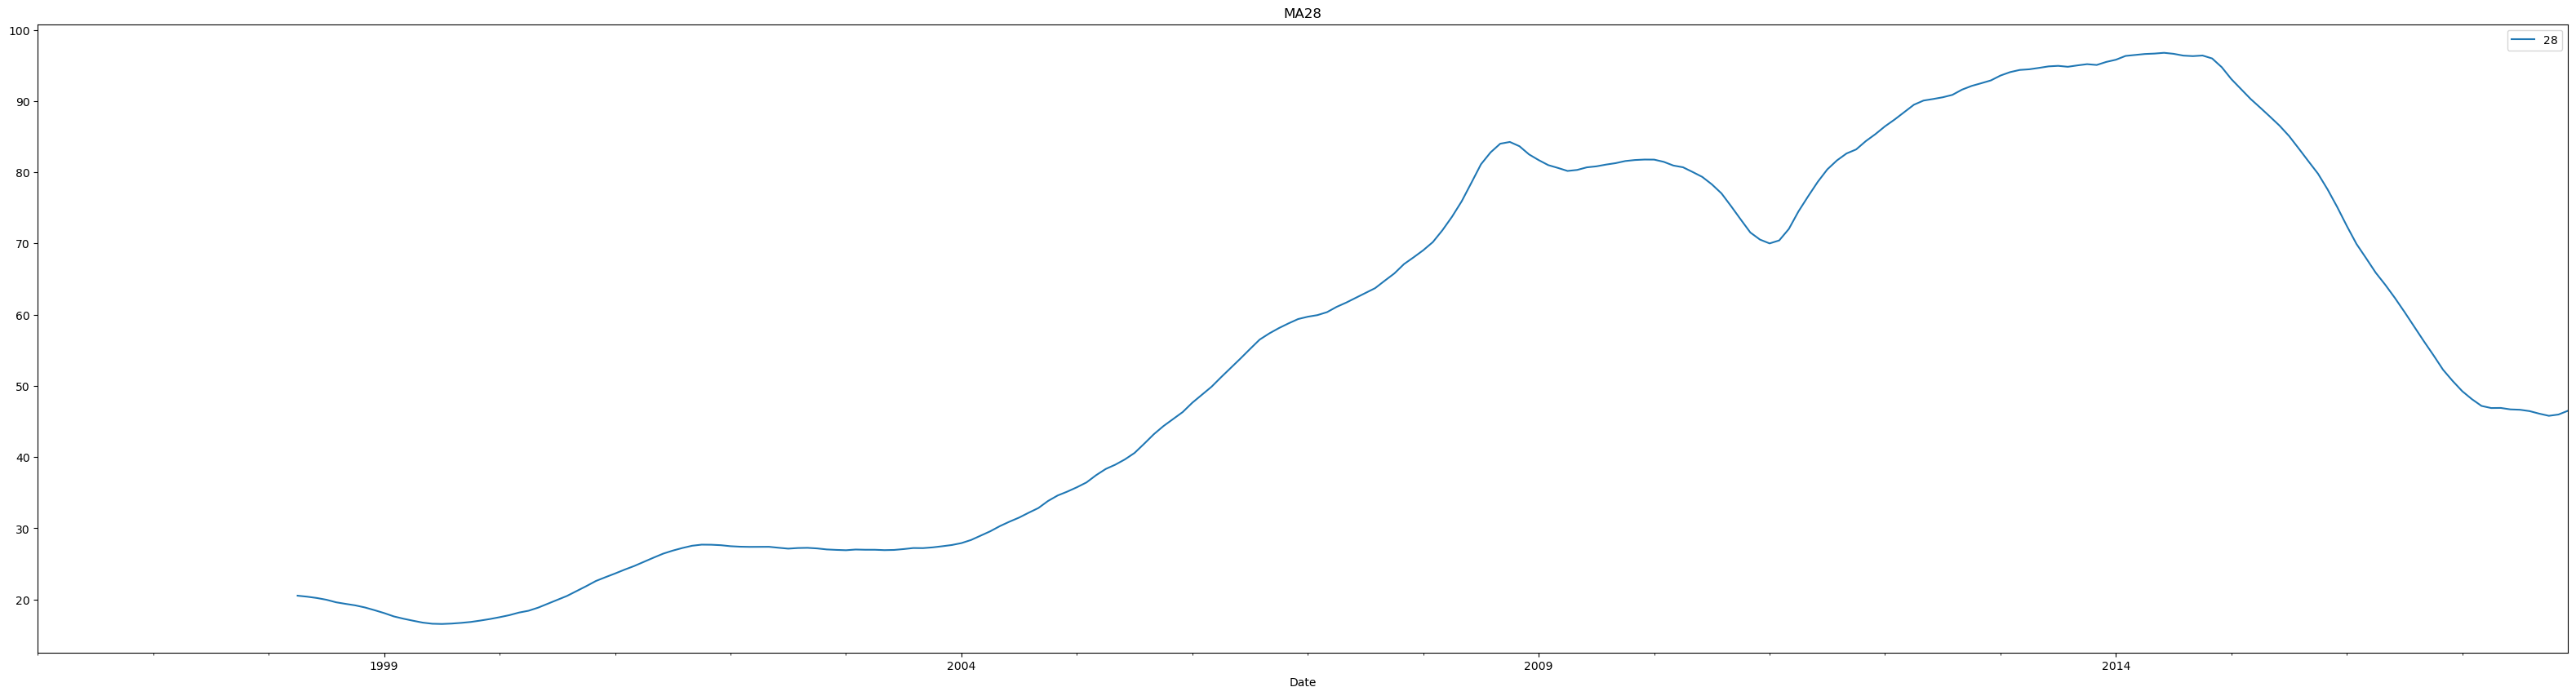

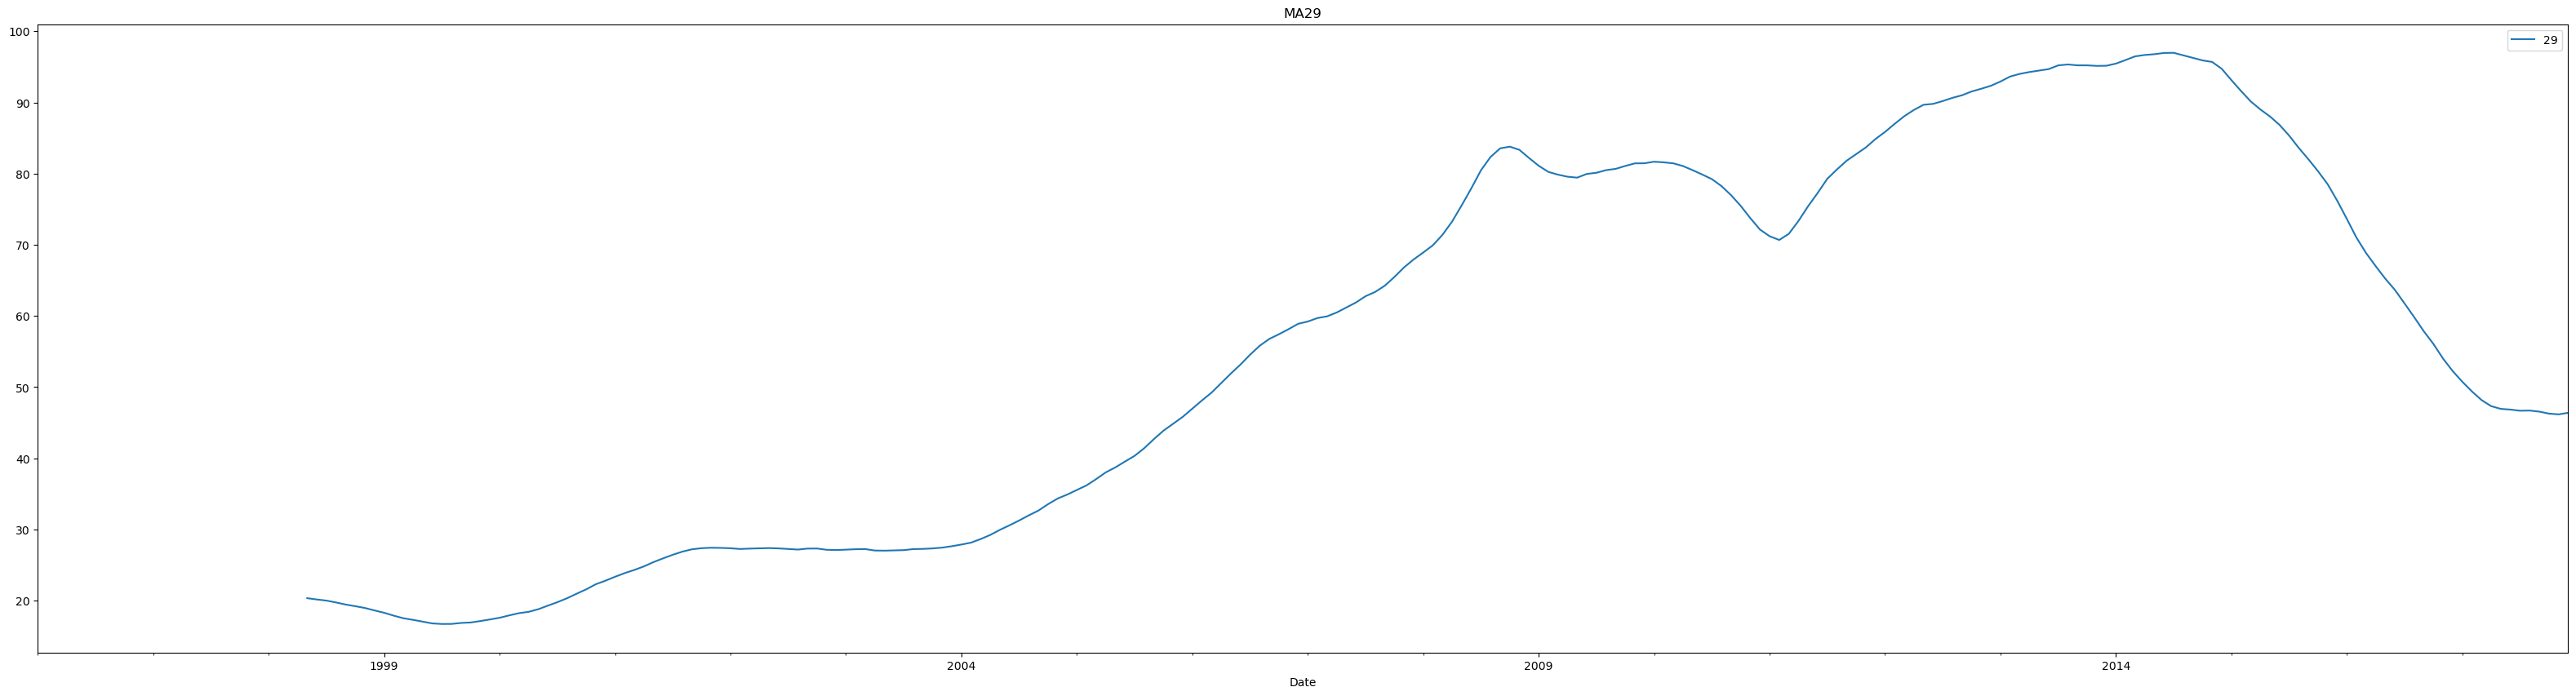

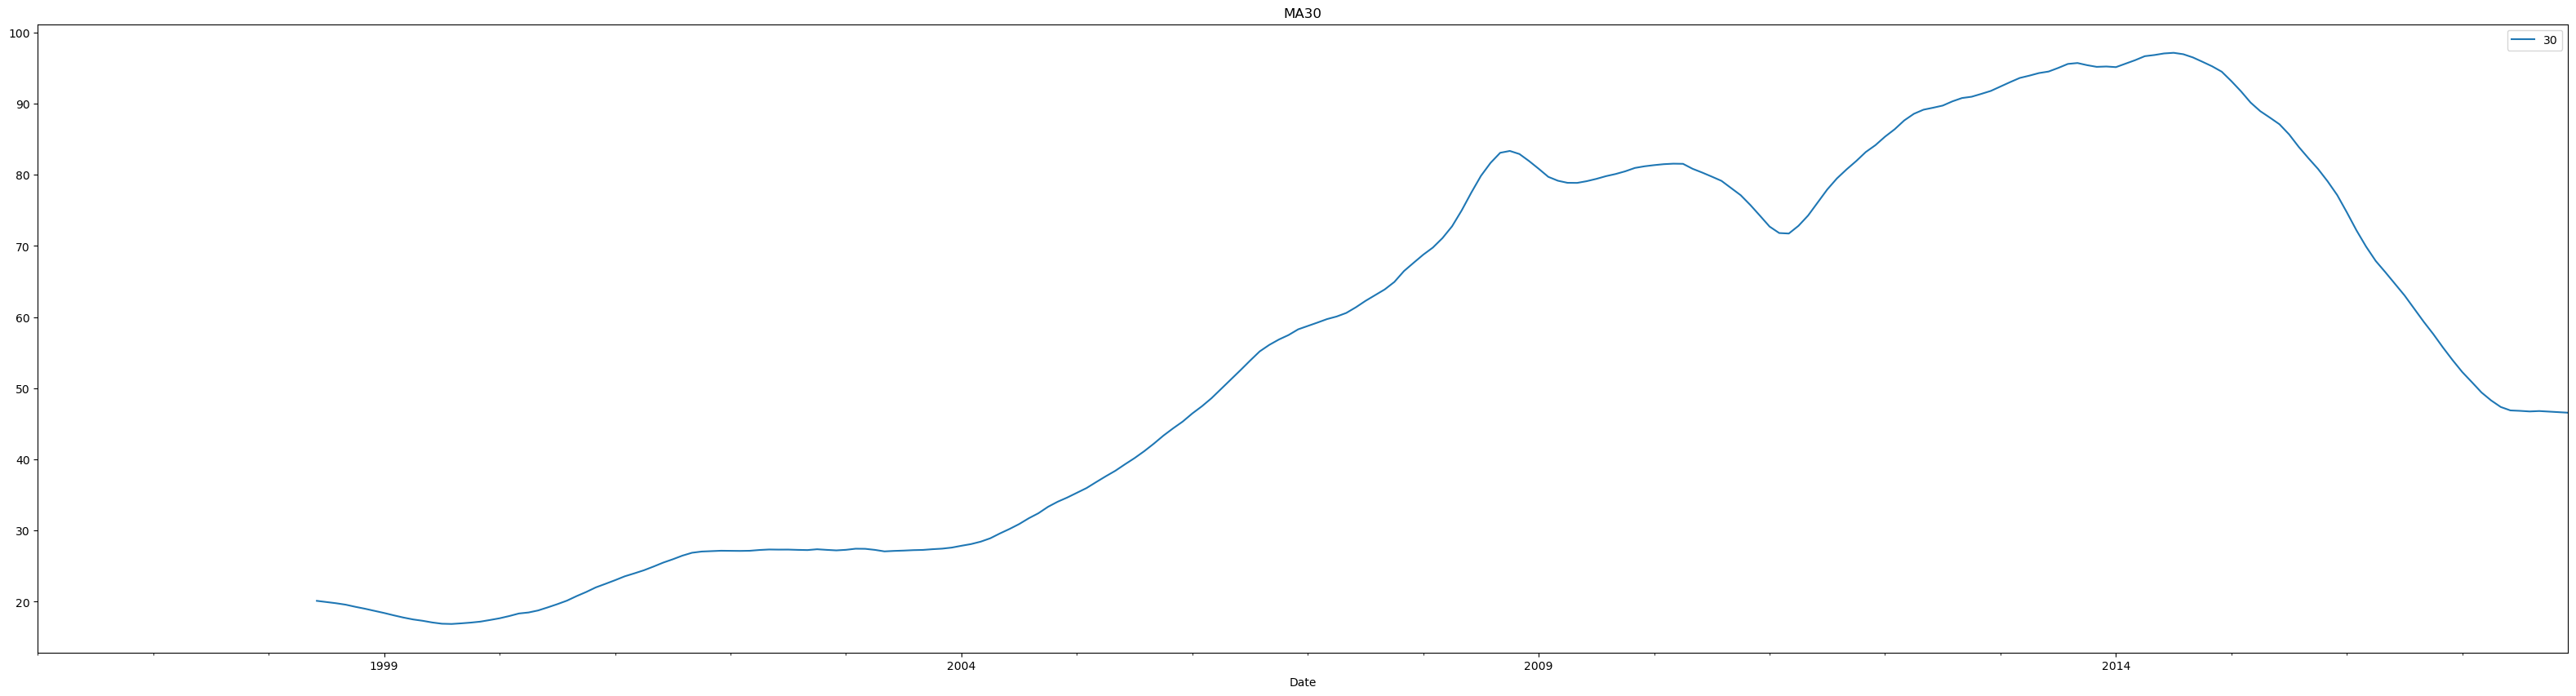

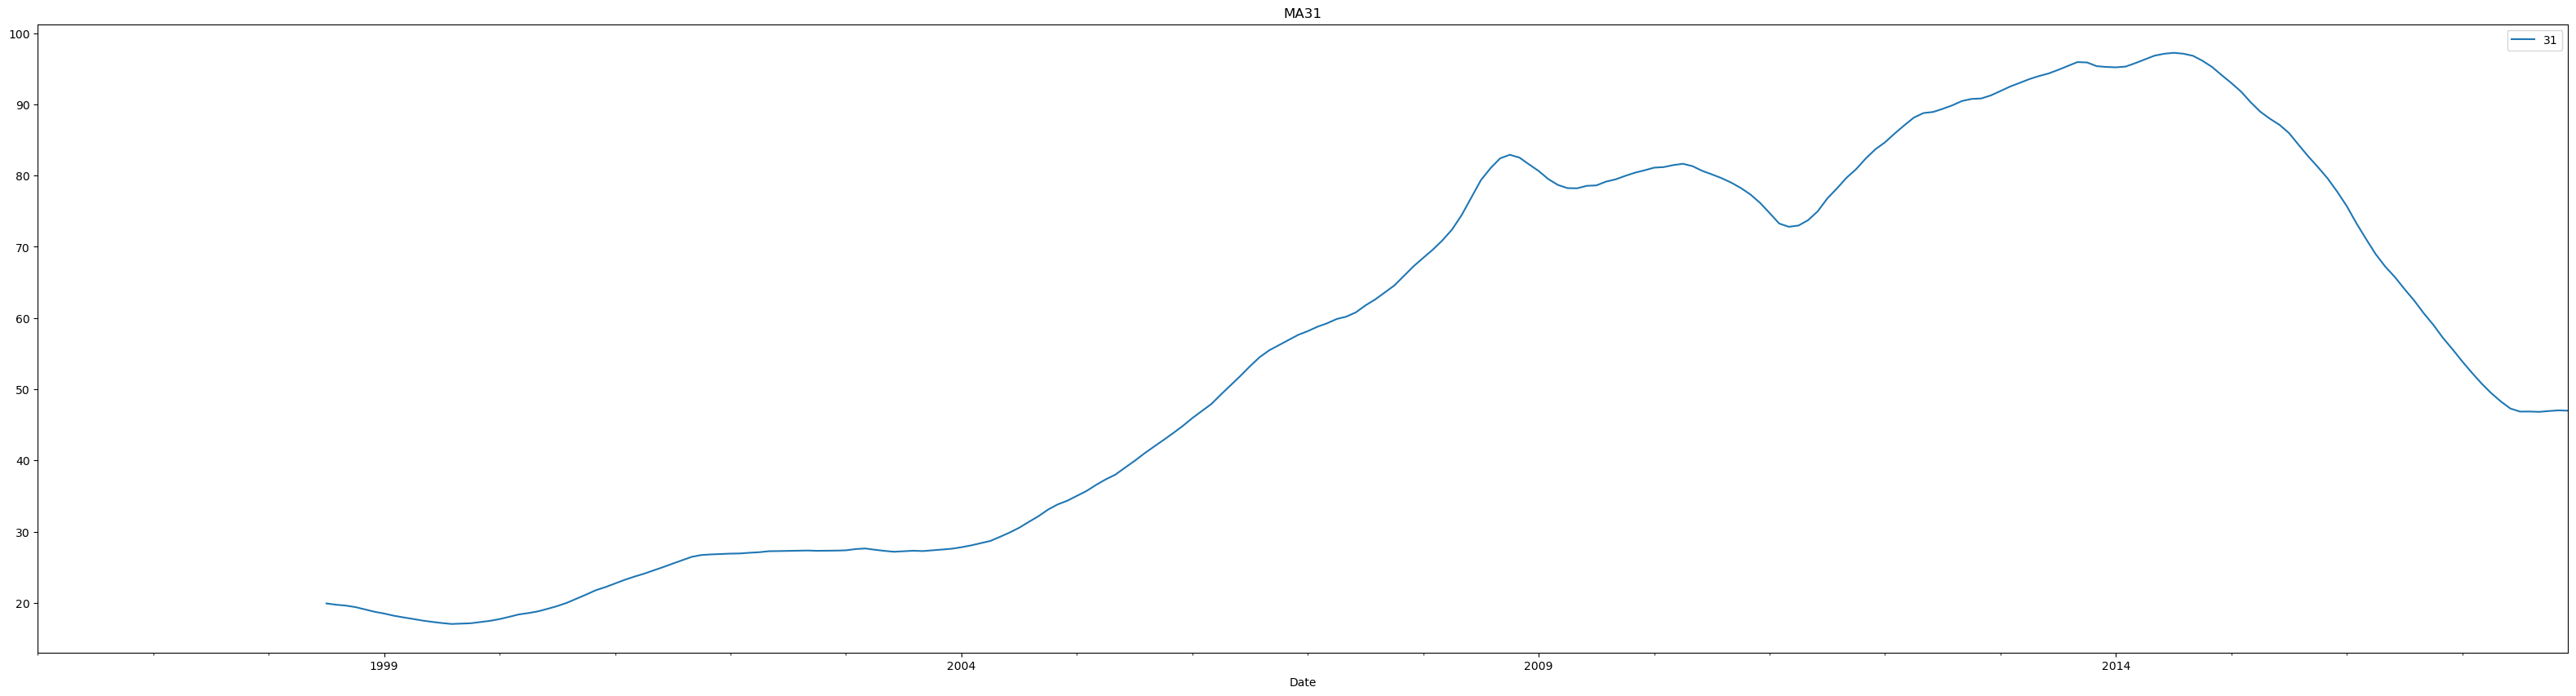

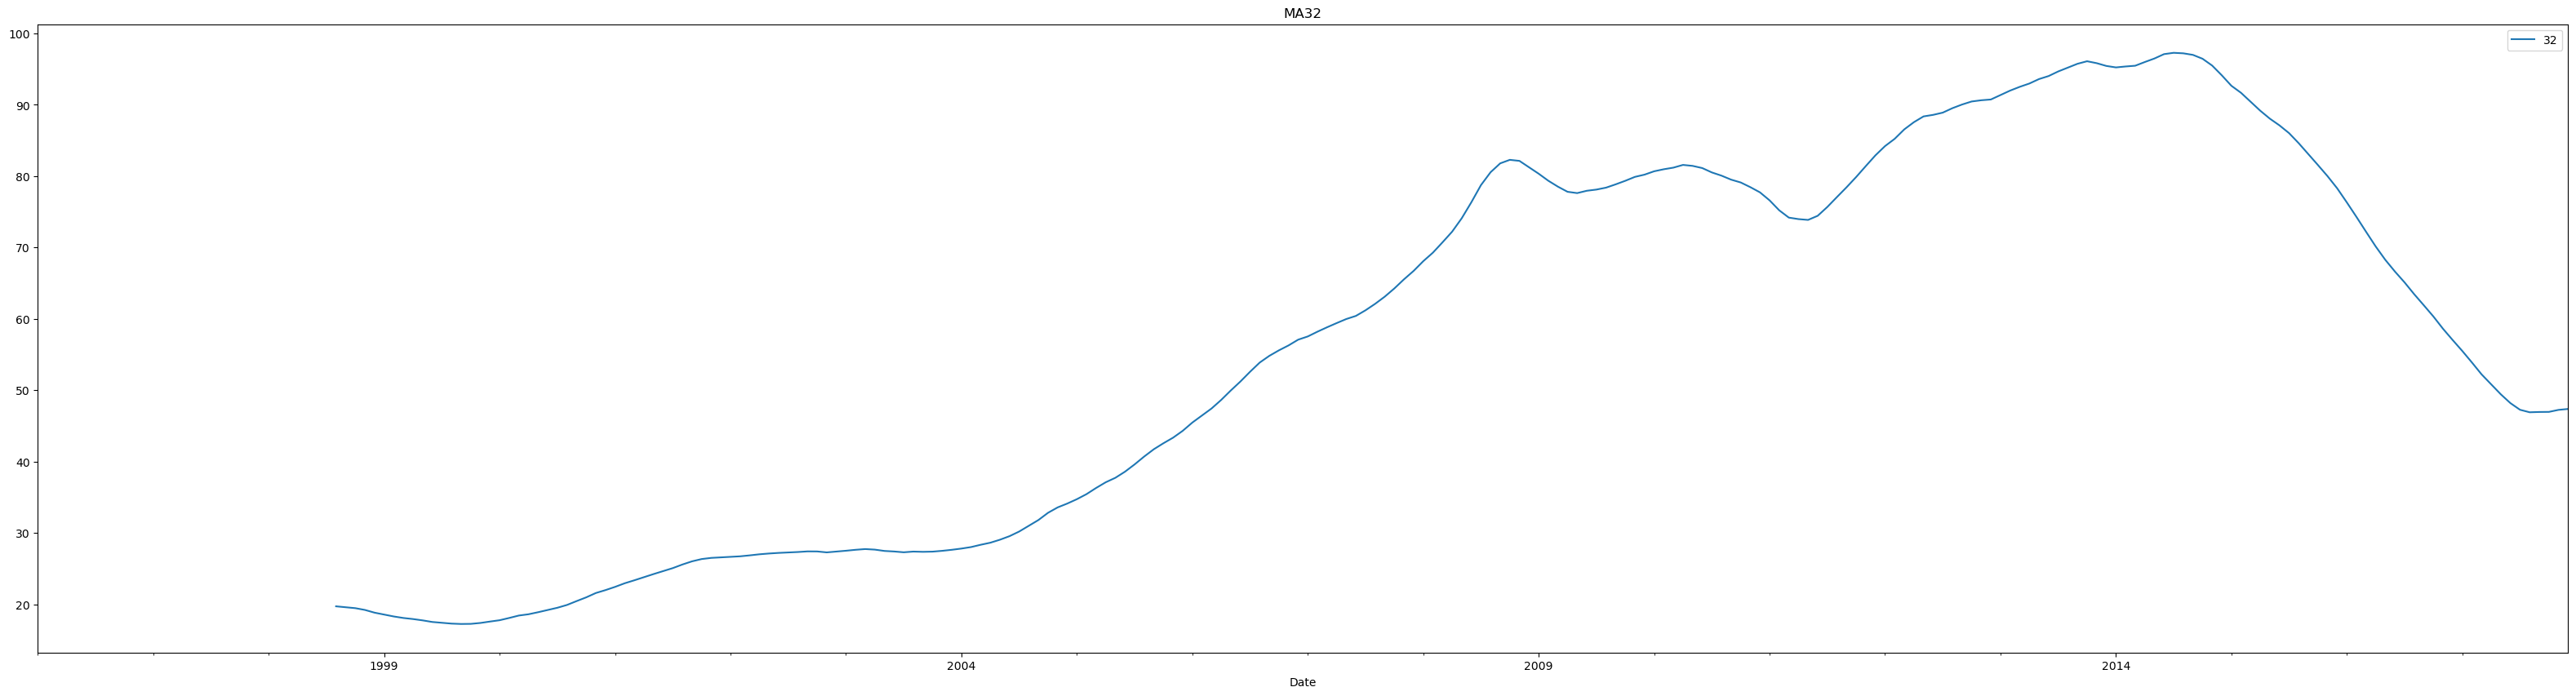

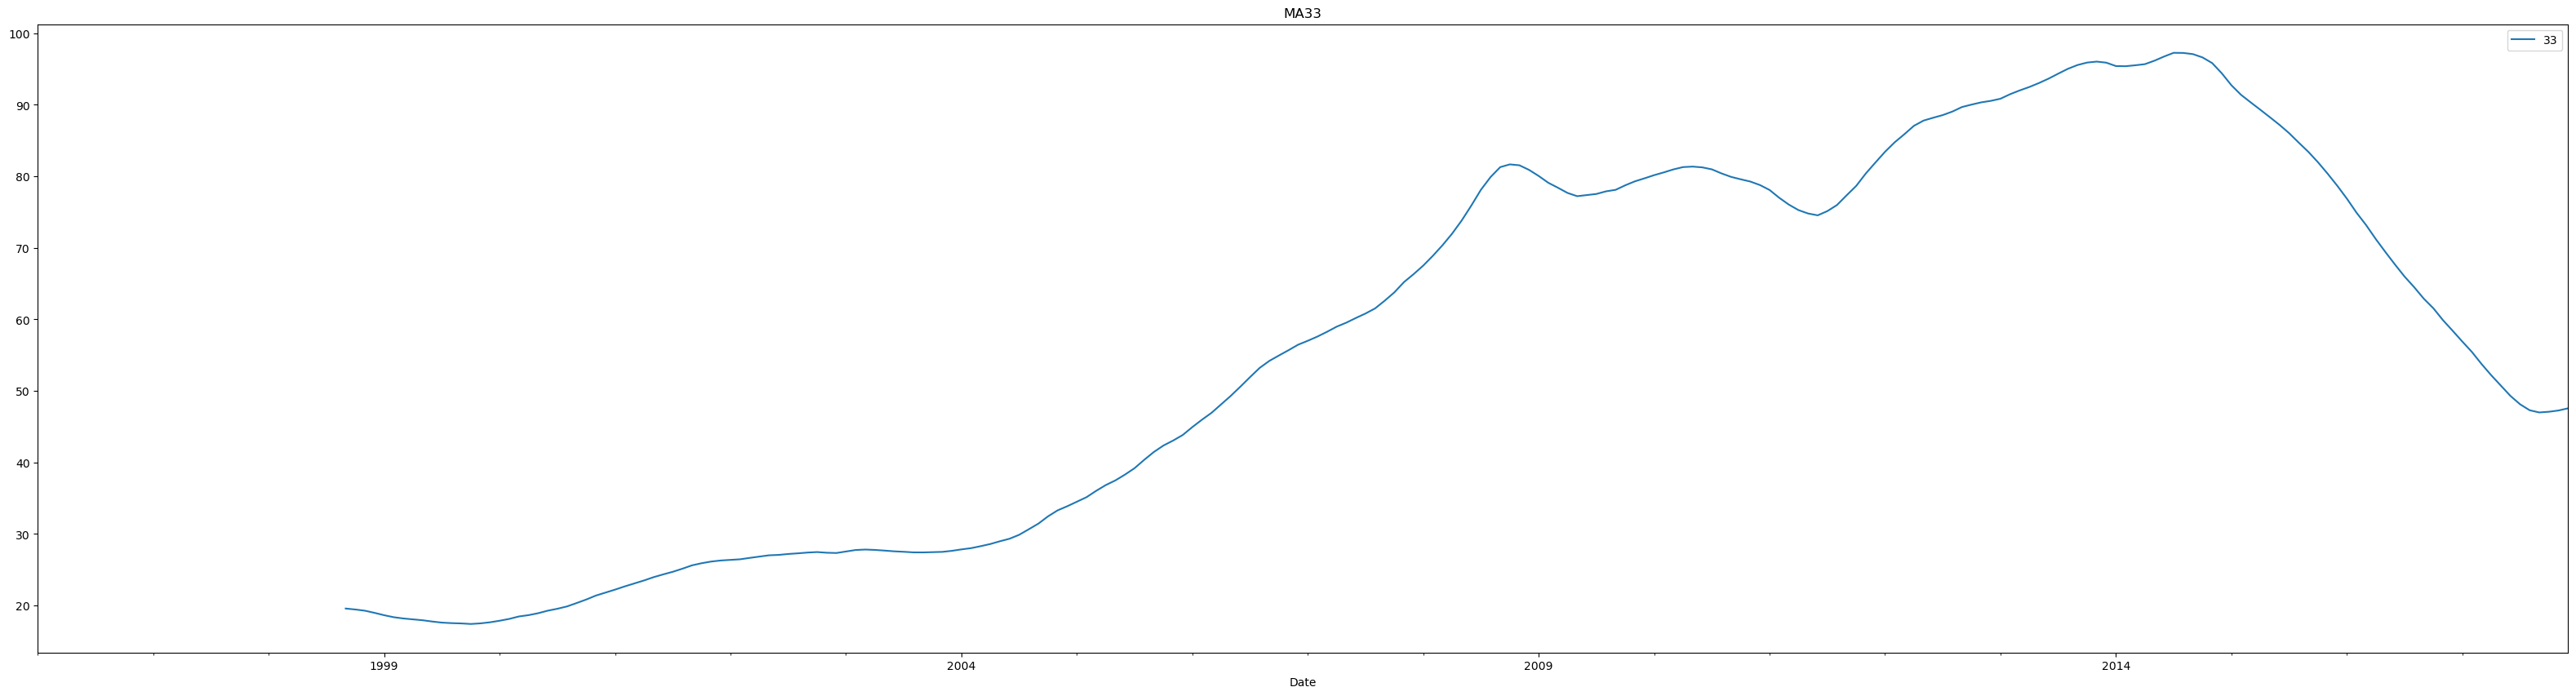

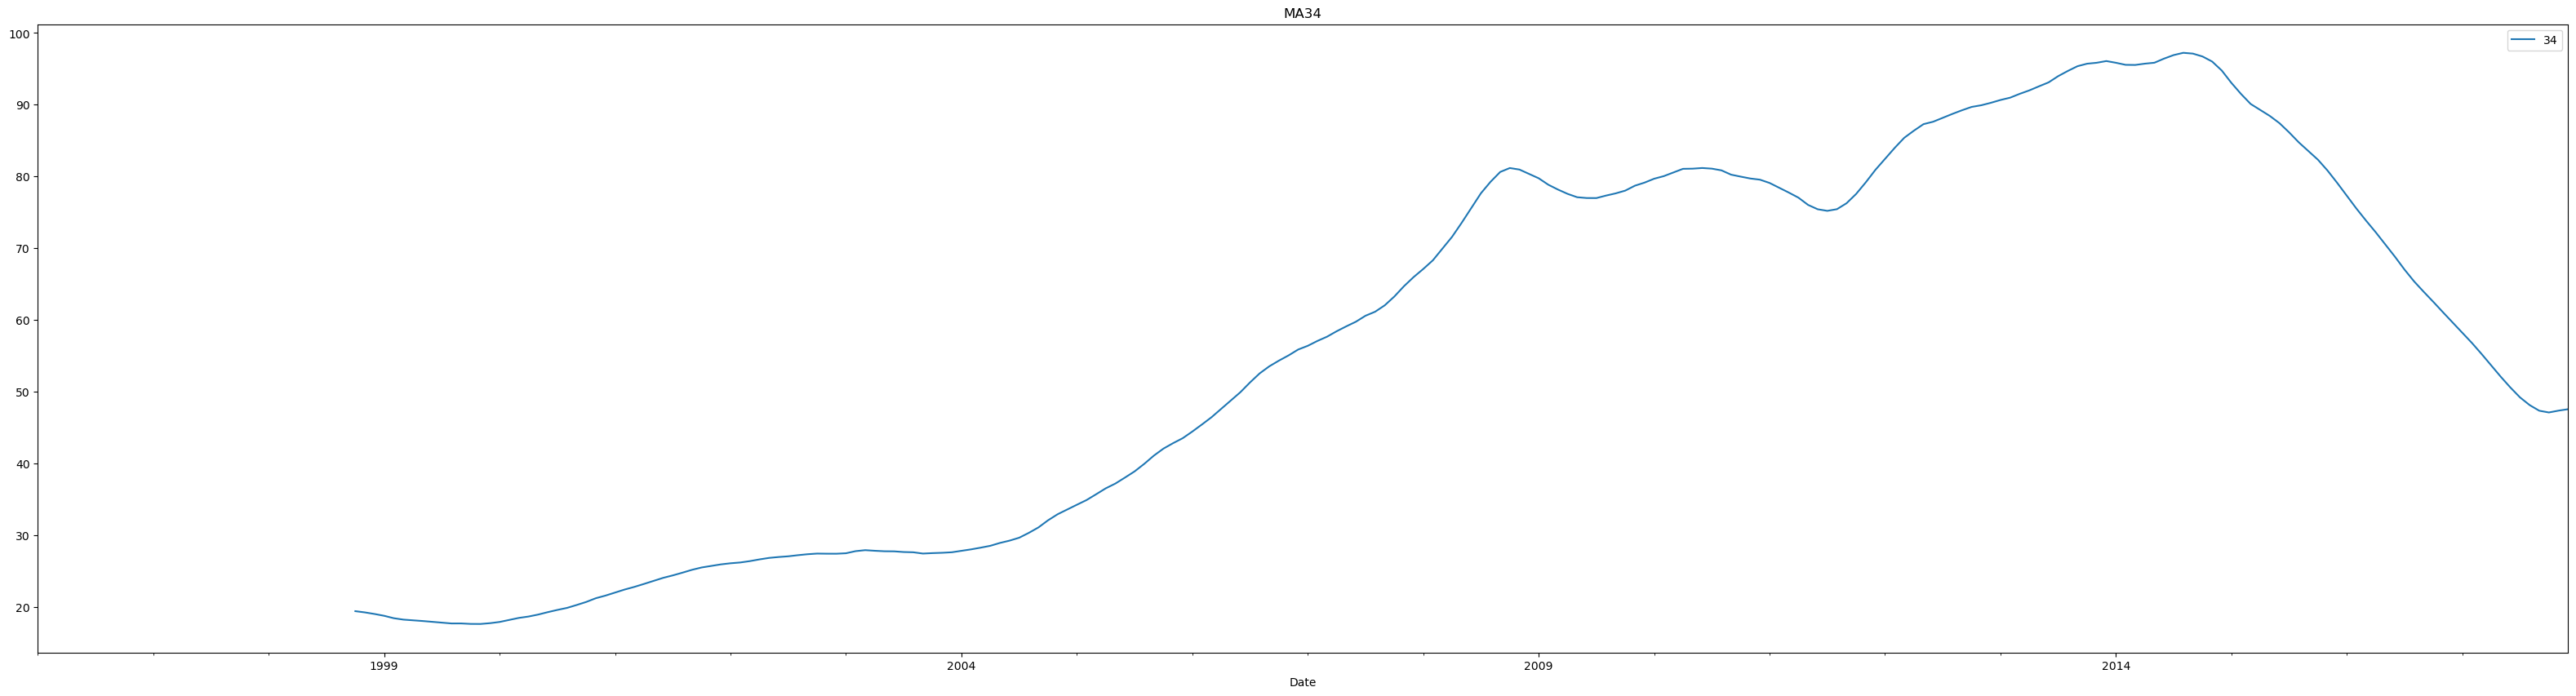

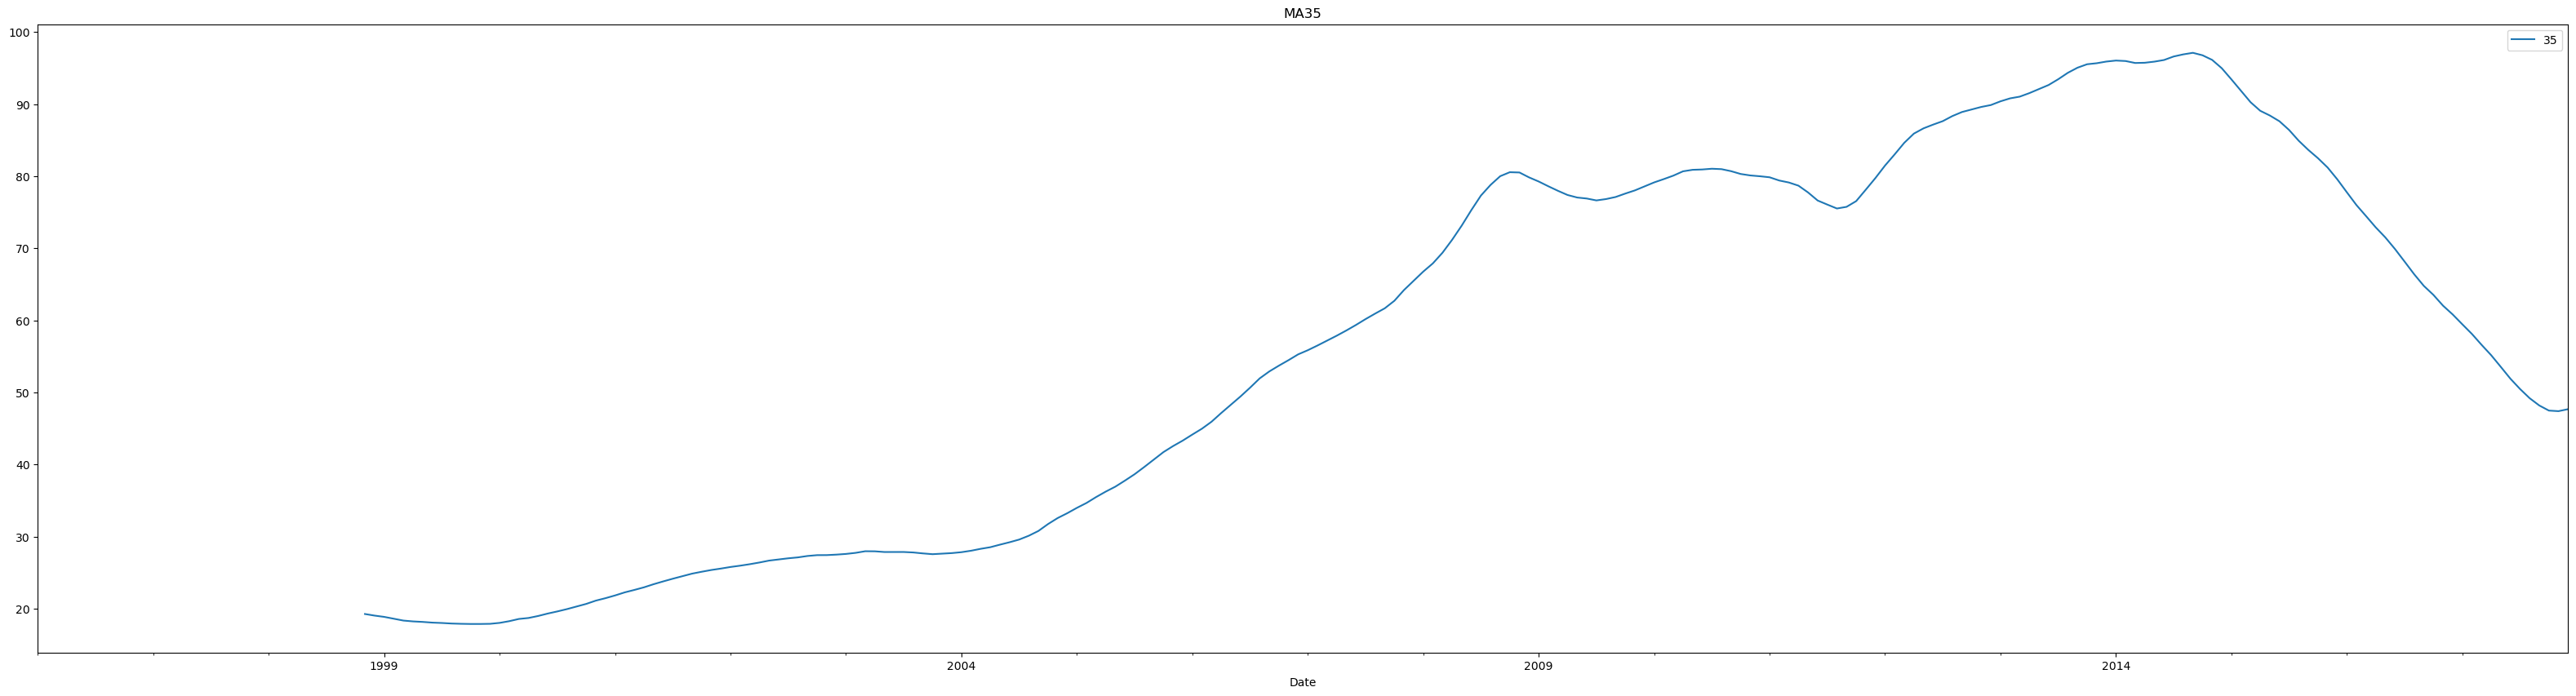

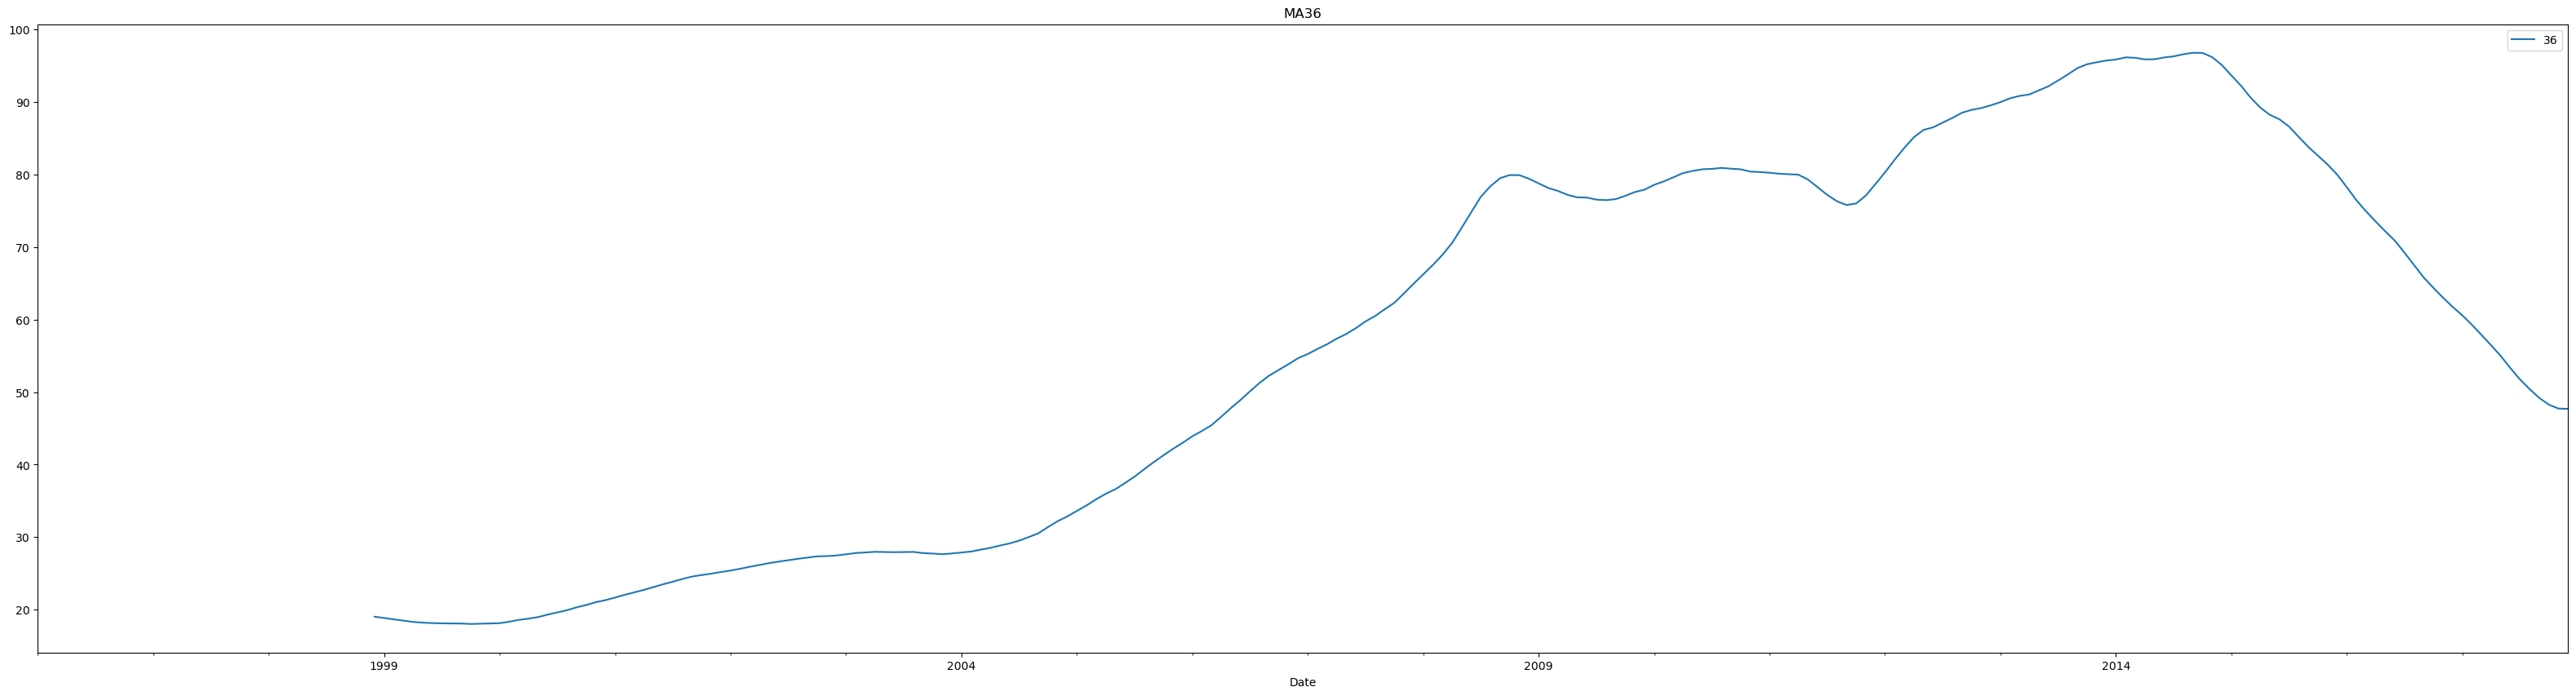

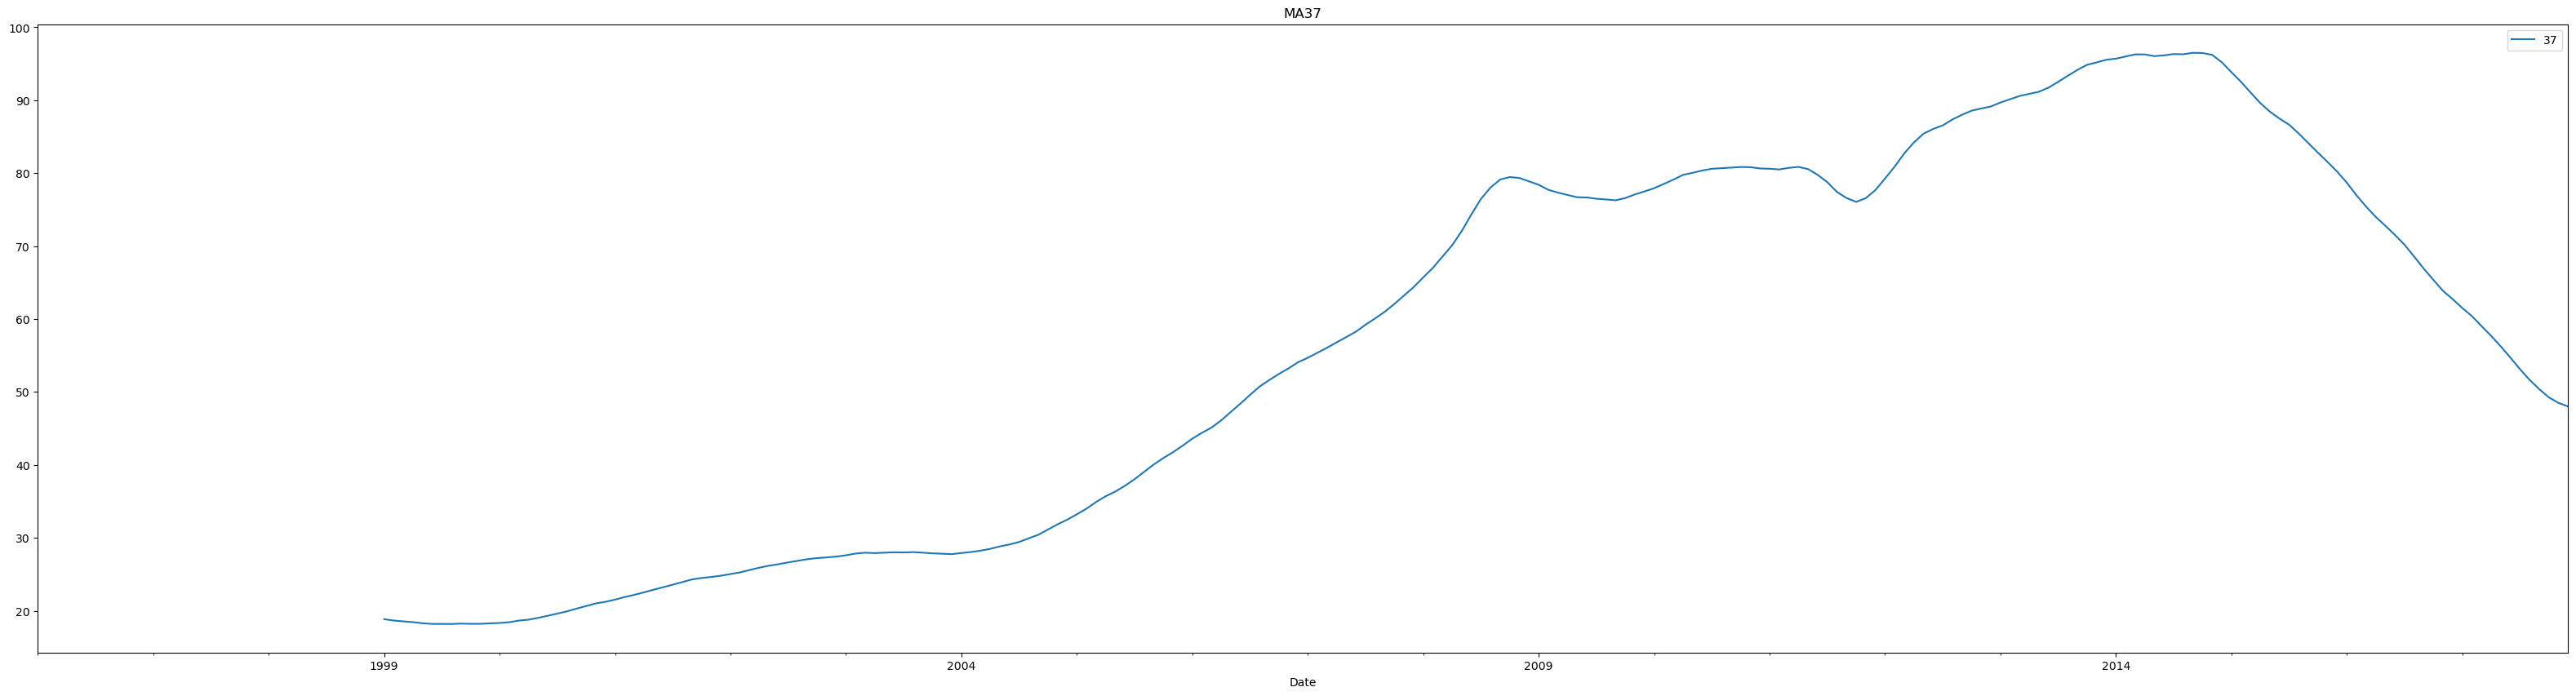

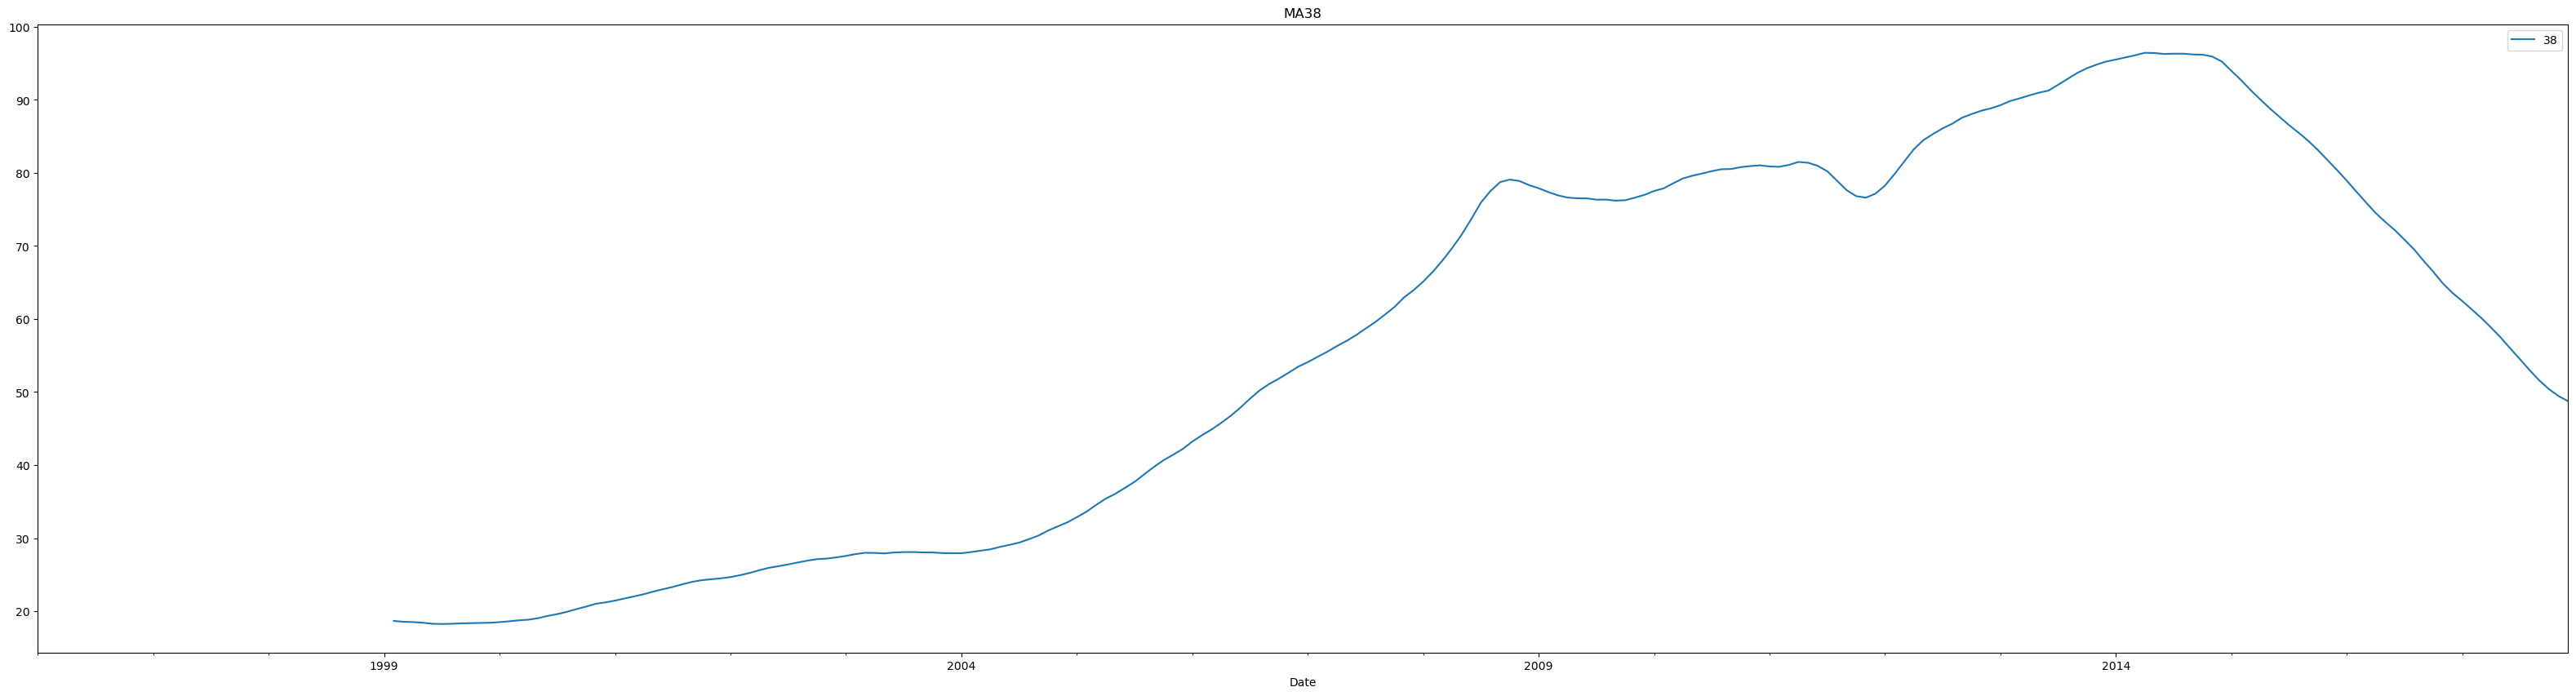

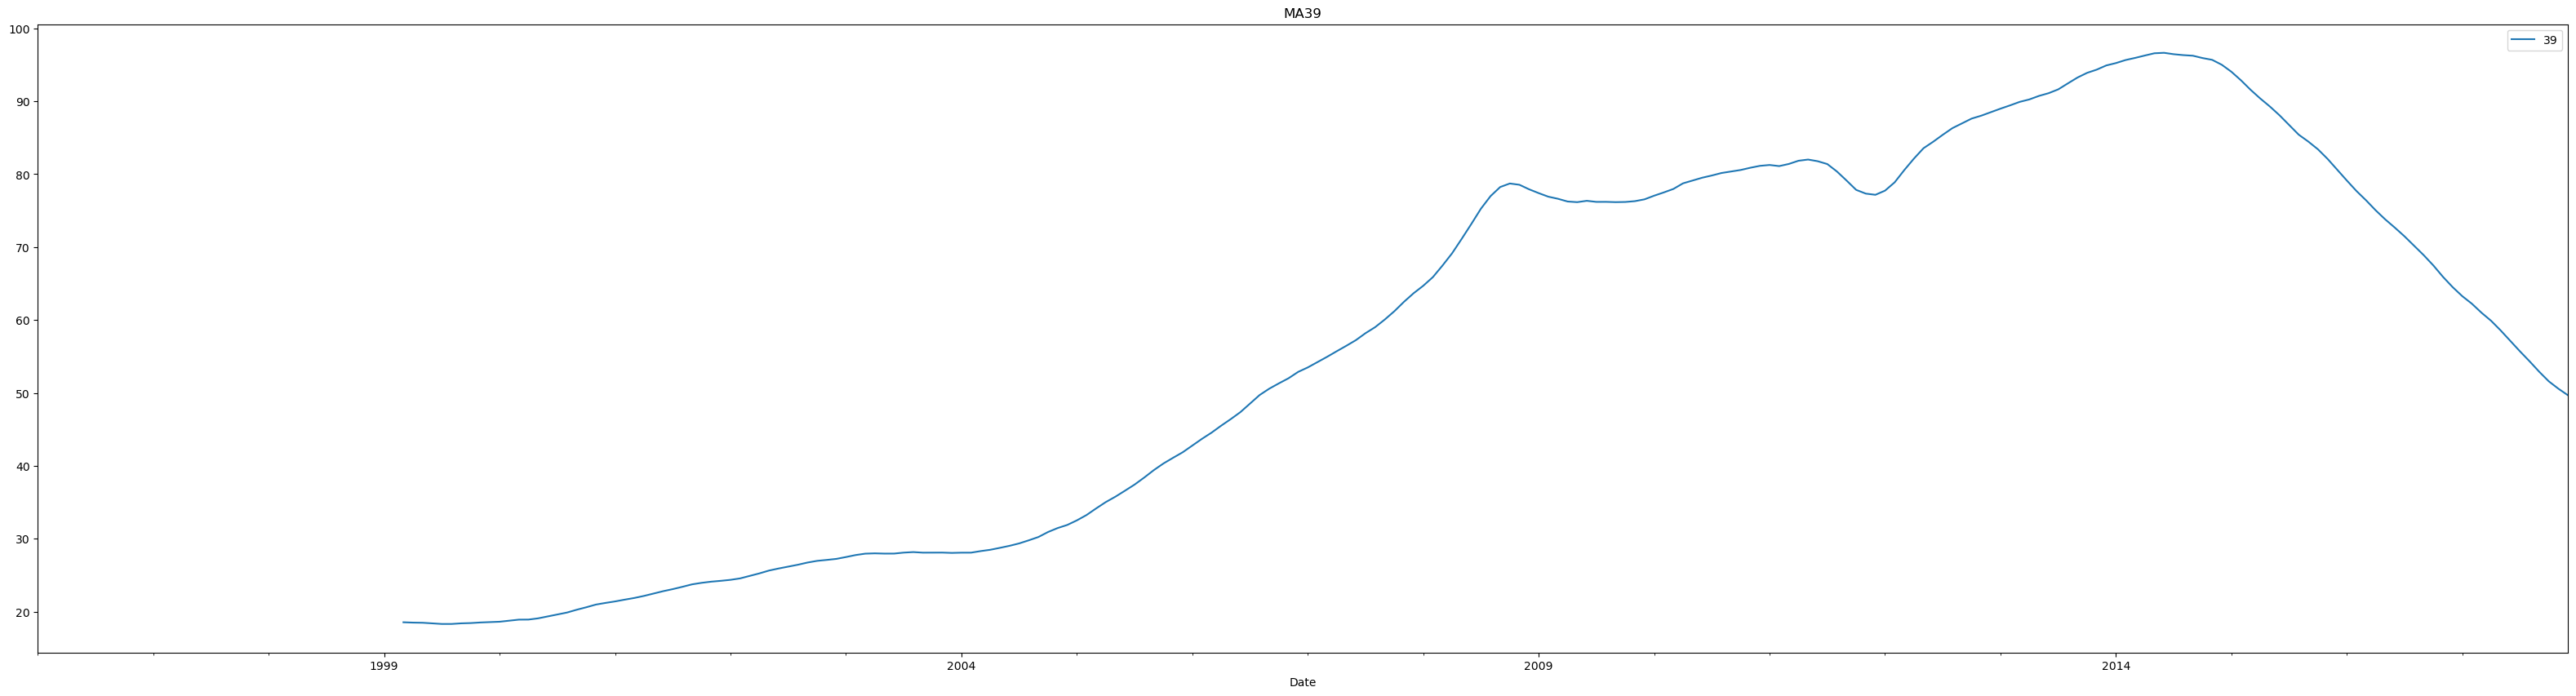

In [105]:
plt.figure(figsize=(40,10))
df_visu.Price.plot(label="org")
for i in range(2,40):
    plt.figure(figsize=(40,10))
    df_visu["Price"].rolling(i).mean().plot(label=str(i))
    plt.title("MA"+str(i))
    plt.legend(loc='best')
    plt.show()

from above visualization MA28 i.e period 28 graph is smoother as compared to other

### Time series decomposition plot
         It is use for finding proper Trends,Seasonality of Target column 

<Figure size 2400x1000 with 0 Axes>

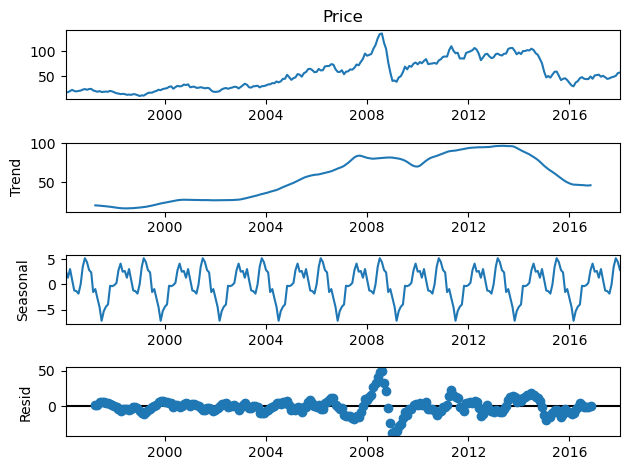

<Figure size 2400x1000 with 0 Axes>

In [106]:
plt.figure(figsize=(24,10))
decompose_ts_add = seasonal_decompose(df_visu.Price,period=28)     # with MA28
decompose_ts_add.plot()
plt.figure(figsize=(24,10))
plt.show()

It shows Trend is Polynomial and Sesonality is Additive

In [107]:
df_visu.reset_index('Date',inplace=True)

In [108]:
df_visu['Year'] = pd.to_datetime(df_visu['Date']).dt.strftime("%Y")
df_visu['Month'] = pd.to_datetime(df_visu['Date']).dt.strftime('%b')
#data['Day'] = pd.to_datetime(data['Date']).dt.strftime("%d")
df_visu.head()

Date      Price  Year Month
0 1996-01-31  18.933214  1996   Jan
1 1996-02-29  18.673929  1996   Feb
2 1996-03-31  21.047500  1996   Mar
3 1996-04-30  23.390714  1996   Apr
4 1996-05-31  21.185000  1996   May

Text(0, 0.5, 'Price')

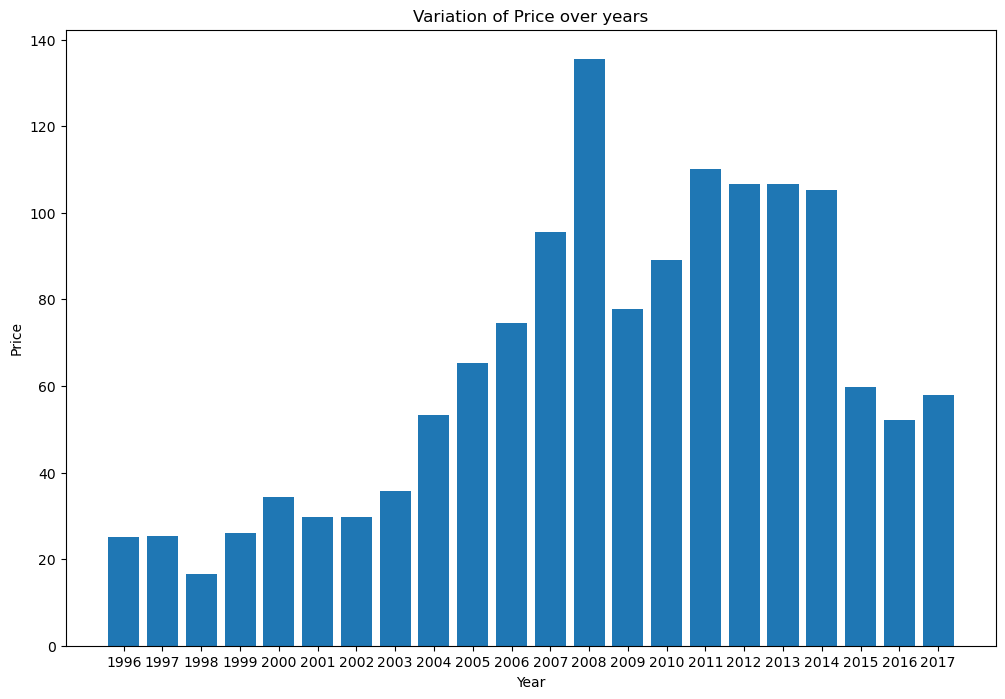

In [109]:
plt.figure(figsize=(12,8))
x=df_visu['Year']
y=df_visu['Price']
plt.bar(x,y)
plt.title('Variation of Price over years')
plt.xlabel('Year')
plt.ylabel('Price')

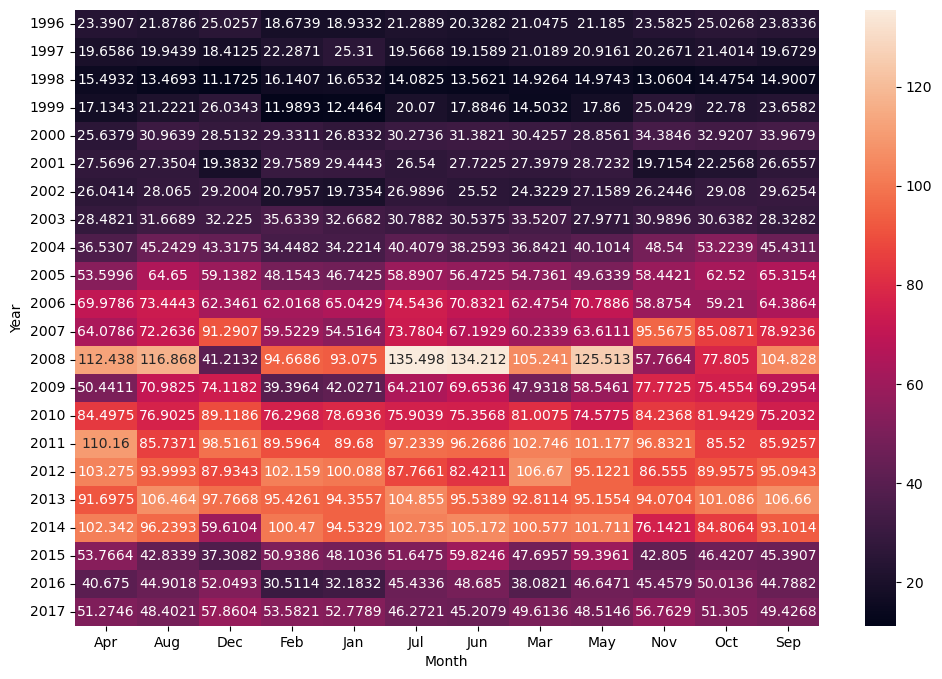

In [110]:
plt.figure(figsize=(12,8))
heatmap_y_month=pd.pivot_table(data=df_visu,values="Price",index='Year',columns="Month",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt='g')
plt.show()

from above heatmap it show that Price of oil were very high in year 2008 in June-July month.And lowest price was in year 1998 in month of December

## Checking stationarity on original treated data
               Now we will check whether the data is stationary or not. For this, we will perform a test called the Dickey-Fuller test. In the field of statistics, the Dickey-Fuller test (ADF) is used to test the null hypothesis, i.e. to check if a unit root is present in a sample of a time-series data. The alternative hypothesis is considered to be different on the version we use but is usually considered stationarity or trend-stationarity.

               Basically, we are trying to decide whether to accept the Null Hypothesis or go with the Alternative Hypothesis (that the time series has no unit root and is stationary).

               We end up deciding this based on the return of the p-value.

               A small p-value which is considered below 0.05 indicates strong evidence against the null hypothesis, thereby we reject the null hypothesis.

               A large p-value which is considered above 0.05 indicates weak or no evidence against the null hypothesis, thereby we fail to reject the null hypothesis.

               Let’s run the test:

1.Duckey fuller

In [111]:
def ad_test(dataset):
    dftest = adfuller(dataset,autolag="AIC")
    print("1. ADF : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. No of Lags : ",dftest[2])
    print("4. Num of Observations Used for ADF Regression and Critical Value Calculation : ",dftest[3])
    print("5. Critical Value : ")
    for key,val in dftest[4].items():
        print("\t",key, ":",val)

In [112]:
data

Date  Price  Year  Treated_Price
0    1996-01-01  19.55  1996          19.55
1    1996-01-02  19.81  1996          19.81
2    1996-01-03  19.89  1996          19.89
3    1996-01-04  19.91  1996          19.91
4    1996-01-05  20.26  1996          20.26
...         ...    ...   ...            ...
7387 2017-12-24  58.47  2017          58.47
7388 2017-12-25  58.59  2017          58.59
7389 2017-12-26  59.97  2017          59.97
7390 2017-12-27  59.64  2017          59.64
7391 2017-12-28  59.84  2017          59.84

[7392 rows x 4 columns]

In [113]:
 ad_test(data['Treated_Price'])

1. ADF :  -2.0692496053034715
2. P-Value :  0.25705785835702727
3. No of Lags :  36
4. Num of Observations Used for ADF Regression and Critical Value Calculation :  7355
5. Critical Value : 
	 1% : -3.431239406352867
	 5% : -2.861933049137047
	 10% : -2.5669792157603077


the p-value is greater than 0.05 so this data is non-stationary

## Converting Non-Stationary Data into Stationary Data
        Now it is clear that the data is non-stationary so we need to apply differencing to make our data stationary.
        Now let us do our first difference.

1.Differencing

In [114]:
data['first_diff']=data['Treated_Price']-data['Treated_Price'].shift(1)
data.head()

Date  Price  Year  Treated_Price  first_diff
0 1996-01-01  19.55  1996          19.55         NaN
1 1996-01-02  19.81  1996          19.81        0.26
2 1996-01-03  19.89  1996          19.89        0.08
3 1996-01-04  19.91  1996          19.91        0.02
4 1996-01-05  20.26  1996          20.26        0.35

In [115]:
ad_test(data['first_diff'].dropna())

1. ADF :  -12.536875577174593
2. P-Value :  2.361077076774562e-23
3. No of Lags :  36
4. Num of Observations Used for ADF Regression and Critical Value Calculation :  7354
5. Critical Value : 
	 1% : -3.4312395273369702
	 5% : -2.8619331025947052
	 10% : -2.566979244216616


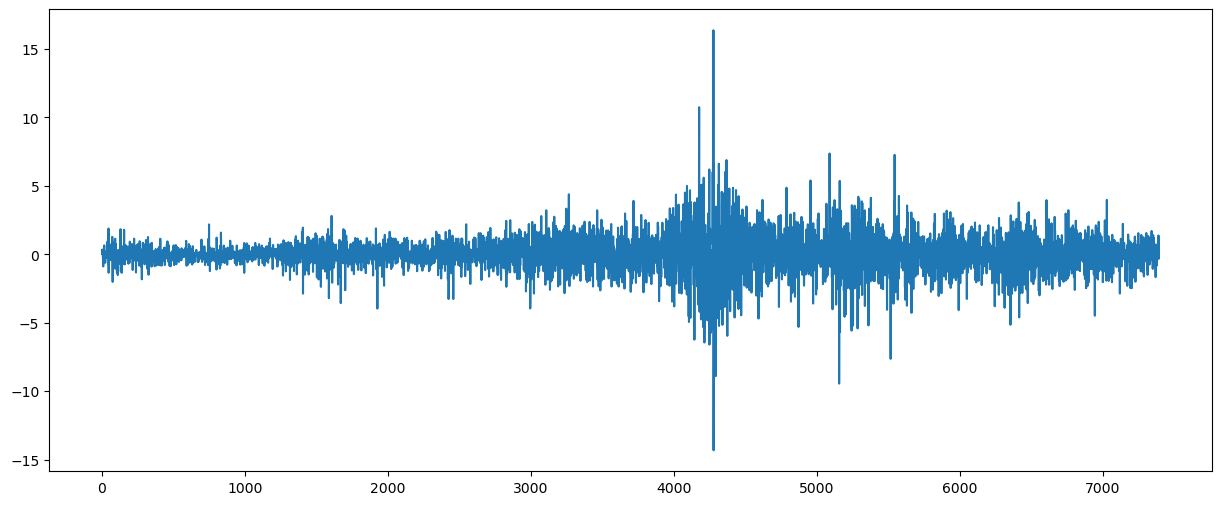

In [116]:
data['first_diff'].dropna().plot(figsize=(15, 6))
plt.show()

Average Price is around 0,so Data is now Stationary

## Feature Engineering

In [117]:
data.head()

Date  Price  Year  Treated_Price  first_diff
0 1996-01-01  19.55  1996          19.55         NaN
1 1996-01-02  19.81  1996          19.81        0.26
2 1996-01-03  19.89  1996          19.89        0.08
3 1996-01-04  19.91  1996          19.91        0.02
4 1996-01-05  20.26  1996          20.26        0.35

In [118]:
#data.reset_index('Date',inplace=True)
#data.tail()

In [119]:
#data['Year'] = pd.to_datetime(data['Date']).dt.strftime("%Y")
data['Month'] = pd.to_datetime(data['Date']).dt.strftime('%b')
data['Day'] = pd.to_datetime(data['Date']).dt.strftime("%d")

data.head()

Date  Price  Year  Treated_Price  first_diff Month Day
0 1996-01-01  19.55  1996          19.55         NaN   Jan  01
1 1996-01-02  19.81  1996          19.81        0.26   Jan  02
2 1996-01-03  19.89  1996          19.89        0.08   Jan  03
3 1996-01-04  19.91  1996          19.91        0.02   Jan  04
4 1996-01-05  20.26  1996          20.26        0.35   Jan  05

In [120]:
#OHE
month_dummies = pd.DataFrame(pd.get_dummies(data['Month']))
data = pd.concat([data,month_dummies],axis = 1)
data.head()

Date  Price  Year  Treated_Price  first_diff Month Day  Apr  Aug  Dec  \
0 1996-01-01  19.55  1996          19.55         NaN   Jan  01    0    0    0   
1 1996-01-02  19.81  1996          19.81        0.26   Jan  02    0    0    0   
2 1996-01-03  19.89  1996          19.89        0.08   Jan  03    0    0    0   
3 1996-01-04  19.91  1996          19.91        0.02   Jan  04    0    0    0   
4 1996-01-05  20.26  1996          20.26        0.35   Jan  05    0    0    0   

   Feb  Jan  Jul  Jun  Mar  May  Nov  Oct  Sep  
0    0    1    0    0    0    0    0    0    0  
1    0    1    0    0    0    0    0    0    0  
2    0    1    0    0    0    0    0    0    0  
3    0    1    0    0    0    0    0    0    0  
4    0    1    0    0    0    0    0    0    0

In [121]:
# Add the 't' column with values from 0 to 7391
data["t"] = np.arange(7392)

# Add the 't_squared' column with values calculated from 't'
data["t_squared"] = data["t"] * data["t"]

# Add the 'log_Price' column with logarithm of 'Price'
data["log_Price"] = np.log(data["Price"])

# Display the first few rows of the updated DataFrame
data.shape

(7392, 22)

In [122]:
data=data.drop(['Month','Price'],axis=1)
data=data.dropna()

In [123]:
data.head()

Date  Year  Treated_Price  first_diff Day  Apr  Aug  Dec  Feb  Jan  \
1 1996-01-02  1996          19.81        0.26  02    0    0    0    0    1   
2 1996-01-03  1996          19.89        0.08  03    0    0    0    0    1   
3 1996-01-04  1996          19.91        0.02  04    0    0    0    0    1   
4 1996-01-05  1996          20.26        0.35  05    0    0    0    0    1   
5 1996-01-06  1996          20.26        0.00  06    0    0    0    0    1   

   Jul  Jun  Mar  May  Nov  Oct  Sep  t  t_squared  log_Price  
1    0    0    0    0    0    0    0  1          1   2.986187  
2    0    0    0    0    0    0    0  2          4   2.990217  
3    0    0    0    0    0    0    0  3          9   2.991222  
4    0    0    0    0    0    0    0  4         16   3.008648  
5    0    0    0    0    0    0    0  5         25   3.008648

##  Train - Test Split

In [124]:
# Segreate the Train & Test Data
train=data.head(5913)
test=data.tail(1478)

## Model Building
           Their are two forcasting models
               1.Model based
               2.Data Driven models

1.Model Based

In [125]:
train.head()

Date  Year  Treated_Price  first_diff Day  Apr  Aug  Dec  Feb  Jan  \
1 1996-01-02  1996          19.81        0.26  02    0    0    0    0    1   
2 1996-01-03  1996          19.89        0.08  03    0    0    0    0    1   
3 1996-01-04  1996          19.91        0.02  04    0    0    0    0    1   
4 1996-01-05  1996          20.26        0.35  05    0    0    0    0    1   
5 1996-01-06  1996          20.26        0.00  06    0    0    0    0    1   

   Jul  Jun  Mar  May  Nov  Oct  Sep  t  t_squared  log_Price  
1    0    0    0    0    0    0    0  1          1   2.986187  
2    0    0    0    0    0    0    0  2          4   2.990217  
3    0    0    0    0    0    0    0  3          9   2.991222  
4    0    0    0    0    0    0    0  4         16   3.008648  
5    0    0    0    0    0    0    0  5         25   3.008648

In [126]:
# try and test

###  Models
1.linear

2.Exponetial

3.Quadratic

4.Additive seosonality

5.Additive Quadratic

6.Multiplicative seosonality

7.Multiplicative additive

8.Simple Exponetial method

9.Holt

10.Holts winter exponential smoothing with additive

11.ARIMA

12.LSTM

13.RNN

### Linear Model

In [127]:
linear_model = smf.ols('first_diff~t',data=train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(test['t'])))                 # Predict on test data
rmse_linear = np.sqrt(np.mean((np.array(test['first_diff'])-np.array(pred_linear))**2)) # Calculate RMSE --> test -predict_linear
print("RMSE Linear: ",rmse_linear)

RMSE Linear:  1.0030118830768435


### Exponential Model
it is used for multipicative seasonality

In [128]:
Exp = smf.ols('log_Price~t',data=train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(test['first_diff'])-np.array(np.exp(pred_Exp)))**2))
print("RMSE Exponential: ",rmse_Exp)

RMSE Exponential:  157.474529868995


### Quadratic Model

In [129]:
Quad = smf.ols('first_diff~t+t_squared',data=train).fit()
pred_Quad = pd.Series(Quad.predict(test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(test['first_diff'])-np.array(pred_Quad))**2))
print("RMSE Quadratic: ",rmse_Quad)

RMSE Quadratic:  1.0024494082249544


### Additive Seasonality Model

In [130]:
add_sea = smf.ols('first_diff~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea = pd.Series(add_sea.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']]))
rmse_add_sea = np.sqrt(np.mean((np.array(test['first_diff'])-np.array(pred_add_sea))**2))
print("RMSE Additive seasonality: ",rmse_add_sea)

RMSE Additive seasonality:  1.001596946241806


### Additive Seasonality Quadratic Model

In [131]:
add_sea_Quad = smf.ols('first_diff~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data=train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(test['first_diff'])-np.array(pred_add_sea_quad))**2))
print("RMSE Additive Seasonality Quadratic:",rmse_add_sea_quad )

RMSE Additive Seasonality Quadratic: 1.0015046725317003


### Multiplicative Seasonality Model

In [132]:
Mul_sea = smf.ols('log_Price~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data = train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(test['first_diff'])-np.array(np.exp(pred_Mult_sea)))**2))
print("RMSE Multiplicative Seasonality:",rmse_Mult_sea)

RMSE Multiplicative Seasonality: 42.8910995577234


2. Data-Driven Models

In [133]:
#def mean_absolute_percentage_error(actual, predicted):
    #non_zero_indices = actual != 0
   # actual_non_zero = actual[non_zero_indices]
   # predicted_non_zero = predicted[non_zero_indices]
   # return np.mean(np.abs((actual_non_zero - predicted_non_zero) / actual_non_zero)) * 100

### Simple Exponential Method

In [134]:
# Fit a Simple Exponential Smoothing (SES) model to 'first_diff' column
ses_model = SimpleExpSmoothing(train["first_diff"]).fit(smoothing_level=0.2)
# Make predictions using the SES model
pred_ses = ses_model.predict(start=test.index[0], end=test.index[-1])
# Calculate MAPE
#mape = mean_absolute_percentage_error(test['first_diff'].dropna(), pred_ses)
#print("MAPE:", mape)
# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(test['first_diff']) - np.array(pred_ses)) ** 2))
rmse

1.0229954173931364

### Holt method

In [135]:
# Holt method 
# Fit a Holt model to 'first_diff' column
hw_model = Holt(train["first_diff"]).fit(smoothing_level=0.8, smoothing_slope=0.2)
# Make predictions using the Holt model
pred_hw = hw_model.predict(start=test.index[0], end=test.index[-1])
# Calculate MAPE
#mape = mean_absolute_percentage_error(test['first_diff'].dropna(), pred_hw)
#print("MAPE:", mape)
# Calculate RMSE
rmse1 = np.sqrt(np.mean((np.array(test['first_diff']) - np.array(pred_hw)) ** 2))
rmse1

194.0905598614319

### Holts winter exponential smoothing with additive seasonality and additive trend

In [136]:
# Fit an ExponentialSmoothing model with additive seasonality and additive trend to 'first_diff' column
hwe_model_add_add = ExponentialSmoothing(train["first_diff"], seasonal="add", trend="add", seasonal_periods=23).fit()
# Make predictions using the Holt-Winters' additive model
pred_hwe_add_add = hwe_model_add_add.predict(start=test.index[0], end=test.index[-1])
# Calculate MAPE
#mape = mean_absolute_percentage_error(test['first_diff'].dropna(), pred_hwe_add_add)
#print("MAPE:", mape)
# Calculate RMSE
rmse2 = np.sqrt(np.mean((np.array(test['first_diff']) - np.array(pred_hwe_add_add)) ** 2))
rmse2

1.0068969620991408

 ACF & PACF plot
 
           ACF -Autocorrelation plot
           PACF-Partial auto-correlation function

<Figure size 4000x1400 with 0 Axes>

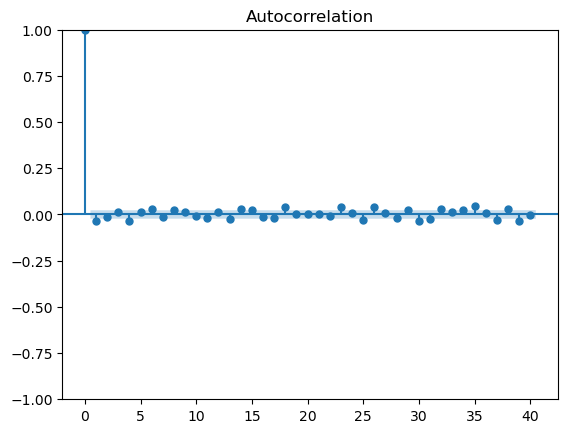

In [137]:
# ACF plot
plt.figure(figsize=(40,14))
tsa_plots.plot_acf(data.first_diff,lags=40)
plt.show()

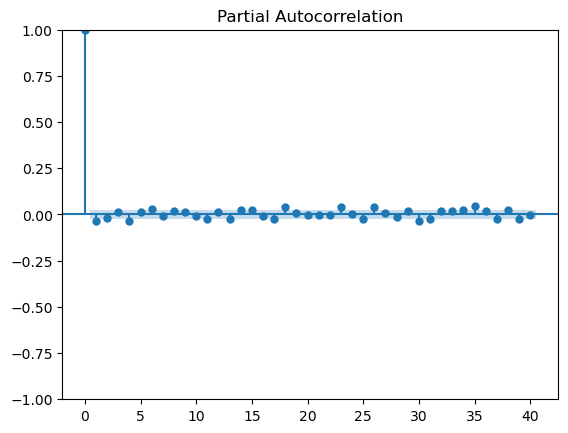

In [138]:
#PACF
tsa_plots.plot_pacf(data.first_diff,lags=40)
plt.show()

### ARIMA

'''From ACF plot we can predict upto 22 month i.e in daywise upto 730 days..so value for order 'q' is 730.However, it is important to note that selecting a large value of q without careful consideration can lead to overfitting and poor model performance.It is generally recommended to consider other factors and diagnostic tools, such as the partial autocorrelation function (PACF), information criteria (e.g., AIC, BIC), and model diagnostics, to determine the optimal order of the MA model.The PACF helps identify the direct relationship between the current observation and the observation at a specific lag, while the AIC and BIC provide measures of model goodness-of-fit and parsimony. '''

In [139]:
# Auto arima

import pmdarima as pm
# Fit the auto ARIMA model
model_auto = pm.auto_arima(train['first_diff'], seasonal=False, trace=True, suppress_warnings=True)

# Print the model summary
print(model_auto.summary())

# Make predictions
n_periods = 10  # Number of periods to forecast
forecast, conf_int = model_auto.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecasted values
print("Forecasted values:")
print(forecast)

# Print the confidence intervals
print("Confidence intervals:")
print(conf_int)


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=18366.923, Time=3.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=18403.868, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=18400.512, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=18400.346, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=18399.427, Time=0.90 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18399.051, Time=0.57 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=18368.672, Time=2.50 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=18368.667, Time=2.82 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=18401.059, Time=0.34 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=18400.466, Time=1.23 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=18399.798, Time=1.03 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=18370.479, Time=2.20 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=18367.944, Time=5.71 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 20.624 seconds
        

In [140]:
from statsmodels.tsa.arima.model import ARIMA
# Create an ARIMA model and fit it to the data
arima = ARIMA(train['Treated_Price'], order=(2, 0, 2))
model_fit = arima.fit()

# Use the fitted model to predict the next 1848 steps ahead
forecast = model_fit.forecast(steps=1478)

forecast.head(10)

5913    105.313666
5914    105.284128
5915    105.260139
5916    105.230842
5917    105.206674
5918    105.177603
5919    105.153270
5920    105.124409
5921    105.099926
5922    105.071261
Name: predicted_mean, dtype: float64

In [141]:
y=test['Treated_Price']
mse = mean_squared_error(y, forecast)
rmse_arima = math.sqrt(mse)
print("RMSE:", rmse_arima)

RMSE: 32.32156229548764


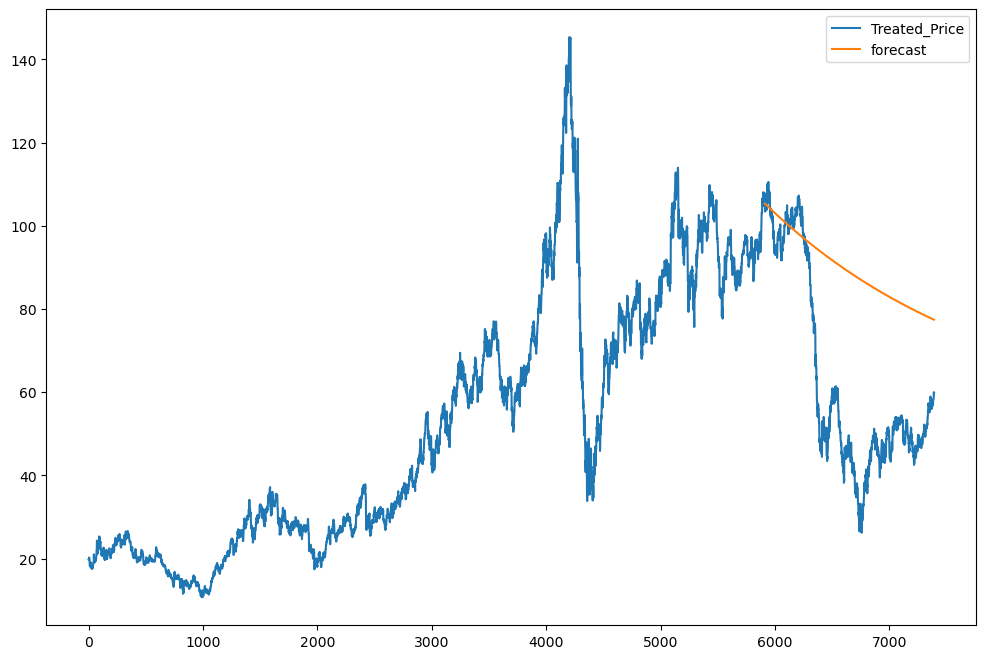

In [142]:
start = len(data.iloc[:5913])
end = len(data.iloc[:5913]) + len(data.iloc[5914:]) - 1
data['forecast'] = model_fit.predict(start=start, end=end, dynamic=True)
#data['first_diff']=test['first_diff']
data[['Treated_Price', 'forecast']].plot(figsize=(12, 8))
plt.show()

### LSTM
              (Long Short-Term Memory) neural network for time series forecasting.

In [143]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Treated_Price'].values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_data) * 0.80)  # 75% for training, 25% for testing
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Define the function to create input and output sequences for LSTM
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Set the sequence length and create sequences for training
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)

# Create the LSTM model
model1 = Sequential()
model1.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model1.add(LSTM(units=50))
model1.add(Dense(units=1))
model1.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model1.fit(X_train, y_train, epochs=10, batch_size=16)

# Make predictions on the test set
X_test, y_test = create_sequences(test_data, sequence_length)
y_pred = model1.predict(X_test)

# Inverse scale the predictions and the actual values
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)
print(y_pred_inv)
print(y_test_inv)

Epoch 1/10
369/369 [==============================] - 7s 8ms/step - loss: 0.0025
Epoch 2/10
369/369 [==============================] - 3s 7ms/step - loss: 3.1761e-04
Epoch 3/10
369/369 [==============================] - 3s 8ms/step - loss: 3.3088e-04
Epoch 4/10
369/369 [==============================] - 3s 8ms/step - loss: 2.8418e-04
Epoch 5/10
369/369 [==============================] - 3s 8ms/step - loss: 2.8335e-04
Epoch 6/10
369/369 [==============================] - 3s 8ms/step - loss: 2.4014e-04
Epoch 7/10
369/369 [==============================] - 3s 8ms/step - loss: 2.2064e-04
Epoch 8/10
369/369 [==============================] - 3s 8ms/step - loss: 1.9597e-04
Epoch 9/10
369/369 [==============================] - 3s 8ms/step - loss: 1.6892e-04
Epoch 10/10
46/46 [==============================] - 1s 5ms/step
[[107.9275  ]
 [108.19845 ]
 [108.335754]
 ...
 [ 59.28794 ]
 [ 59.73491 ]
 [ 60.06974 ]]
[[107.46]
 [107.46]
 [107.46]
 ...
 [ 59.97]
 [ 59.64]
 [ 59.84]]


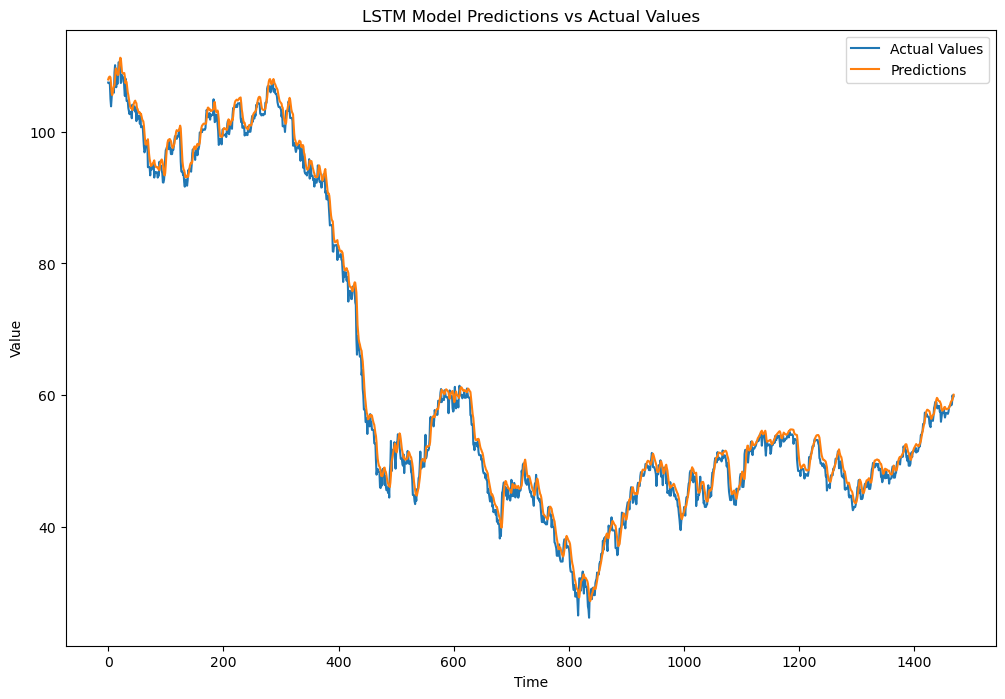

In [144]:
import matplotlib.pyplot as plt

# Plot the predictions and actual values
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual Values')
plt.plot(y_pred_inv, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('LSTM Model Predictions vs Actual Values')
plt.legend()
plt.show()

In [145]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse_lstm = math.sqrt(mse)
print("RMSE:", rmse_lstm)

RMSE: 1.4996491886321552


### RNN
           (Recurrent Neural Network) 

In [146]:
# Normalize the data
scaler1 = MinMaxScaler()
scaled_data1 = scaler1.fit_transform(data['Treated_Price'].values.reshape(-1, 1))

# Split the data into train and test sets
train_size = int(len(scaled_data1) * 0.80)  # 75% for training, 25% for testing
train_data = scaled_data1[:train_size]
test_data = scaled_data1[train_size:]


# Define the function to create input and output sequences for RNN
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Set the sequence length and create sequences for training
sequence_length = 10
X_train, y_train = create_sequences(train_data, sequence_length)

# Create the RNN model
model = Sequential()
model.add(SimpleRNN(units=50, input_shape=(sequence_length, 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16)

# Make predictions on the test set
X_test, y_test = create_sequences(test_data, sequence_length)
y_pred1 = model.predict(X_test)

# Inverse scale the predictions and the actual values
y_pred_inv1 = scaler.inverse_transform(y_pred1)
y_test_inv1 = scaler.inverse_transform(y_test)

# Print the predictions and actual values
print("Predictions:", y_pred_inv1)
print("Actual Values:", y_test_inv1)

Epoch 1/10
369/369 [==============================] - 2s 2ms/step - loss: 0.0031
Epoch 2/10
369/369 [==============================] - 1s 2ms/step - loss: 1.7655e-04
Epoch 3/10
369/369 [==============================] - 1s 2ms/step - loss: 1.5619e-04
Epoch 4/10
369/369 [==============================] - 1s 2ms/step - loss: 1.3876e-04
Epoch 5/10
369/369 [==============================] - 1s 2ms/step - loss: 1.4114e-04
Epoch 6/10
369/369 [==============================] - 1s 2ms/step - loss: 1.3563e-04
Epoch 7/10
369/369 [==============================] - 1s 3ms/step - loss: 1.1262e-04
Epoch 8/10
369/369 [==============================] - 1s 3ms/step - loss: 1.1283e-04
Epoch 9/10
369/369 [==============================] - 1s 2ms/step - loss: 1.1179e-04
Epoch 10/10
46/46 [==============================] - 0s 2ms/step
Predictions: [[107.28698 ]
 [107.346375]
 [107.3451  ]
 ...
 [ 58.602703]
 [ 59.639874]
 [ 59.71817 ]]
Actual Values: [[107.46]
 [107.46]
 [107.46]
 ...
 [ 59.97]
 [ 59.64]
 

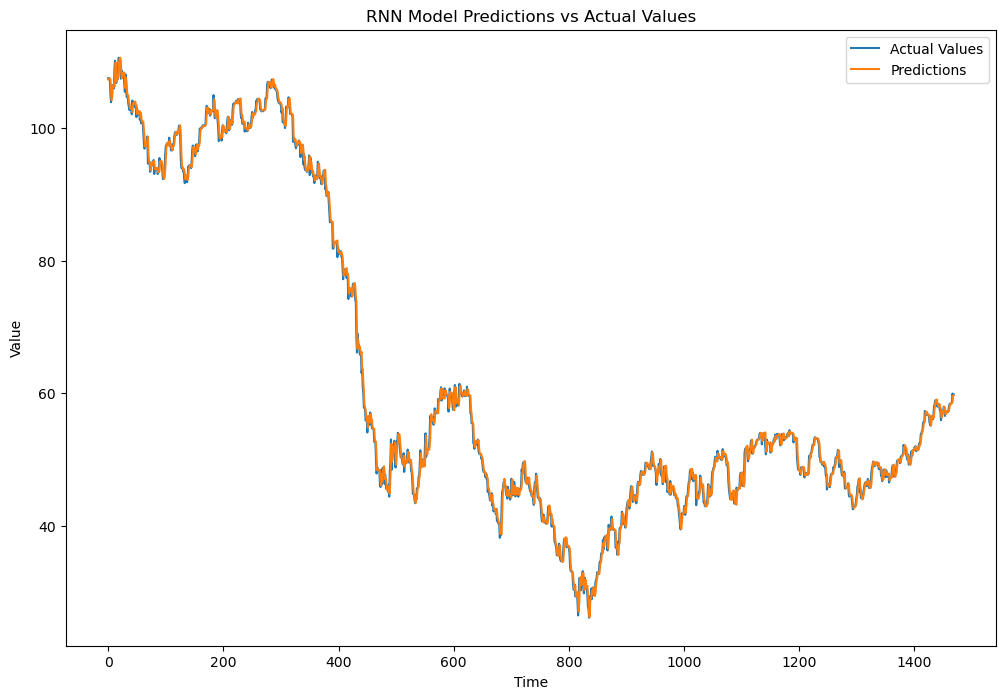

In [147]:
import matplotlib.pyplot as plt

# Plot the predictions and actual values
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv1, label='Actual Values')
plt.plot(y_pred_inv1, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('RNN Model Predictions vs Actual Values')
plt.legend()
plt.show()


In [148]:
mse = mean_squared_error(y_test_inv1, y_pred_inv1)
rmse_rnn = math.sqrt(mse)
print("RMSE:", rmse_rnn)

RMSE: 1.0296662844049007


### Prophet model

In [149]:
data.head()

Date  Year  Treated_Price  first_diff Day  Apr  Aug  Dec  Feb  Jan  \
1 1996-01-02  1996          19.81        0.26  02    0    0    0    0    1   
2 1996-01-03  1996          19.89        0.08  03    0    0    0    0    1   
3 1996-01-04  1996          19.91        0.02  04    0    0    0    0    1   
4 1996-01-05  1996          20.26        0.35  05    0    0    0    0    1   
5 1996-01-06  1996          20.26        0.00  06    0    0    0    0    1   

   ...  Jun  Mar  May  Nov  Oct  Sep  t  t_squared  log_Price  forecast  
1  ...    0    0    0    0    0    0  1          1   2.986187       NaN  
2  ...    0    0    0    0    0    0  2          4   2.990217       NaN  
3  ...    0    0    0    0    0    0  3          9   2.991222       NaN  
4  ...    0    0    0    0    0    0  4         16   3.008648       NaN  
5  ...    0    0    0    0    0    0  5         25   3.008648       NaN  

[5 rows x 21 columns]

In [150]:
# Rename the columns to match Prophet's requirements
data = data.rename(columns={'Date': 'ds', 'Treated_Price': 'y'})
data.head()

ds  Year      y  first_diff Day  Apr  Aug  Dec  Feb  Jan  ...  Jun  \
1 1996-01-02  1996  19.81        0.26  02    0    0    0    0    1  ...    0   
2 1996-01-03  1996  19.89        0.08  03    0    0    0    0    1  ...    0   
3 1996-01-04  1996  19.91        0.02  04    0    0    0    0    1  ...    0   
4 1996-01-05  1996  20.26        0.35  05    0    0    0    0    1  ...    0   
5 1996-01-06  1996  20.26        0.00  06    0    0    0    0    1  ...    0   

   Mar  May  Nov  Oct  Sep  t  t_squared  log_Price  forecast  
1    0    0    0    0    0  1          1   2.986187       NaN  
2    0    0    0    0    0  2          4   2.990217       NaN  
3    0    0    0    0    0  3          9   2.991222       NaN  
4    0    0    0    0    0  4         16   3.008648       NaN  
5    0    0    0    0    0  5         25   3.008648       NaN  

[5 rows x 21 columns]

In [151]:
!pip install prophet 

In [152]:
from prophet import Prophet

In [153]:
# Create a new Prophet instance
model_pro = Prophet()

# Fit the model to the data
model_pro.fit(data)

# Define the number of periods to forecast
future_periods = 10

# Generate future dates
future_dates = model_pro.make_future_dataframe(periods=future_periods)

# Perform the forecast
forecast = model_pro.predict(future_dates)

# Extract the actual values from the dataset
actual_values = data['y'].values[-future_periods:]

# Extract the predicted values from the forecast
predicted_values = forecast['yhat'].values[-future_periods:]

# Calculate RMSE
rmse_pro = np.sqrt(mean_squared_error(actual_values, predicted_values))

# Print RMSE
print("RMSE:", rmse_pro)


10:04:13 - cmdstanpy - INFO - Chain [1] start processing
10:04:15 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 30.27378031307897


In [154]:
#Creating Table of rmse's
table= {"MODEL_BASED":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad",
                           "rmse_Mult_sea","Simple_Exp","Hold_method","HWESAA",]),
        "RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,
                                 rmse_Mult_sea,rmse,rmse1,rmse2])}
table_rmse=pd.DataFrame(table)
table_rmse

MODEL_BASED  RMSE_Values
0        rmse_linear     1.003012
1           rmse_Exp   157.474530
2          rmse_Quad     1.002449
3       rmse_add_sea     1.001597
4  rmse_add_sea_quad     1.001505
5      rmse_Mult_sea    42.891100
6         Simple_Exp     1.022995
7        Hold_method   194.090560
8             HWESAA     1.006897

In [155]:
#Creating Table of rmse's for DATA_DRIVEN_MODELs
table1= {"DATA_DRIVEN_MODEL":pd.Series(["ARIMA","LSTM","RNN","Prophet"]),
        "RMSE_Values":pd.Series([rmse_arima,
                                 rmse_lstm,rmse_rnn,rmse_pro])}
table_rmse1=pd.DataFrame(table1)
table_rmse1

DATA_DRIVEN_MODEL  RMSE_Values
0             ARIMA    32.321562
1              LSTM     1.499649
2               RNN     1.029666
3           Prophet    30.273780

The RMSE values scores indicate the performance of each model in predicting the test data. Lower RMSE values indicate better predictive accuracy. Based on the values, the models with the lowest RMSE is the Prophet model.

In [159]:
import pickle
filename = 'Forcasting_RNN.pkl'
pickle.dump(model, open(filename,'wb'))
model=pickle.load(open('Forcasting_RNN.pkl','rb'))
